# Assignment Module 6: Regression for Numeric Data 


 

## Group Members:
- Eli Weiss
- Omar Hussein
- Julian Ruggiero

## Introduction

#### In this study we will attempt to use statistical methods to find attributes of wine that are predictive of the amount of sales (in cases) that wine will have. 

__1)__ We will begin the study with exploratory data analysis. We will seek to understand the shape and form of the data, identify issues with the data, and find insights that will shape our approach to choosing a method for predicting sales.<br/><br/>
__2)__ We will then clean the data and make transformations as needed so that the data is in an appropriate format for modeling. We will resolve any issues that were identified in our EDA in step 1.<br/><br/>
__3)__ Following this we will make an informed decision based on empirical and domain knowledge from the EDA and research respectively to choose which features we will include in the models. <br/><br/>
__4)__ After we have selected the features we will build two sets of features. We will run these features through 3 different types of models. The first will be Linear Regression models, the second type will be Poisson Models, and the third type will be Negative Binomial Regression. In total we will have seven models to choose from.<br/><br/>
__5)__ Once we have selected the best of these 7 models we will then test it on a test data set to see how it preforms on new data.

***

## Exploratory Data Analysis

The data set I will be using is comprised of information on more than 12,700 wines, with many of the attributes being related to the chemical composition of them. An overview of the data attributes is provided below, where I also included some of the measurement units based on research about the values of these attributes.

| Data Set Attribute  | Description 
|:--------------------|:----------------------------------------------------------------------------- |
|__INDEX__             |Unique ID                                                                   | 
|__TARGET__            |Response Variable (indicates # of cases of wine sold)                       |
|__FixedAcidity__      |FixedAcidity of the wine (g/L)                                              |
|__VolatileAcidity__   |Volatile acid content of the wine (g/L)                                     |
|__CitricAcid__        |Citric Acid content of the wine (g/L)                                       |
|__ResidualSugar__     |Residual sugar content of the wine (g/L)                                    |
|__Chlorides__         |Chloride content of the wine                                                |
|__FreeSulfurDioxide__ |Sulfur Dioxide content of the wine (mg/L)                                   |
|__TotalSulfurDioxide__|Total sulfur dioxide content of the wine (mg/L)                             |
|__Density__           |Density of the wine (g/mL)                                                  |
|__pH__                |pH of the wine                                                              |
|__Sulphates__         |Sulfate content of the wine                                                 |
|__Alcohol__           |Alcohol Content                                                             |
|__LabelAppeal__       |Subjective marketing score that indicates the appeal of the design of the label on the bottle                                                                                 |
|__AcidIndex__         |Measures total acidity of wine via a weighted average                       |
|__STARS__             |Wine rating as determined by experts (4 = excellent; 1 = Poor)              |

In [1]:
# importing libraries needed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot
from pandas.plotting import scatter_matrix
import missingno as msno
from IPython.display import Markdown, display
import statsmodels.api as sm
from statsmodels.tools import add_constant as add_constant
import statsmodels.formula.api as smf

# styling matplotlib graphs
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8,4)

C:\Users\julir\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


#### Helper functions

Helper Functions are user defined functions that will be used later on in this study.
Below are several functions:
1) Backwards elimination - This is a model selection technique
2) Display Scores - This function returns the cross validated scores of a model
3) Calc VIF - This returns the VIF score for every variable in a dataframe

In [2]:
def backwards_elem(data_frame, dep_var, col_list):
    
    """
    Receives a dataframe, dep_val (target variable) and 
    initial list of explanatory features. 
    Returns the list of attributes with a p-value lower than 0.05
        Output => list
    """
    while len(col_list) > 0:
        
        # Creating a model.
        model=sm.OLS(dep_var, data_frame[col_list])#.fit()
        
        # Result of the model fitting.
        result=model.fit(disp=0)
        
        # Getting the largest values
        largest_pvalue=round(result.pvalues,3).nlargest(1)        
        
        # Checking if the significance level is lower than 0.05.
        if largest_pvalue[0]<(0.05):
            return col_list
        # Drop the lowest one,
        else:
            col_list.remove(largest_pvalue.index[0])  
            
def display_scores(scores):
    
    '''
        provides Score analysis for cross validation

    '''
    print("Scores:\n")
    
    for i in scores:
        print(i)
        
    print("---------------------------------------------------------")
    
    print("The Mean RMSE score :",scores.mean(),"\n")
    
    print("---------------------------------------------------------")
    print("The Standard Deviation:",scores.std(),"\n")             
            
def calc_vif(X):
    
    ''' Calculating variance inflation factor
    Receives a dataframe
    Output => Dataframe with column and the VIF 
    '''
    vif = pd.DataFrame() # Creating a dataframe object.
    vif["variables"] = X.columns # Getting the cols.
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)



def investigate(col_name, title, xlabel, ylabel):
    """
    Plot three plots.
    """
    
    fig = plt.figure(figsize=(16,4))
    
    plt.subplot(1, 3, 1)
    plt.xlabel(xlabel)
    sns.distplot(df[col_name], kde=False);
    plt.title(title);
    plt.xlabel(xlabel)

    plt.subplot(1, 3, 2)
    probplot(df[col_name], plot = plt);
    string = title + " prob. plot"
    plt.title(string);

    plt.subplot(1, 3, 3)
    plt.ylabel(ylabel)
    df.boxplot(column = col_name);
    plt.title(title);


def printmd(string):
    '''
    Printing the values in bold
    '''
    display(Markdown(string))




In [3]:
#loading the data from my own github repo
df=pd.read_csv("https://raw.githubusercontent.com/gitjuli/DAV-6150-Data-Science/master/Data/M3_Data.csv")

#sanity check
df.head()

,INDEX,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS
0,1,3,3.2,1.160,-0.98,54.2,-0.567,NaN,268.0,0.99280,3.33,-0.59,9.9,0,8,2.0
1,2,3,4.5,0.160,-0.81,26.1,-0.425,15.0,-327.0,1.02792,3.38,0.70,NaN,-1,7,3.0
2,4,5,7.1,2.640,-0.88,14.8,0.037,214.0,142.0,0.99518,3.12,0.48,22.0,-1,8,3.0
3,5,3,5.7,0.385,0.04,18.8,-0.425,22.0,115.0,0.99640,2.24,1.83,6.2,-1,6,1.0
4,6,4,8.0,0.330,-1.26,9.4,NaN,-167.0,108.0,0.99457,3.12,1.77,13.7,0,9,2.0


In [4]:
#checking dataset shape
df.shape

(12795, 16)

In [5]:
#checking df info, including column data types, and if any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12795 entries, 0 to 12794
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   INDEX               12795 non-null  int64  
 1   TARGET              12795 non-null  int64  
 2   FixedAcidity        12795 non-null  float64
 3   VolatileAcidity     12795 non-null  float64
 4   CitricAcid          12795 non-null  float64
 5   ResidualSugar       12179 non-null  float64
 6   Chlorides           12157 non-null  float64
 7   FreeSulfurDioxide   12148 non-null  float64
 8   TotalSulfurDioxide  12113 non-null  float64
 9   Density             12795 non-null  float64
 10  pH                  12400 non-null  float64
 11  Sulphates           11585 non-null  float64
 12  Alcohol             12142 non-null  float64
 13  LabelAppeal         12795 non-null  int64  
 14  AcidIndex           12795 non-null  int64  
 15  STARS               9436 non-null   float64
dtypes: f

We can see that INDEX, TARGET, LabelAppeal and AcidIndex are integer, whereas the rest of the attributes have floating point values. It also shows the number of non-null values in each field.

In [6]:
#getting exact number of null values in each column
null_count = df.isnull().sum()

# get percent of missing data
missing = df.isnull().mean() * 100

#creating a dictionary with the count of null and negative values
d = {'# Missing':null_count,'% of Total':missing}
pd.DataFrame(d)

,# Missing,% of Total
INDEX,0,0.000000
TARGET,0,0.000000
FixedAcidity,0,0.000000
VolatileAcidity,0,0.000000
CitricAcid,0,0.000000
ResidualSugar,616,4.814381
Chlorides,638,4.986323
FreeSulfurDioxide,647,5.056663
TotalSulfurDioxide,682,5.330207
Density,0,0.000000


There are 8 columns that contain null values, with STARS as the attribute with the highest number of missing data with 3359, that corresponds to over 26% of the records.

In [7]:
#create a copy of the dataframe
orig_df = df

In [8]:
# get count of negative values across each column
negatives_count = df.iloc[:,1:].where(df.iloc[:,1:]<0).count()

# get percent of missing data
negative = df.iloc[:,1:].where(df.iloc[:,1:]<0).isnull().mean() * 100

#creating a dictionary with the count of null and negative values
d = {'# Negative':negatives_count,'% of Total':negative}
pd.DataFrame(d)

,# Negative,% of Total
TARGET,0,100.000000
FixedAcidity,1621,87.330989
VolatileAcidity,2827,77.905432
CitricAcid,2966,76.819070
ResidualSugar,3136,75.490426
Chlorides,3197,75.013677
FreeSulfurDioxide,3036,76.271981
TotalSulfurDioxide,2504,80.429855
Density,0,100.000000
pH,0,100.000000


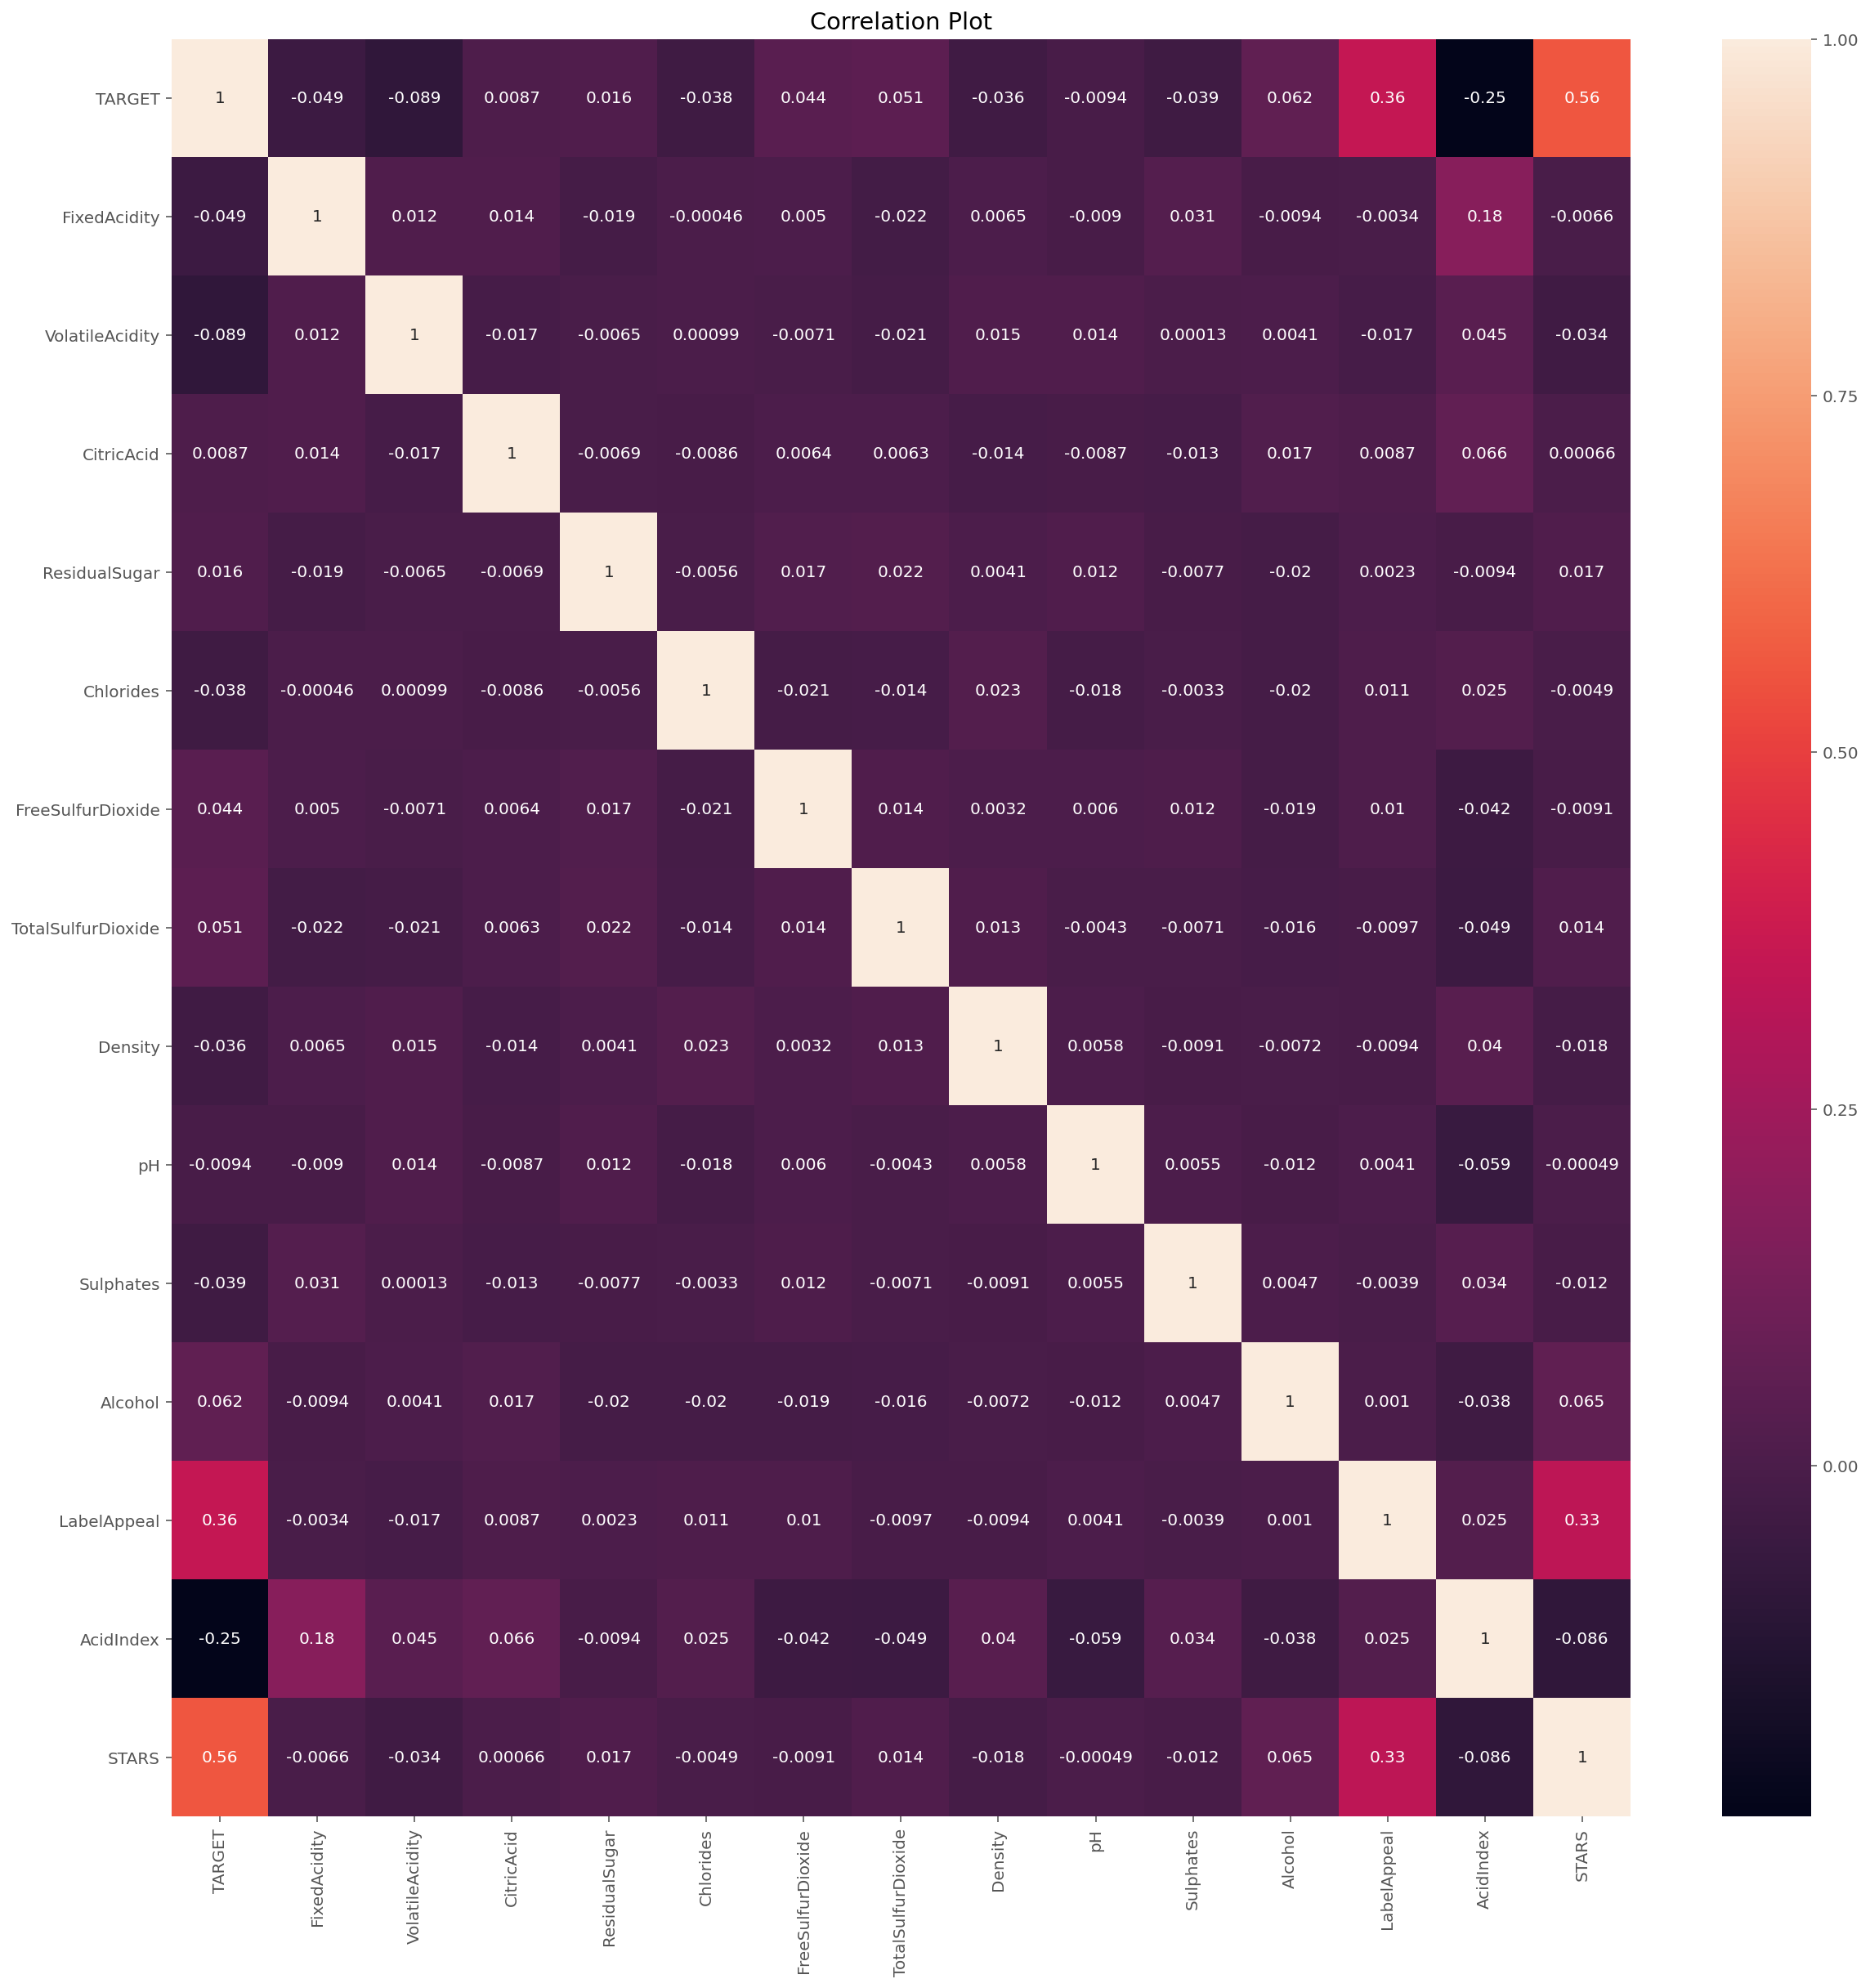

In [9]:
# initial correlation
cor = df.iloc[:,1:].corr()
plt.figure(figsize=(20,20))
plt.title("Correlation Plot")
sns.heatmap(cor,annot=True)
plt.show()

Initially, before making any data cleaning, we can see that STARS and LabelAppeal seem to have a positive association with the TARGET, however these are categorical variables as will review later in the analysis, so it can't be directly interpreted as a positive association.

In [10]:
#correlation with only positive values
df.iloc[:,1:].where(df.iloc[:,1:] >= 0).corr()

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS
TARGET,1.000000,-0.058918,-0.103090,0.019015,0.014160,-0.052800,0.047547,0.055484,-0.035518,-0.009445,-0.042531,0.065759,0.227353,-0.246049,0.558794
FixedAcidity,-0.058918,1.000000,0.006006,0.008846,-0.014012,-0.000611,-0.007070,-0.022086,0.005168,0.004921,0.032043,-0.005847,0.004044,0.193388,-0.025931
VolatileAcidity,-0.103090,0.006006,1.000000,-0.004005,0.008456,0.004167,-0.015759,-0.049595,0.000868,0.018652,0.008558,0.005018,-0.014975,0.055934,-0.042810
CitricAcid,0.019015,0.008846,-0.004005,1.000000,-0.016150,-0.004954,0.006028,0.020059,-0.015084,-0.005727,0.017214,0.003453,0.020074,0.068501,0.003561
ResidualSugar,0.014160,-0.014012,0.008456,-0.016150,1.000000,-0.019175,0.004078,0.037447,0.005136,0.011344,-0.007874,-0.022966,-0.003571,-0.021055,0.016184
Chlorides,-0.052800,-0.000611,0.004167,-0.004954,-0.019175,1.000000,-0.008532,-0.022753,0.021212,-0.000102,0.023453,-0.010209,-0.002799,0.044395,-0.001173
FreeSulfurDioxide,0.047547,-0.007070,-0.015759,0.006028,0.004078,-0.008532,1.000000,0.030824,0.004469,0.001167,0.001715,-0.019045,0.009271,-0.050122,-0.002211
TotalSulfurDioxide,0.055484,-0.022086,-0.049595,0.020059,0.037447,-0.022753,0.030824,1.000000,0.017765,0.007413,-0.018980,-0.040031,-0.004171,-0.058606,0.002739
Density,-0.035518,0.005168,0.000868,-0.015084,0.005136,0.021212,0.004469,0.017765,1.000000,0.005768,0.012659,-0.012027,0.006123,0.040413,-0.018284
pH,-0.009445,0.004921,0.018652,-0.005727,0.011344,-0.000102,0.001167,0.007413,0.005768,1.000000,0.018738,-0.007903,0.002687,-0.058676,-0.000488


This initial correlation between the explanatory variables with the response (TARGET), which excludes NA/null values, shows that the STARS variable has the largest number of null values and also the highest correlation with the response. This indicate that we should try to solve the null values issues within this variable, and one way could be to create an indicator feature called "no_stars".

In [11]:
# descriptive stats
df.describe()

,INDEX,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS
count,12795.000000,12795.000000,12795.000000,12795.000000,12795.000000,12179.000000,12157.000000,12148.000000,12113.000000,12795.000000,12400.000000,11585.000000,12142.000000,12795.000000,12795.000000,9436.000000
mean,8069.980305,3.029074,7.075717,0.324104,0.308413,5.418733,0.054822,30.845571,120.714233,0.994203,3.207628,0.527112,10.489236,-0.009066,7.772724,2.041755
std,4656.905107,1.926368,6.317643,0.784014,0.862080,33.749379,0.318467,148.714558,231.913211,0.026538,0.679687,0.932129,3.727819,0.891089,1.323926,0.902540
min,1.000000,0.000000,-18.100000,-2.790000,-3.240000,-127.800000,-1.171000,-555.000000,-823.000000,0.888090,0.480000,-3.130000,-4.700000,-2.000000,4.000000,1.000000
25%,4037.500000,2.000000,5.200000,0.130000,0.030000,-2.000000,-0.031000,0.000000,27.000000,0.987720,2.960000,0.280000,9.000000,-1.000000,7.000000,1.000000
50%,8110.000000,3.000000,6.900000,0.280000,0.310000,3.900000,0.046000,30.000000,123.000000,0.994490,3.200000,0.500000,10.400000,0.000000,8.000000,2.000000
75%,12106.500000,4.000000,9.500000,0.640000,0.580000,15.900000,0.153000,70.000000,208.000000,1.000515,3.470000,0.860000,12.400000,1.000000,8.000000,3.000000
max,16129.000000,8.000000,34.400000,3.680000,3.860000,141.150000,1.351000,623.000000,1057.000000,1.099240,6.130000,4.240000,26.500000,2.000000,17.000000,4.000000


According to this initial descriptive statistics we can see that there are several columns that contain negative numbers, like FixedAcidity, VolatileAcidity, ResidualSugar among others, and this is not a very good signal, since these are not attributes that would make sense to have values below zero. We will take a look closer at each attribute distribution to understand them better.

### Analyzing each attribute individually

In [12]:
# INDEX
# checking if there are duplicates, and there aren't
df[df.INDEX.duplicated()]

,INDEX,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS


This attribute does not provide any meaningful information to a machine learning model, hence it does not require any further analysis.

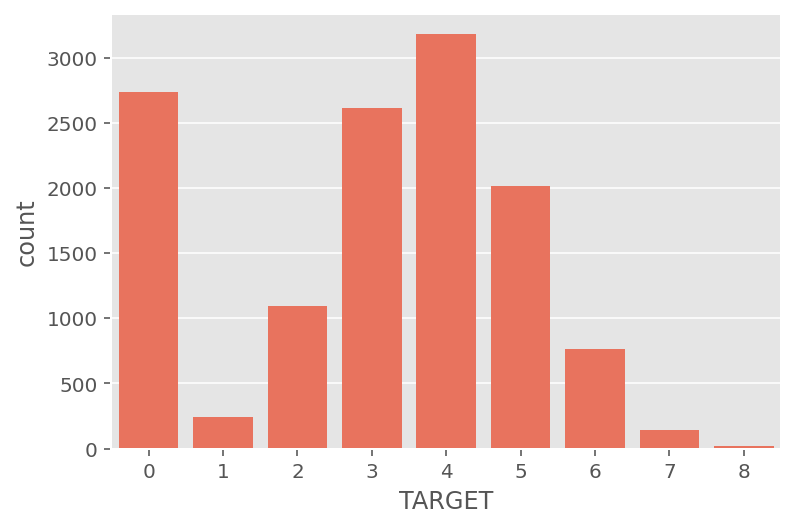

In [13]:
# Target.
sns.countplot(x="TARGET",data=df, color='tomato');

We can see that there are more than 2500 records with a target of 0,3 and 4 whereas very few wines with a target of 8. It is interesting to see the high number of the wines that have a TARGET of zero, meaning that not even a single unit was sold.

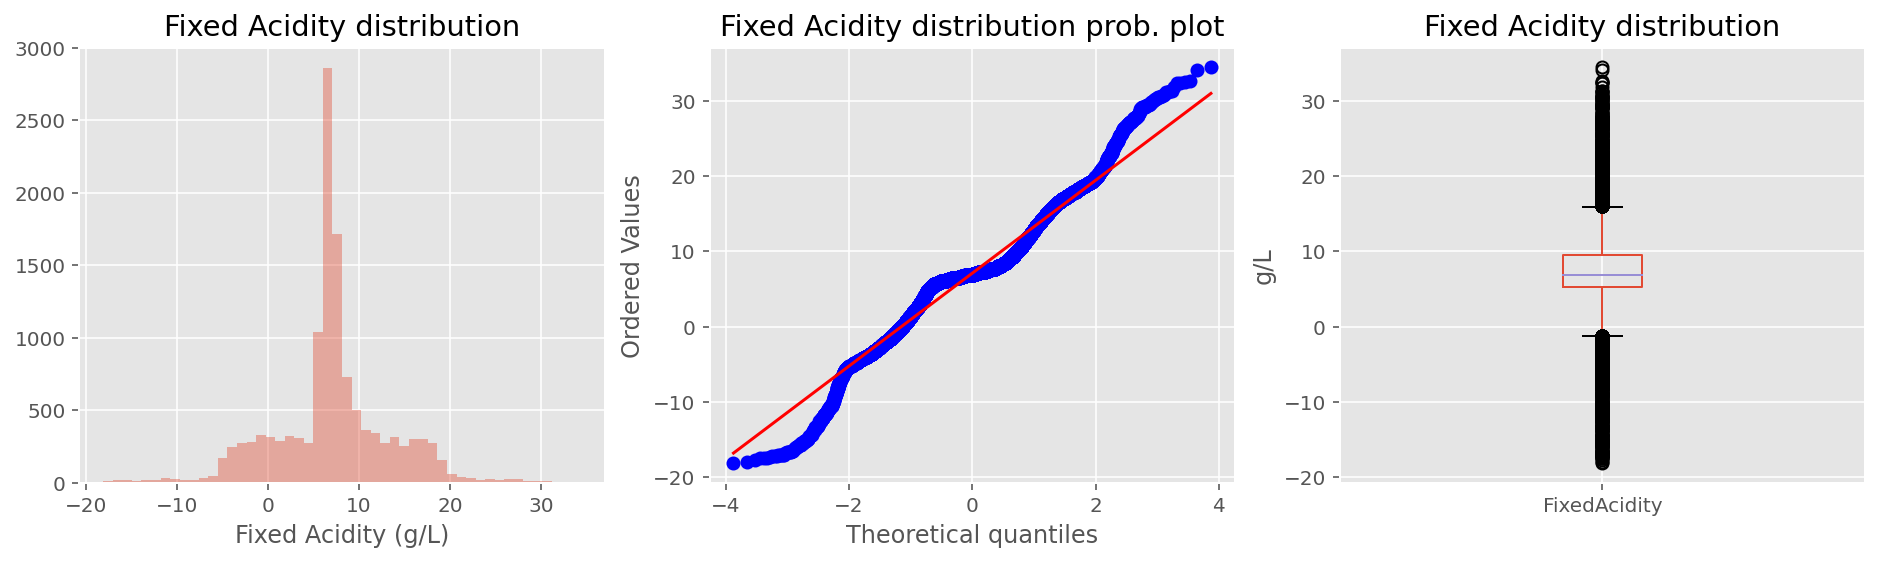

In [14]:
investigate("FixedAcidity", "Fixed Acidity distribution", 'Fixed Acidity (g/L)', 'g/L')

In [15]:
df[df.FixedAcidity>30].TARGET.value_counts()

4    8
0    5
3    4
5    3
2    1
Name: TARGET, dtype: int64

We can see that the mean Fixed Acidity within the records is around 7 (g/L) and it could be considered a nearly normal distribution. Doing some research it seems that the predominant fixed acids found in wines are: tartaric, malic, citric, and succinic.  Their respective levels found in wine can vary greatly but in general one would expect to see 1,000 to 4,000 mg/L tartaric acid, 0 to 8,000 mg/L malic acid, 0 to 500 mg/L citric acid, and 500 to 2,000 mg/L succinic acid. 

Given the nature of this data we conclude that we can't have negative values, indicating some error at the time the data was created/collected. This feature will need to be transformed to only have positive values.

[1]

The boxplot show that the upper whisker extends up to around 17 which seems to be tentative limit value for this attribute. All values higher than that can be considered as outliers.

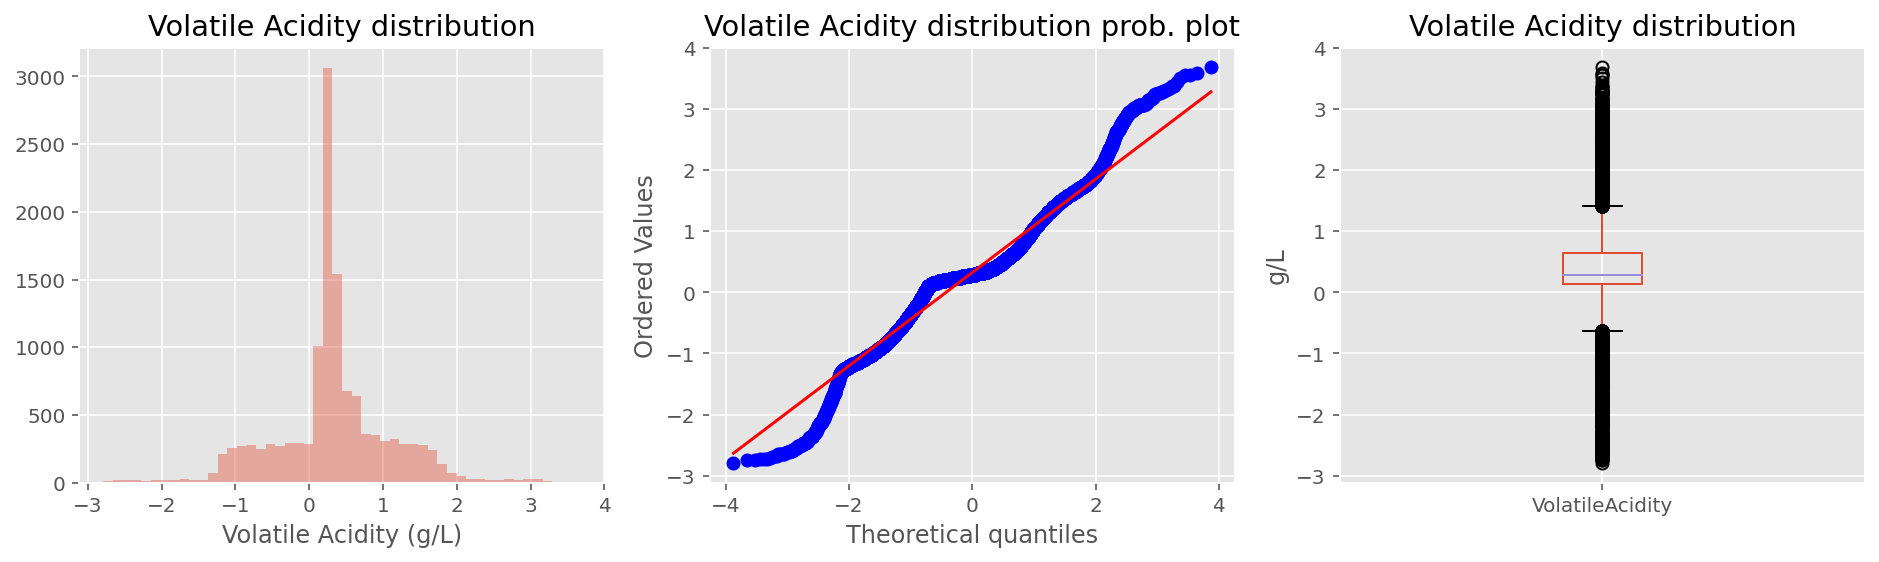

In [16]:
investigate("VolatileAcidity", "Volatile Acidity distribution", 'Volatile Acidity (g/L)', 'g/L')

Here, there is a similar scenario as the previous one. Given the nature of this data we can't have negative values, indicating some error at the time the data was created/collected. This feature will need to be transformed to only have positive values. According to the article below, in the US there are limits for the amount of Volatile Acidity, which is for Red Wine 1.2 g/L, and for White Wine 1.1 g/L

[2]

The boxplot show that the upper whisker extends up to around 1.5 which seems to be tentative limit value for this attribute. All values higher than that can be considered as outliers.

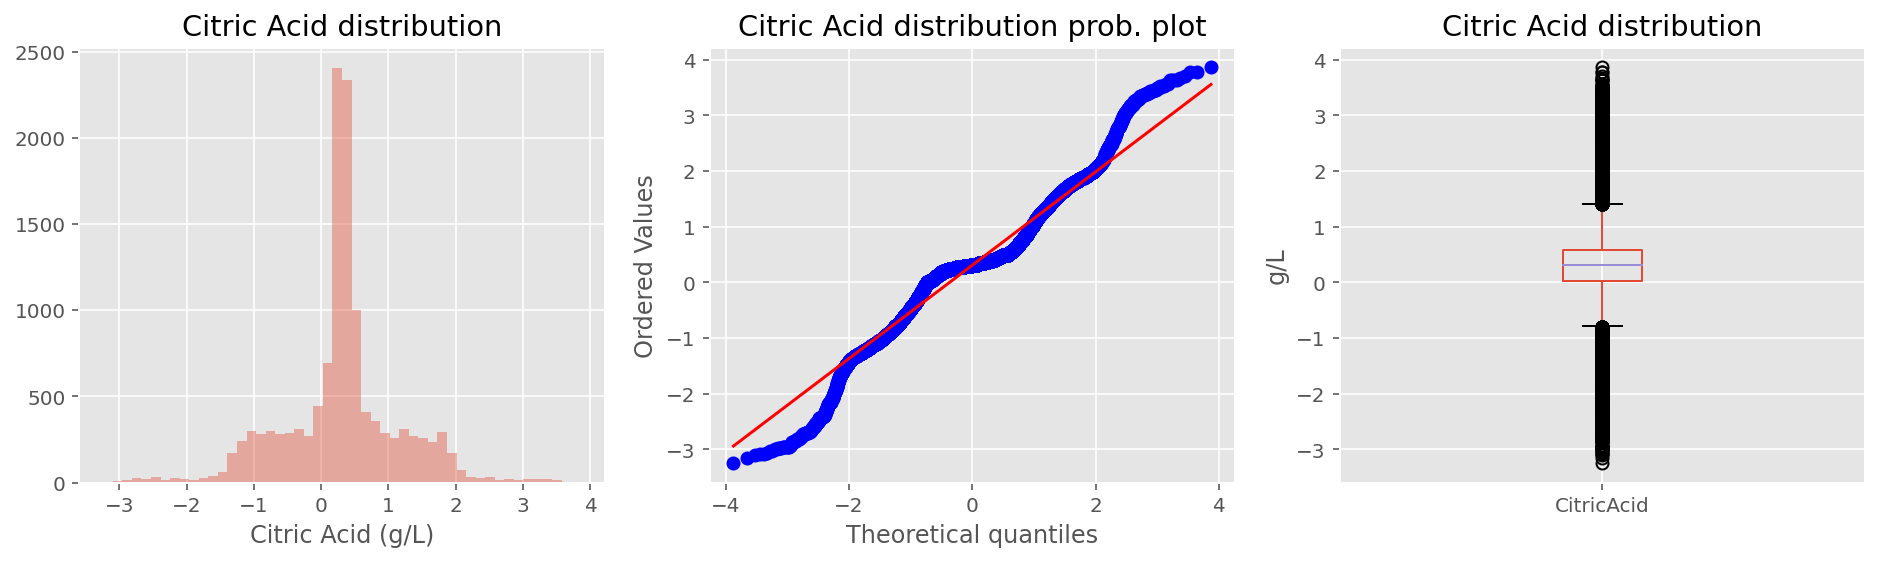

In [17]:
investigate("CitricAcid", "Citric Acid distribution", 'Citric Acid (g/L)', 'g/L')

Again there is a similar scenario as the previous one. Given the nature of this data we can't have negative values, indicating some error at the time the data was created/collected. This feature will need to be transformed, so that it only has positive values. <br>
According to the article below we can consider that above 1 g/L can be considered that it has reached the Maximum Acceptable Limits according to the International Code of Oenological Practices.
[3]

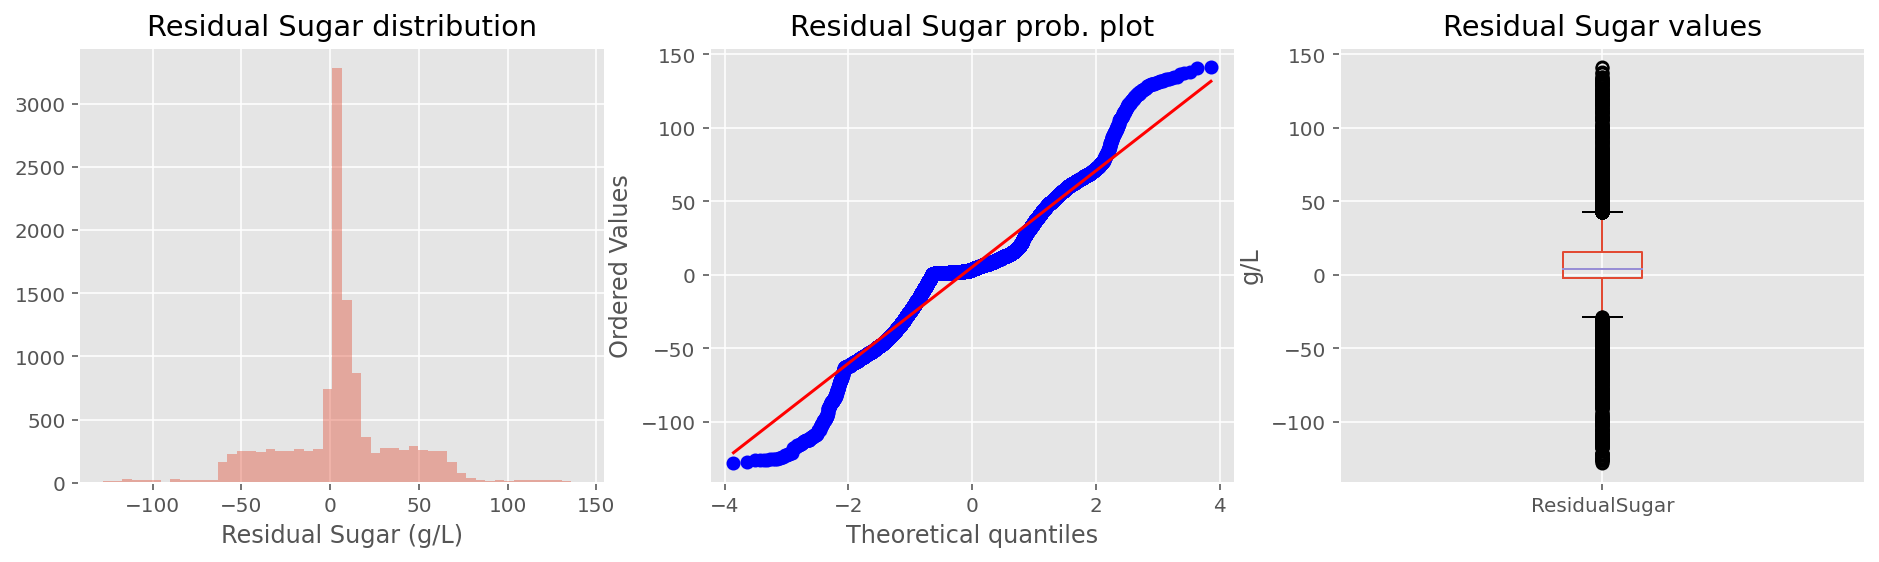

In [18]:
#ResidualSugar, getting the non null values for ResidualSugar column, (4.8% of the values)
sugar_notna = df[df['ResidualSugar'].notnull()]['ResidualSugar']

#showing distribution and probability plot
fig = plt.figure(figsize=(16,4))
plt.subplot(1, 3, 1)
sns.distplot(sugar_notna, kde=False);
plt.title("Residual Sugar distribution");
plt.xlabel('Residual Sugar (g/L)')

plt.subplot(1, 3, 2)
probplot(sugar_notna, plot = plt);
plt.title("Residual Sugar prob. plot");

plt.subplot(1, 3, 3)
plt.ylabel('g/L')
df.boxplot(column='ResidualSugar');
plt.title("Residual Sugar values");

Given the nature of this data we can't have negative values, indicating some error at the time the data was created/collected. This feature will need to be transformed, so that it only has positive values.

[4].

Residual Sugar (or RS) is from natural grape sugars leftover in a wine after the alcoholic fermentation finishes. Residual sugar levels vary in different types of wine. In fact, many grocery store wines labeled as “dry” contain about 10 g/L of residual sugar. Noticeably sweet wines start at around 35 grams per liter of residual sugar and then go up from there. <br>
__Wines range from 0–220 grams per liter sugar (g/L)__, depending on the style [5] so this means that values above 40 g/L does not mean that it is invalid data.

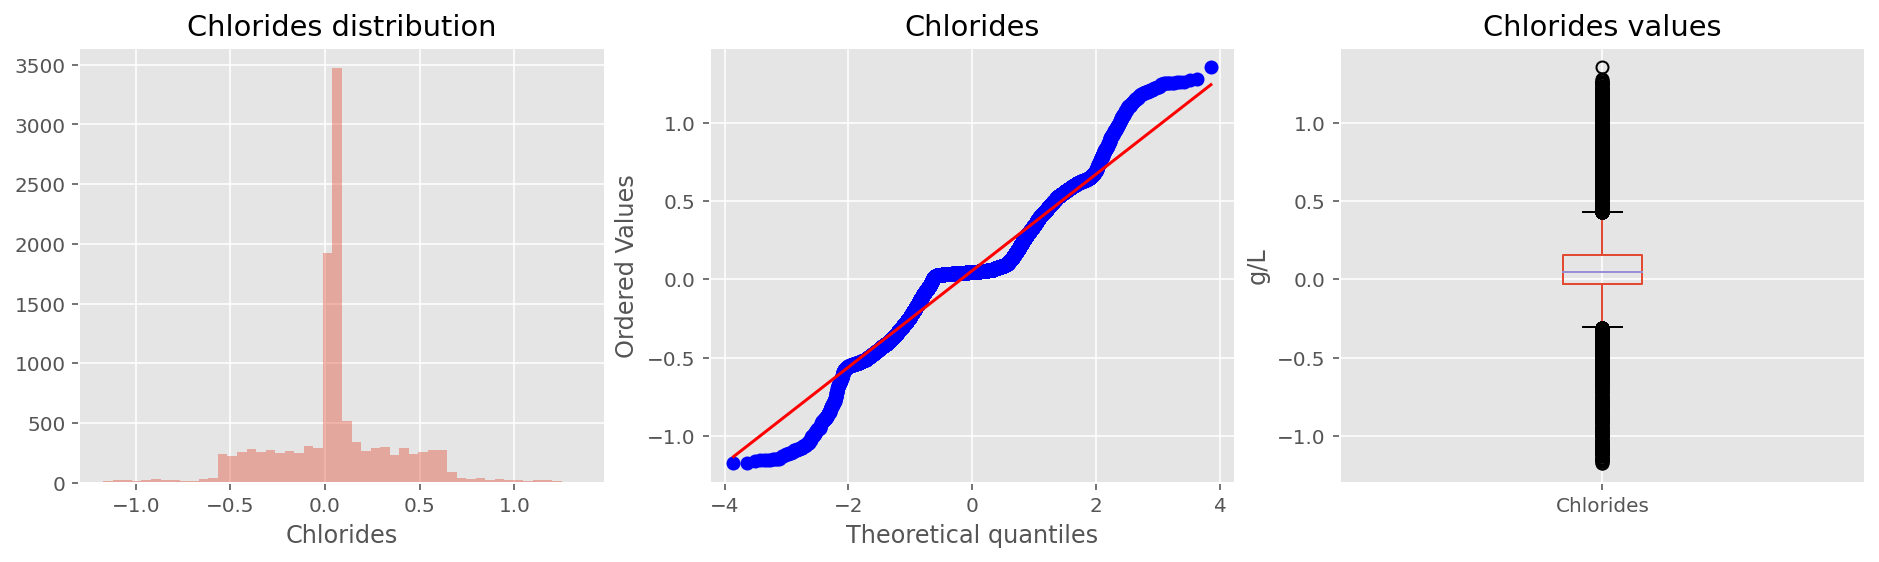

In [19]:
#Chlorides, getting the non null values (4.98% of the values)
chlorides_notna=df[df['Chlorides'].notnull()]['Chlorides']

#showing distribution and probability plot
fig = plt.figure(figsize=(16,4))
plt.subplot(1, 3, 1)
sns.distplot(chlorides_notna, kde=False);
plt.title("Chlorides distribution");
plt.xlabel('Chlorides')

plt.subplot(1, 3, 2)
probplot(chlorides_notna, plot = plt);
plt.title("Chlorides");

plt.subplot(1, 3, 3)
plt.ylabel('g/L')
df.boxplot(column ='Chlorides');
plt.title("Chlorides values");

Given the nature of this data we can't have negative values, indicating some error at the time the data was created/collected. This feature will need to be transformed, so that it only has positive values. Maximum values are around 1g/L. [6] 

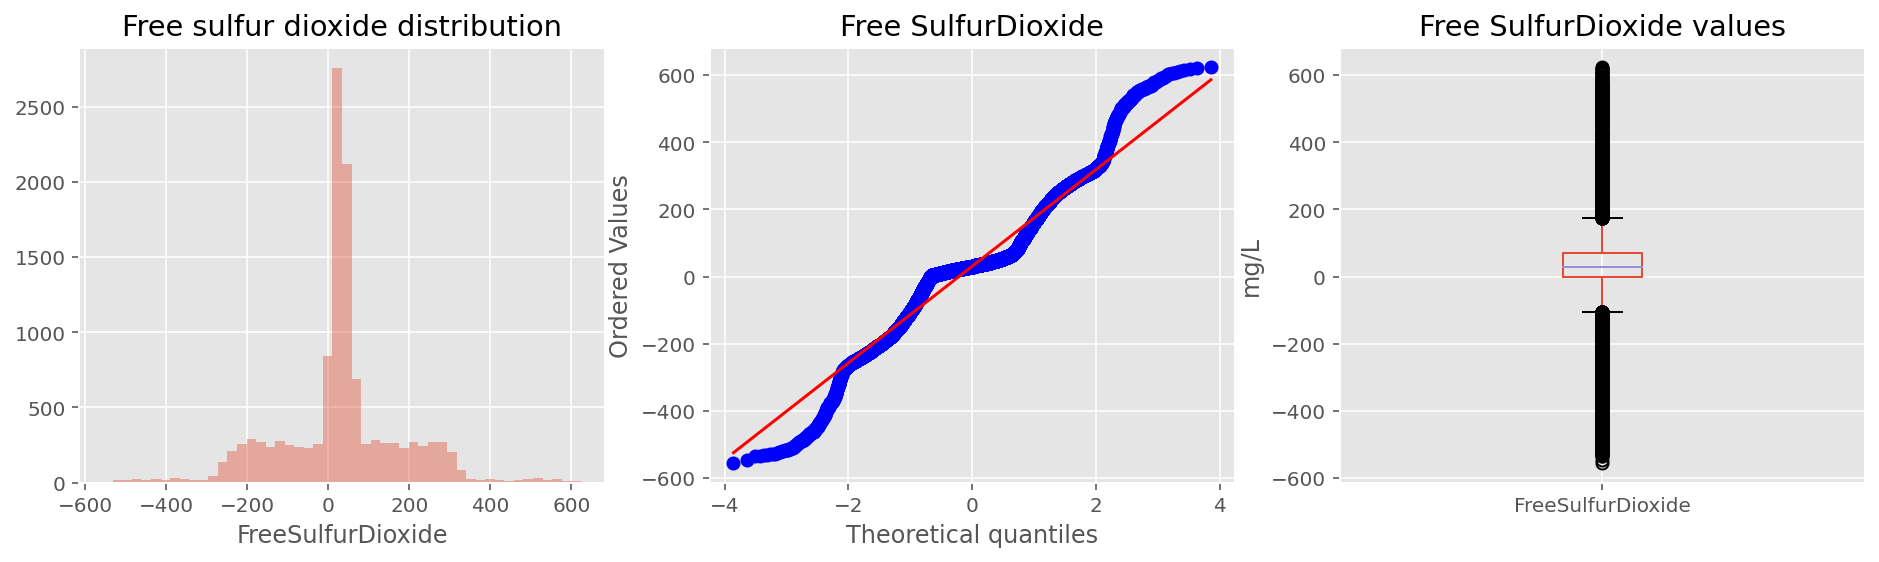

In [20]:
#FreeSulfurDioxide, getting the non null values (5.05% of the values)
freeSulfurDioxide_notna=df[df['FreeSulfurDioxide'].notnull()]['FreeSulfurDioxide']

#showing distribution and probability plot
fig = plt.figure(figsize=(16,4))
plt.subplot(1, 3, 1)
sns.distplot(freeSulfurDioxide_notna, kde=False);
plt.title("Free sulfur dioxide distribution");
plt.xlabel('FreeSulfurDioxide')

plt.subplot(1, 3, 2)
probplot(freeSulfurDioxide_notna, plot = plt);
plt.title("Free SulfurDioxide");

plt.subplot(1, 3, 3)
plt.ylabel('mg/L')
df.boxplot(column='FreeSulfurDioxide');
plt.title("Free SulfurDioxide values");

Given the nature of this data we can't have negative values, indicating some error at the time the data was created/collected. This feature will need to be transformed, so that it only has positive values. Above 200 mg/L might be considered outliers. <br>
[7]

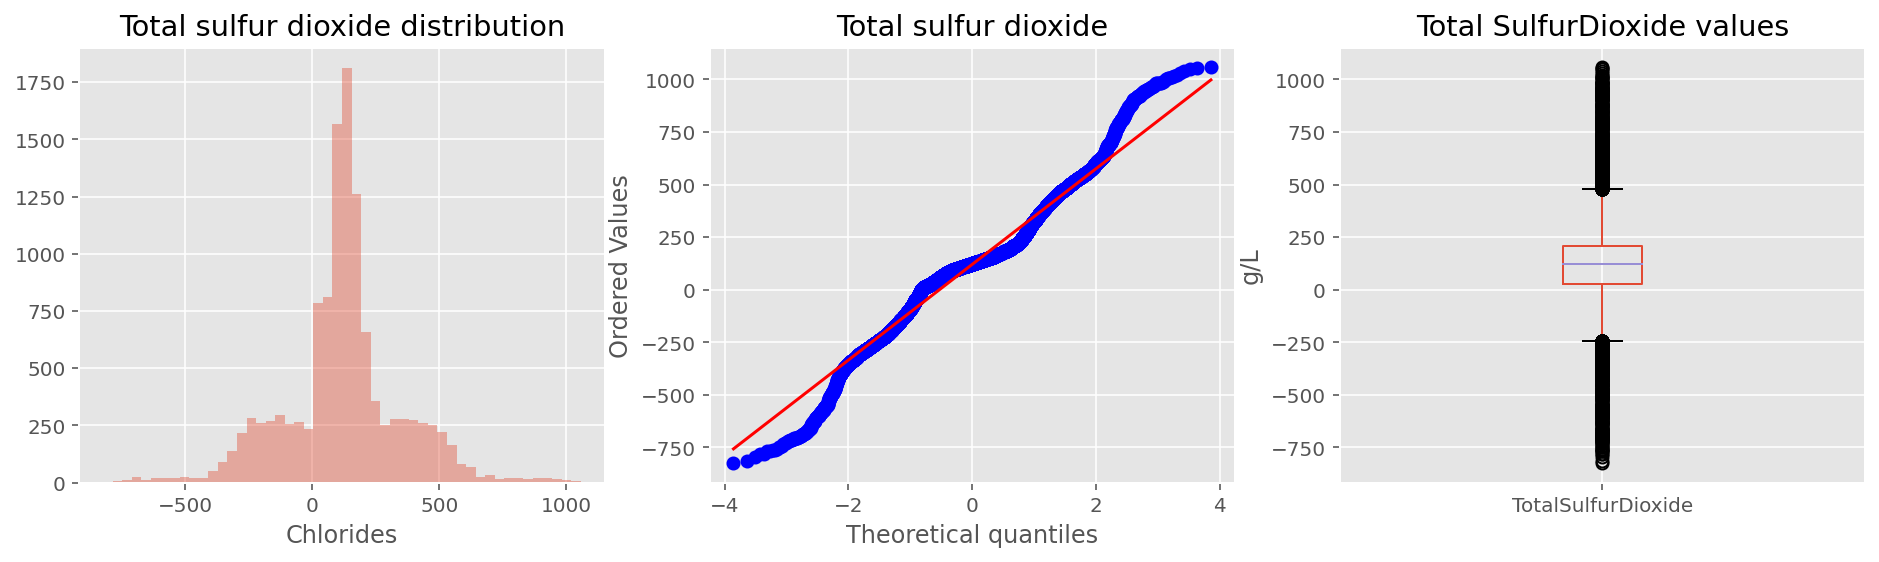

In [21]:
#TotalSulfurDioxide, getting the non null values (5.3% of the values)
totalSulfurDioxide_notna=df[df['TotalSulfurDioxide'].notnull()]['TotalSulfurDioxide']

#showing distribution and probability plot
fig = plt.figure(figsize=(16,4))
plt.subplot(1, 3, 1)
sns.distplot(totalSulfurDioxide_notna, kde=False);
plt.title("Total sulfur dioxide distribution");
plt.xlabel('Chlorides')

plt.subplot(1, 3, 2)
probplot(totalSulfurDioxide_notna, plot = plt);
plt.title("Total sulfur dioxide");

plt.subplot(1, 3, 3)
plt.ylabel('g/L')
df.boxplot(column='TotalSulfurDioxide');
plt.title("Total SulfurDioxide values");

The main preservative used in wine is sulphur dioxide, which you’ll see on the label as ‘preservative 220’, ‘minimal sulphur dioxide added’ or ‘contains sulphites’. Sulphur dioxide is added in the winemaking process to protect the wine from oxidation and bacterial spoilage [8].

Given the nature of this data we can't have negative values, indicating some error at the time the data was created/collected. This feature will need to be transformed, so that it only has positive values.

According to the limits in the link below, it seems reasonable to consider values above 500 mg/l as outliers [9].


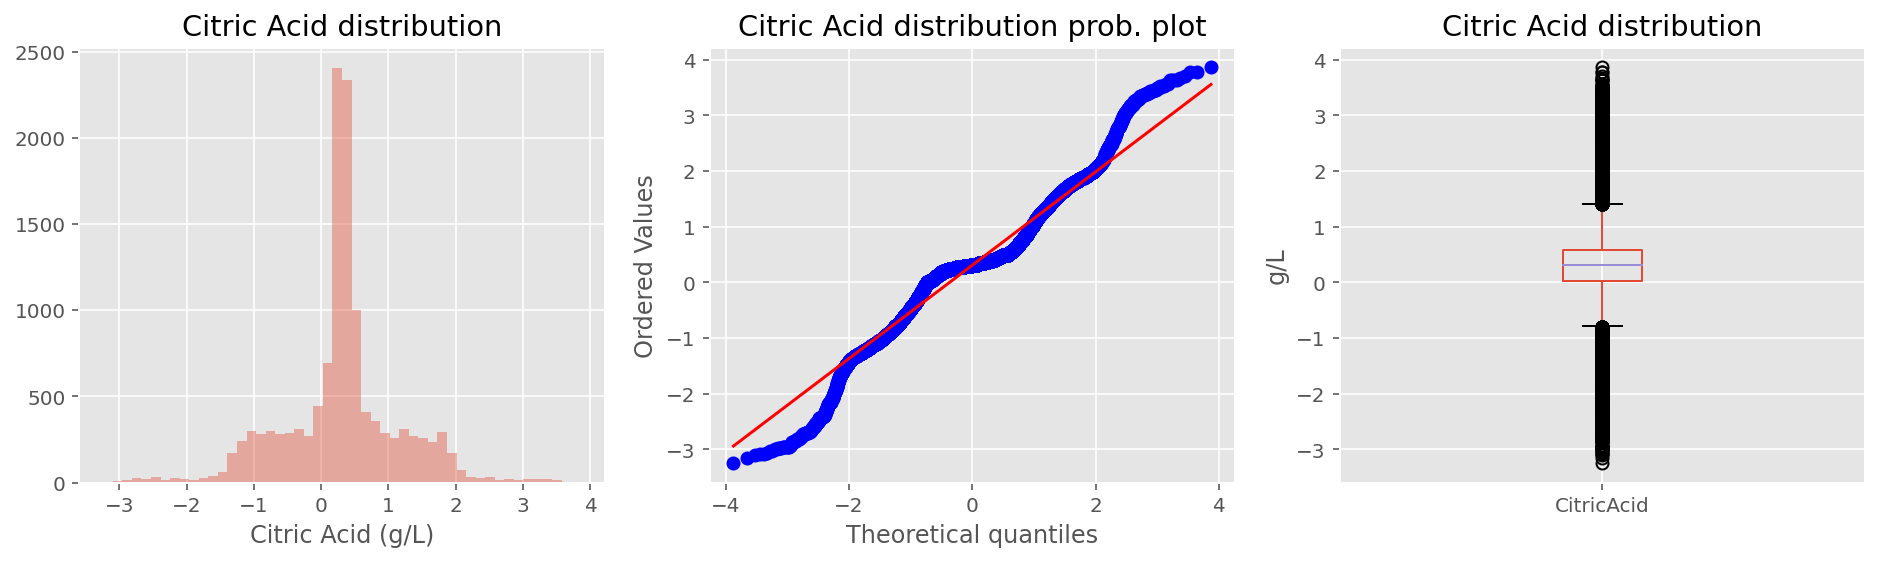

In [22]:
investigate("CitricAcid", "Citric Acid distribution", 'Citric Acid (g/L)', 'g/L')

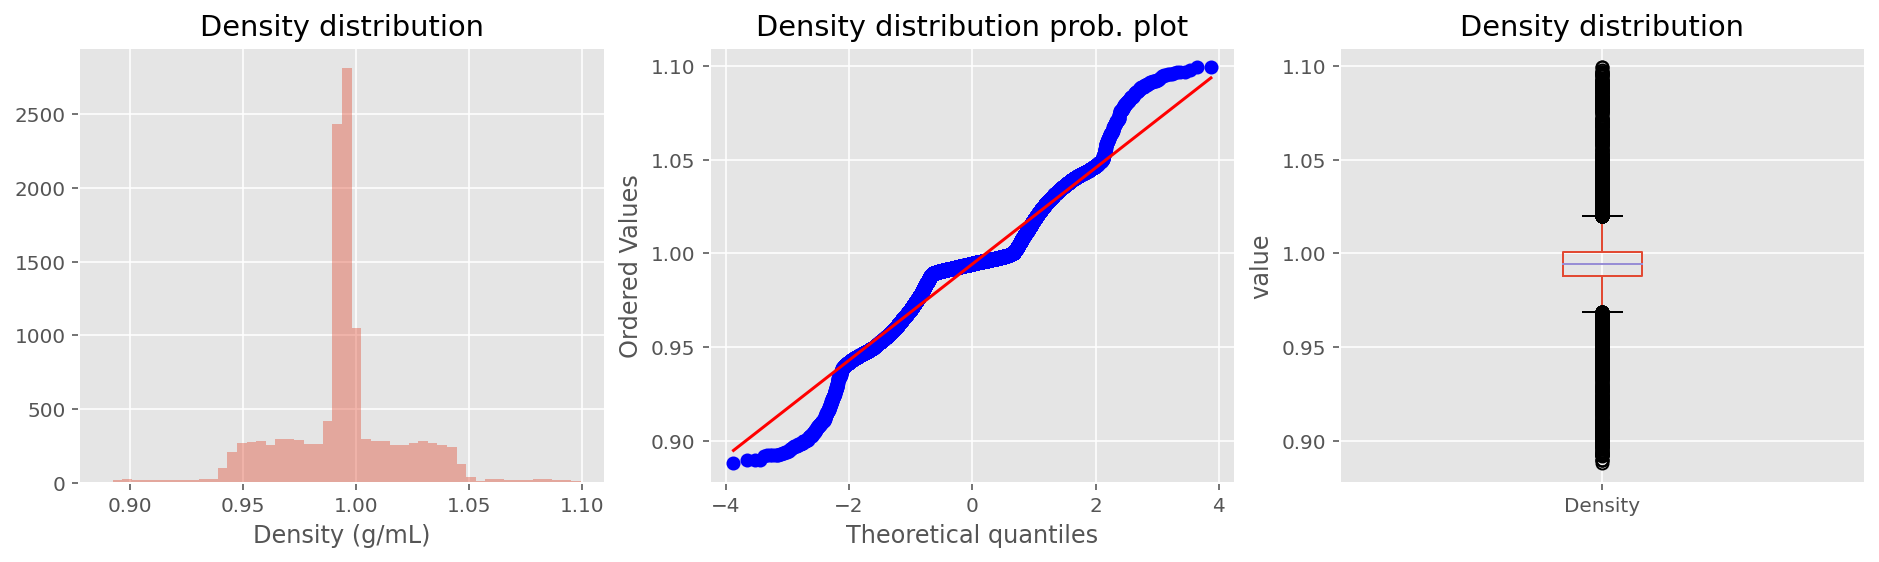

In [23]:
#Density, there are no null values
#showing distribution and probability plot
investigate("Density", "Density distribution", 'Density (g/mL)', 'value')

Density is defined as mass per volume. In wine, we report density as grams / milliliter (g/mL). When we take a deeper look at the components of wine, the main constituents affecting the density are alcohol, sugar, glycerol, and other dissolved solids.

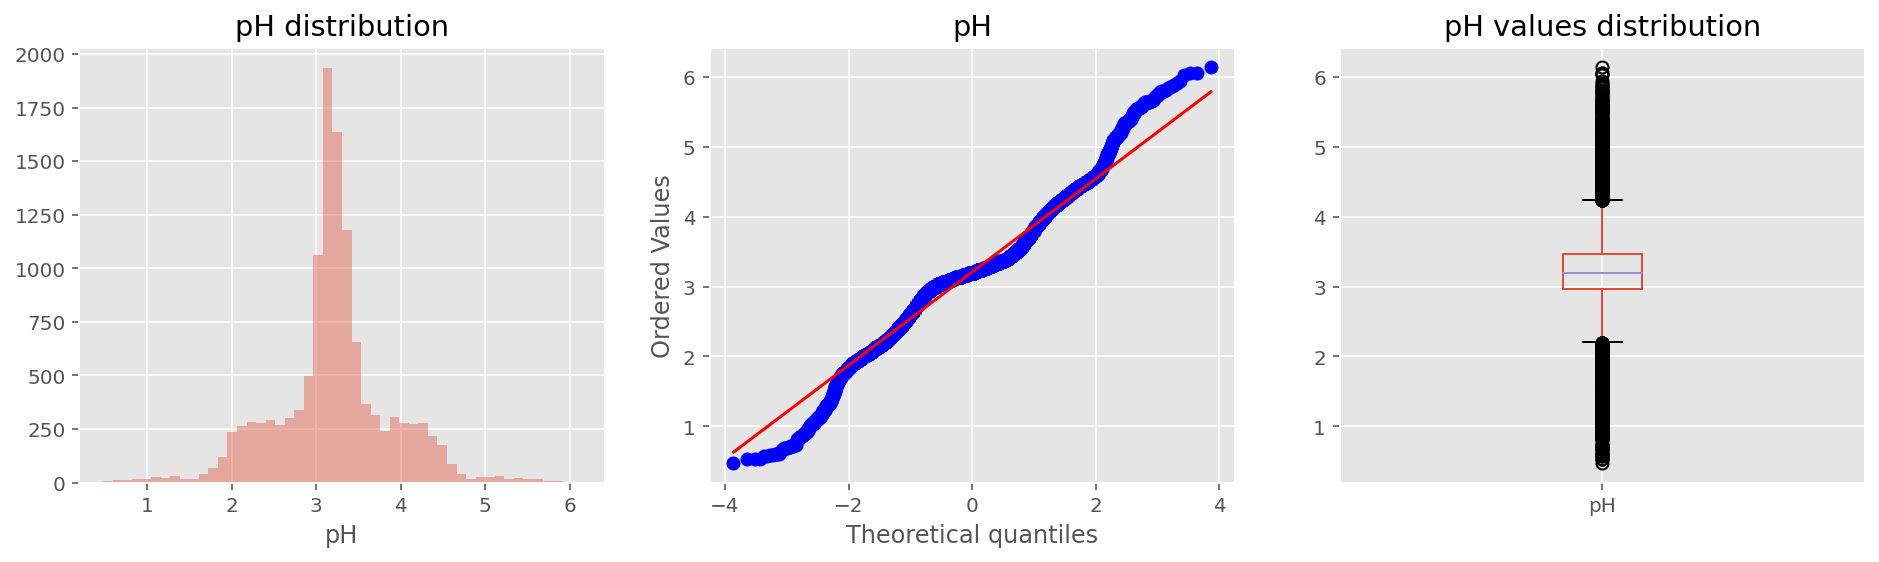

In [24]:
#pH, getting the non null values (3.08% of the values)
pH_notna=df[df['pH'].notnull()]['pH']

#showing distribution and probability plot
fig = plt.figure(figsize=(16,4))
plt.subplot(1, 3, 1)
sns.distplot(pH_notna, kde=False);
plt.title("pH distribution");
plt.xlabel('pH')

plt.subplot(1, 3, 2)
probplot(pH_notna, plot = plt);
plt.title("pH");

plt.subplot(1, 3, 3)
df.boxplot(column='pH');
plt.title("pH values distribution");

According to the url below all wines lie on the acidic side of the pH spectrum, and most range from 2.5 to about 4.5 pH (7 is neutral). Meaning the whisker plots in the boxplot show a reasonable assumption of valid values, which would mean to remove the outliers.
[10]

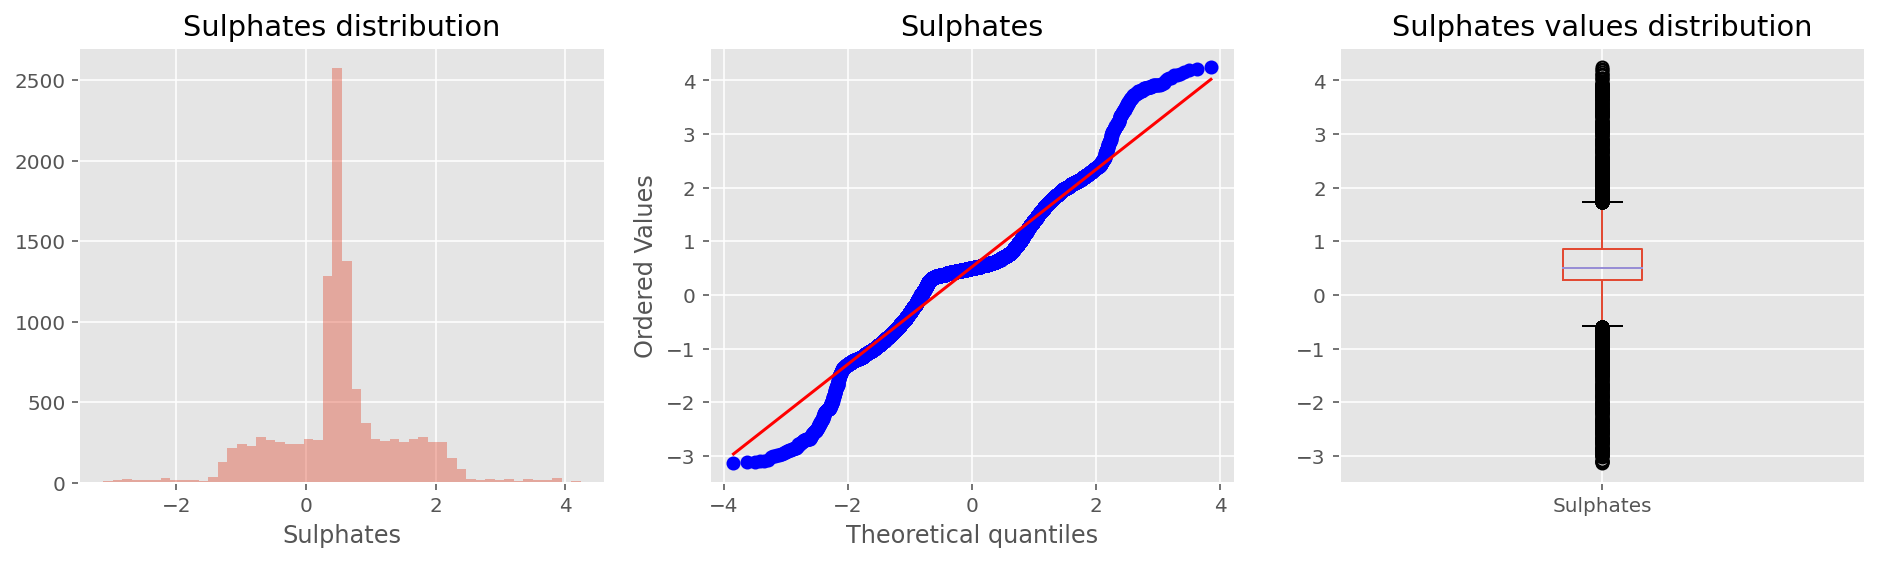

In [25]:
#Sulphates, getting the non null values (9.45% of the values)
sulphates_notna=df[df['Sulphates'].notnull()]['Sulphates']

#showing distribution and probability plot
fig = plt.figure(figsize=(16,4))
plt.subplot(1, 3, 1)
sns.distplot(sulphates_notna, kde=False);
plt.title("Sulphates distribution");
plt.xlabel('Sulphates')

plt.subplot(1, 3, 2)
probplot(sulphates_notna, plot = plt);
plt.title("Sulphates");

plt.subplot(1, 3, 3)
df.boxplot(column='Sulphates');
plt.title("Sulphates values distribution");

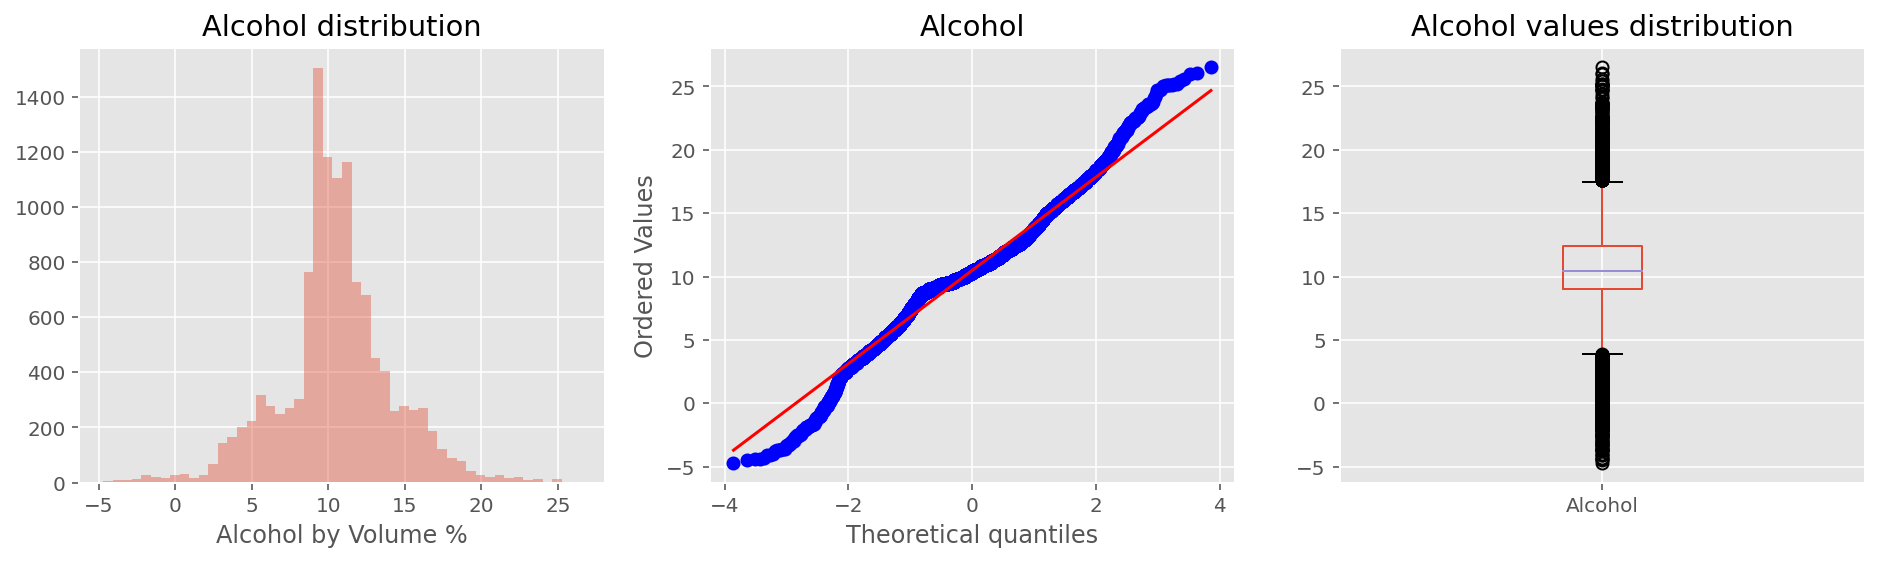

In [26]:
#Alcohol, getting the non null values (5.1% of the values)
alcohol_notna=df[df['Alcohol'].notnull()]['Alcohol']

#showing distribution and probability plot
fig = plt.figure(figsize=(16,4))
plt.subplot(1, 3, 1)
sns.distplot(alcohol_notna, kde=False);
plt.title("Alcohol distribution");
plt.xlabel('Alcohol by Volume %')

plt.subplot(1, 3, 2)
probplot(alcohol_notna, plot = plt);
plt.title("Alcohol");

plt.subplot(1, 3, 3)
df.boxplot(column='Alcohol');
plt.title("Alcohol values distribution");

We can see some negative values that will need to be deleted/changed as well as some outliers, since according to the article below, wines bottles range from as little as 5% alcohol by volume to as much as around 21% ABV (Alcohol By Volume) [10].

Here it seems that the subjective marketing score, that indicates the appeal of the design of the label on the bottle, shows a high number of negative values, which does not necessarily mean that these are invalid, rather it would likely indicate a negative appealing on the bottle label design. <br> The only transformation that this attribute will require is to get dummy variables.

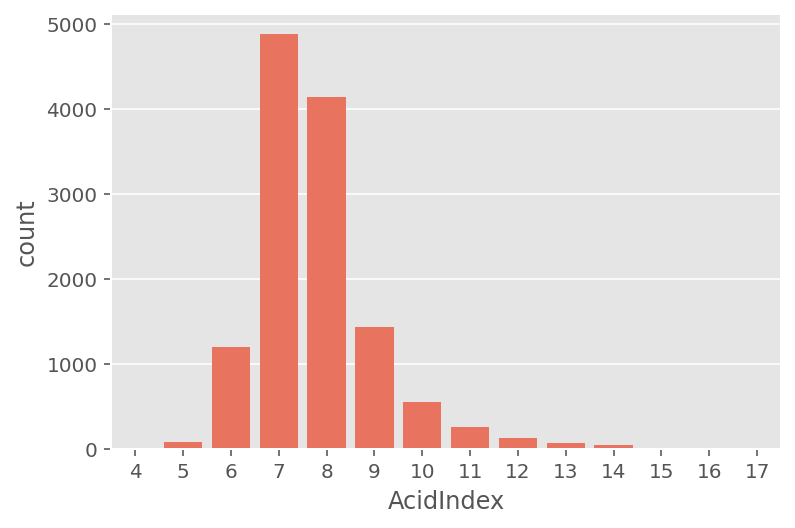

In [27]:
#AcidIndex, there are no null values
sns.countplot(x="AcidIndex",data=df, color='tomato');

We can see that this values ranges from 4 up to 17, with the majority number of records with an AcidIndex between 6 and 9. We know that this attribute measures total acidity of wine via a weighted average, but there is no much information about how this index was generated, so to allow a better analysis, and avoid overfitting, we can combine values/spare classes. For example:
- 4 =< AcidIndex < 7 => AcidIndex_low
- 7 =< AcidIndex < 10 => AcidIndex_medium
- 10 =< AcidIndex => AcidIndex_high

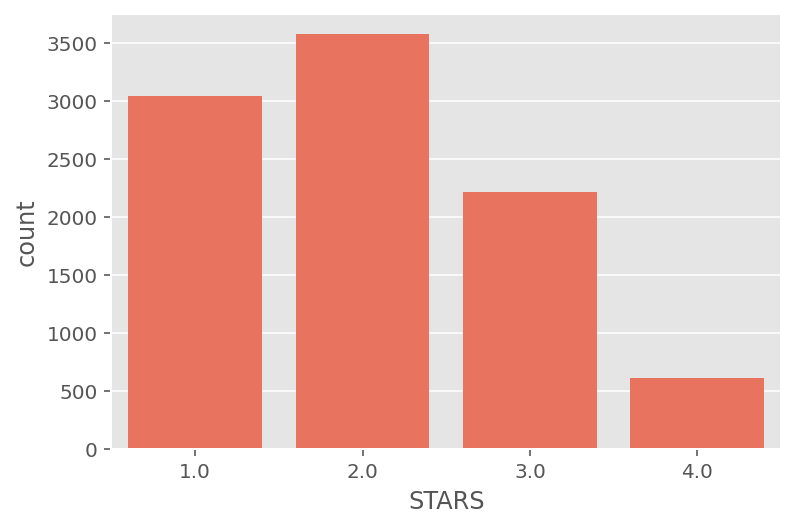

In [28]:
#STARS, (26.2% of the values are null)
sns.countplot(x="STARS",data=df, color='tomato');

STARS represents wine rating as determined by experts (4 = excellent; 1 = Poor), and it has around 26.2% of missing values, and considering this might provide good predictive power to the response, we can transform missing values into a dummy variable as below:
- STARS = null => Rating_notreviewed

This will allow to isolate the impact of each specific STAR level in a machine learning model.

## Data Preparation

### Changes to the LabelAppeal

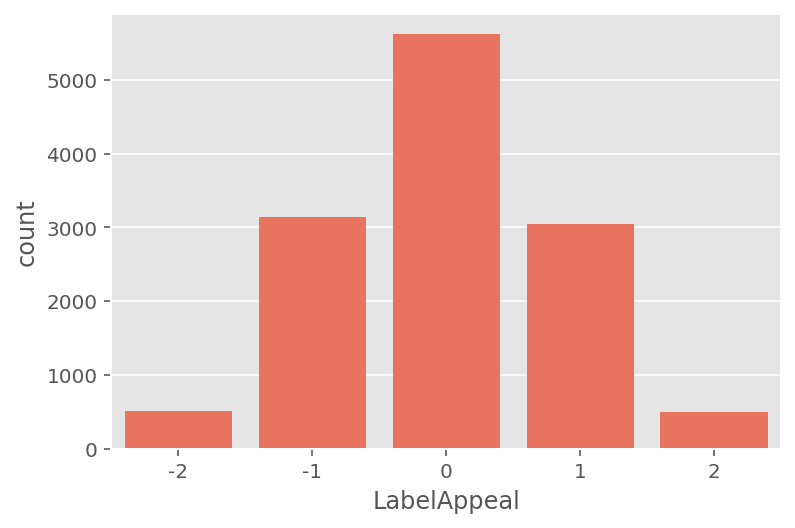

In [29]:
#LabelAppeal_ Before
sns.countplot(x="LabelAppeal",data = df, color='tomato');
plt.show();

In [30]:
# Adding 2 to the entire column set
df["LabelAppeal"] = df["LabelAppeal"] + 2

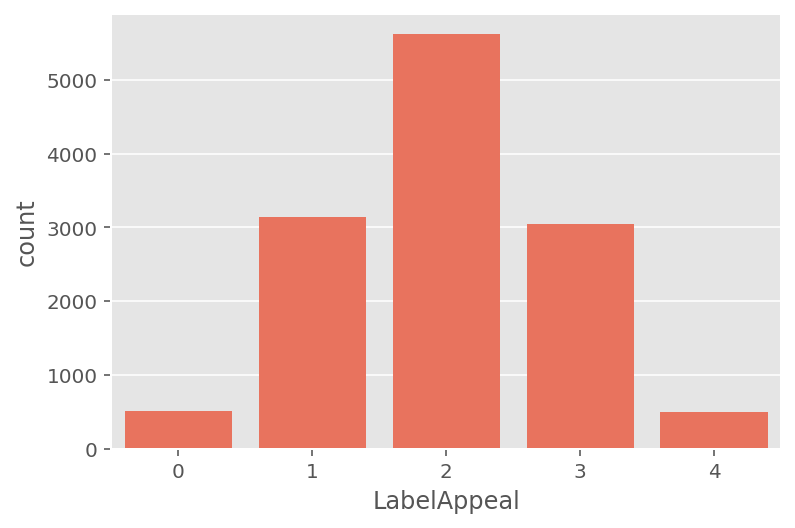

In [31]:
#LabelAppeal_ After
sns.countplot(x="LabelAppeal",data=df, color='tomato');
plt.show();

We decided to add 2 to the label appeal because we do not want to have negative values in our dataset because the models we intend to use do not work well with negative values and since this is categorical of the type ordinal we needed to add 2 to each of the five levels to maintain the logic that was present before to the addition, furthermore we believe that it makes more sense for label to have the appeals as positive values for the sake of interpretability.

### Getting the absoulte value

In [32]:
# Keep a version of it before applying the absolute value.
df_neg = df.copy()

In [33]:
df.STARS.isnull().sum()

3359

In [34]:
#get absolute values
df = df.loc[:, df.columns != 'INDEX'].abs()
df.head(3)

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS
0,3.0,3.2,1.16,0.98,54.2,0.567,NaN,268.0,0.99280,3.33,0.59,9.9,2.0,8.0,2.0
1,3.0,4.5,0.16,0.81,26.1,0.425,15.0,327.0,1.02792,3.38,0.70,NaN,1.0,7.0,3.0
2,5.0,7.1,2.64,0.88,14.8,0.037,214.0,142.0,0.99518,3.12,0.48,22.0,1.0,8.0,3.0


As we saw in EDA section there are several attributes with negative values, and based on the research we conclude that we need to replace them. If we assume that there was an error in the data entry, we can use the absolute value to replace negative by positive. <br>
Below it is a dataframe that summaries the number of negatives as well as null values in each column.

Below are all columns except for LabelAppeal before they have been transformed with absolute values:

***Before applying the absolute value***

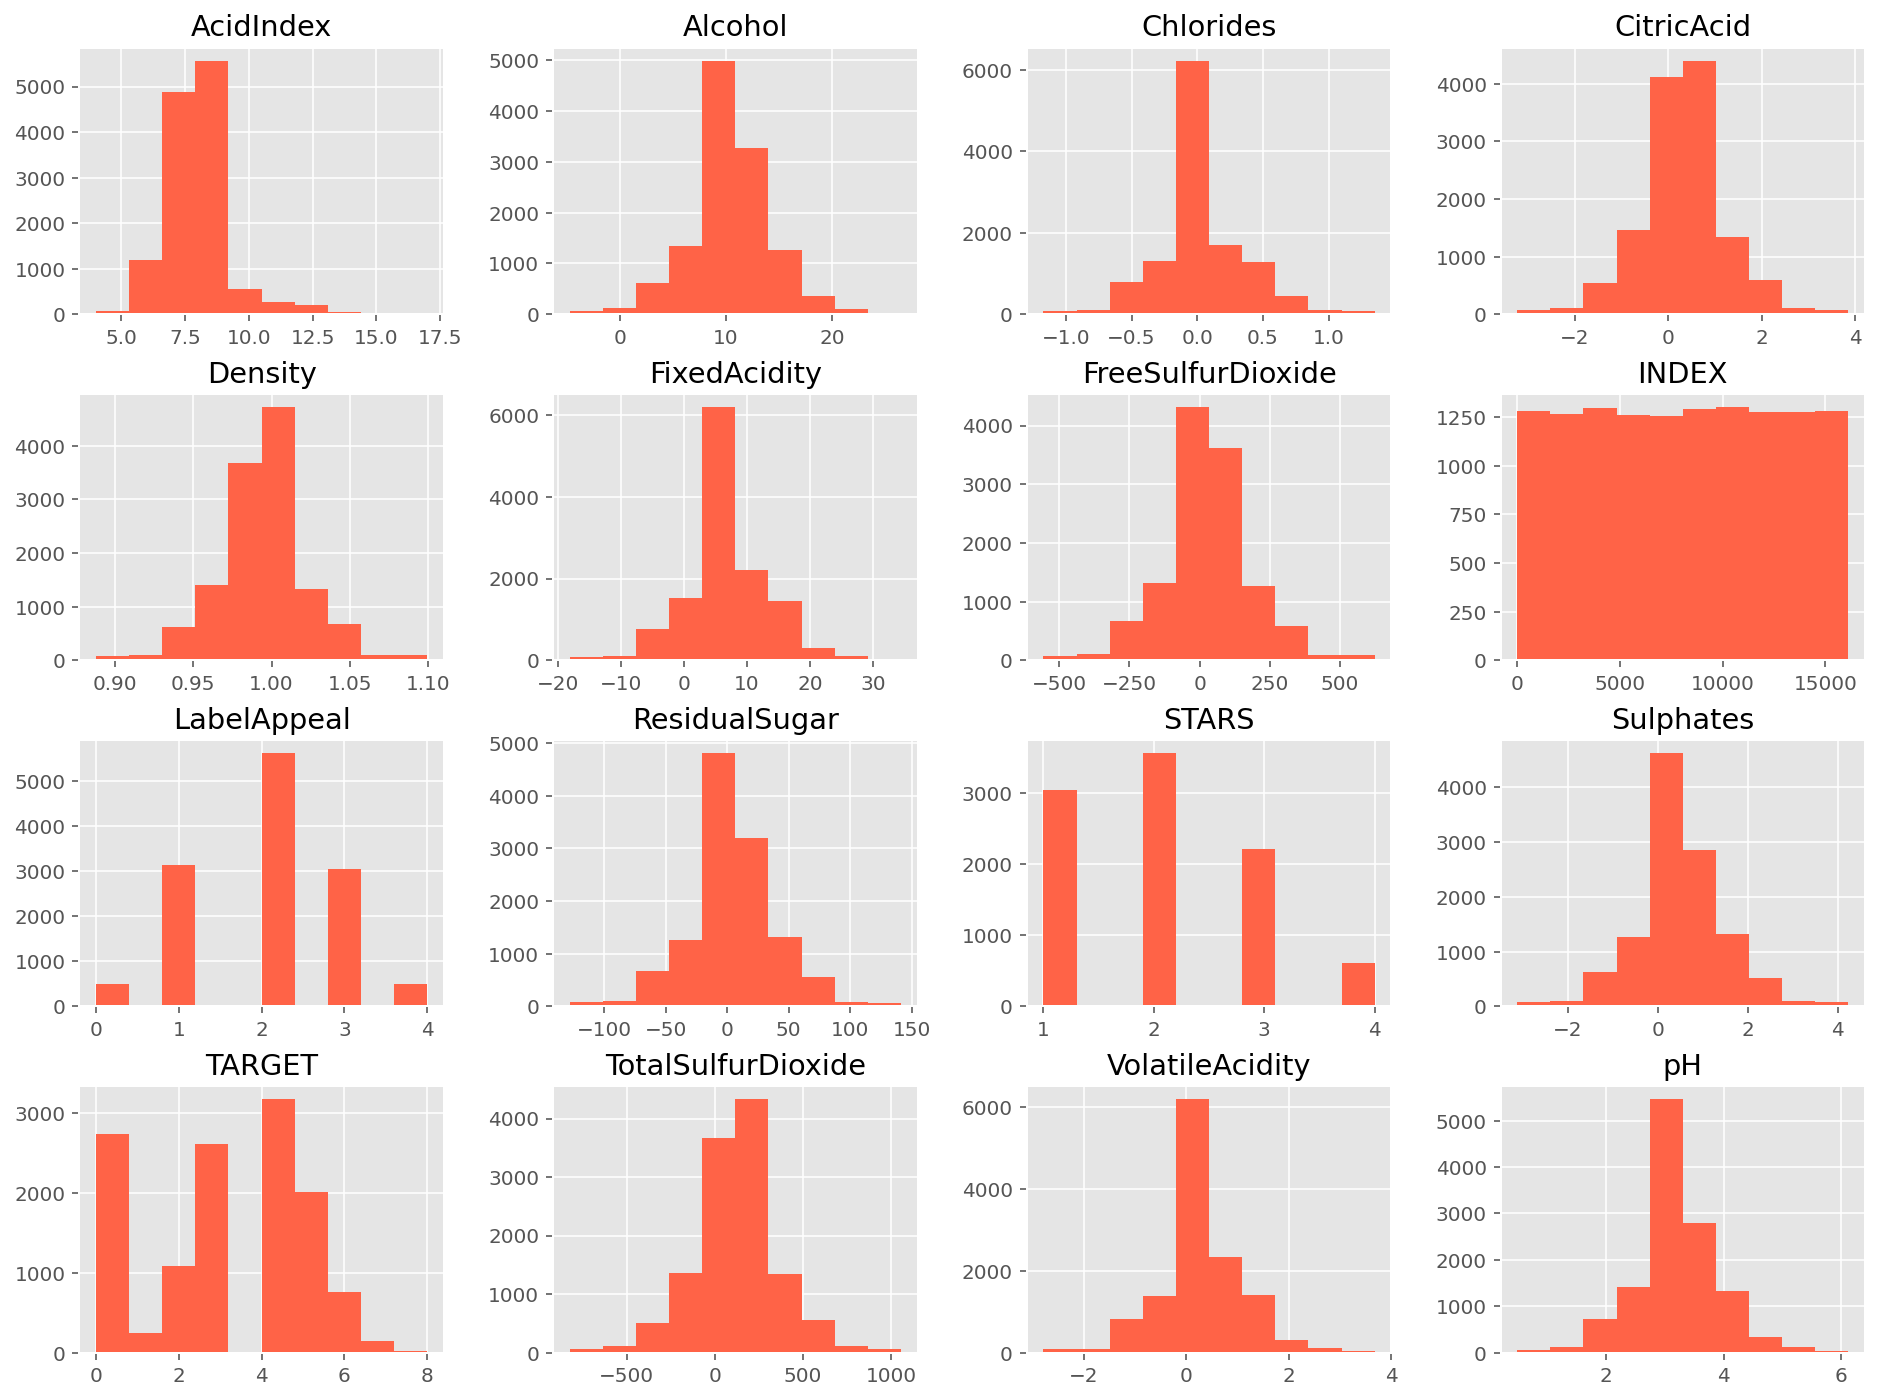

In [35]:
#before applying absolute values
printmd("***Before applying the absolute value***");
df_neg.hist(figsize=(16, 12), color='tomato');
plt.show();

Below are all columns except for LabelAppeal after they have been transformed with absolute values:

***After applying the absolute value***

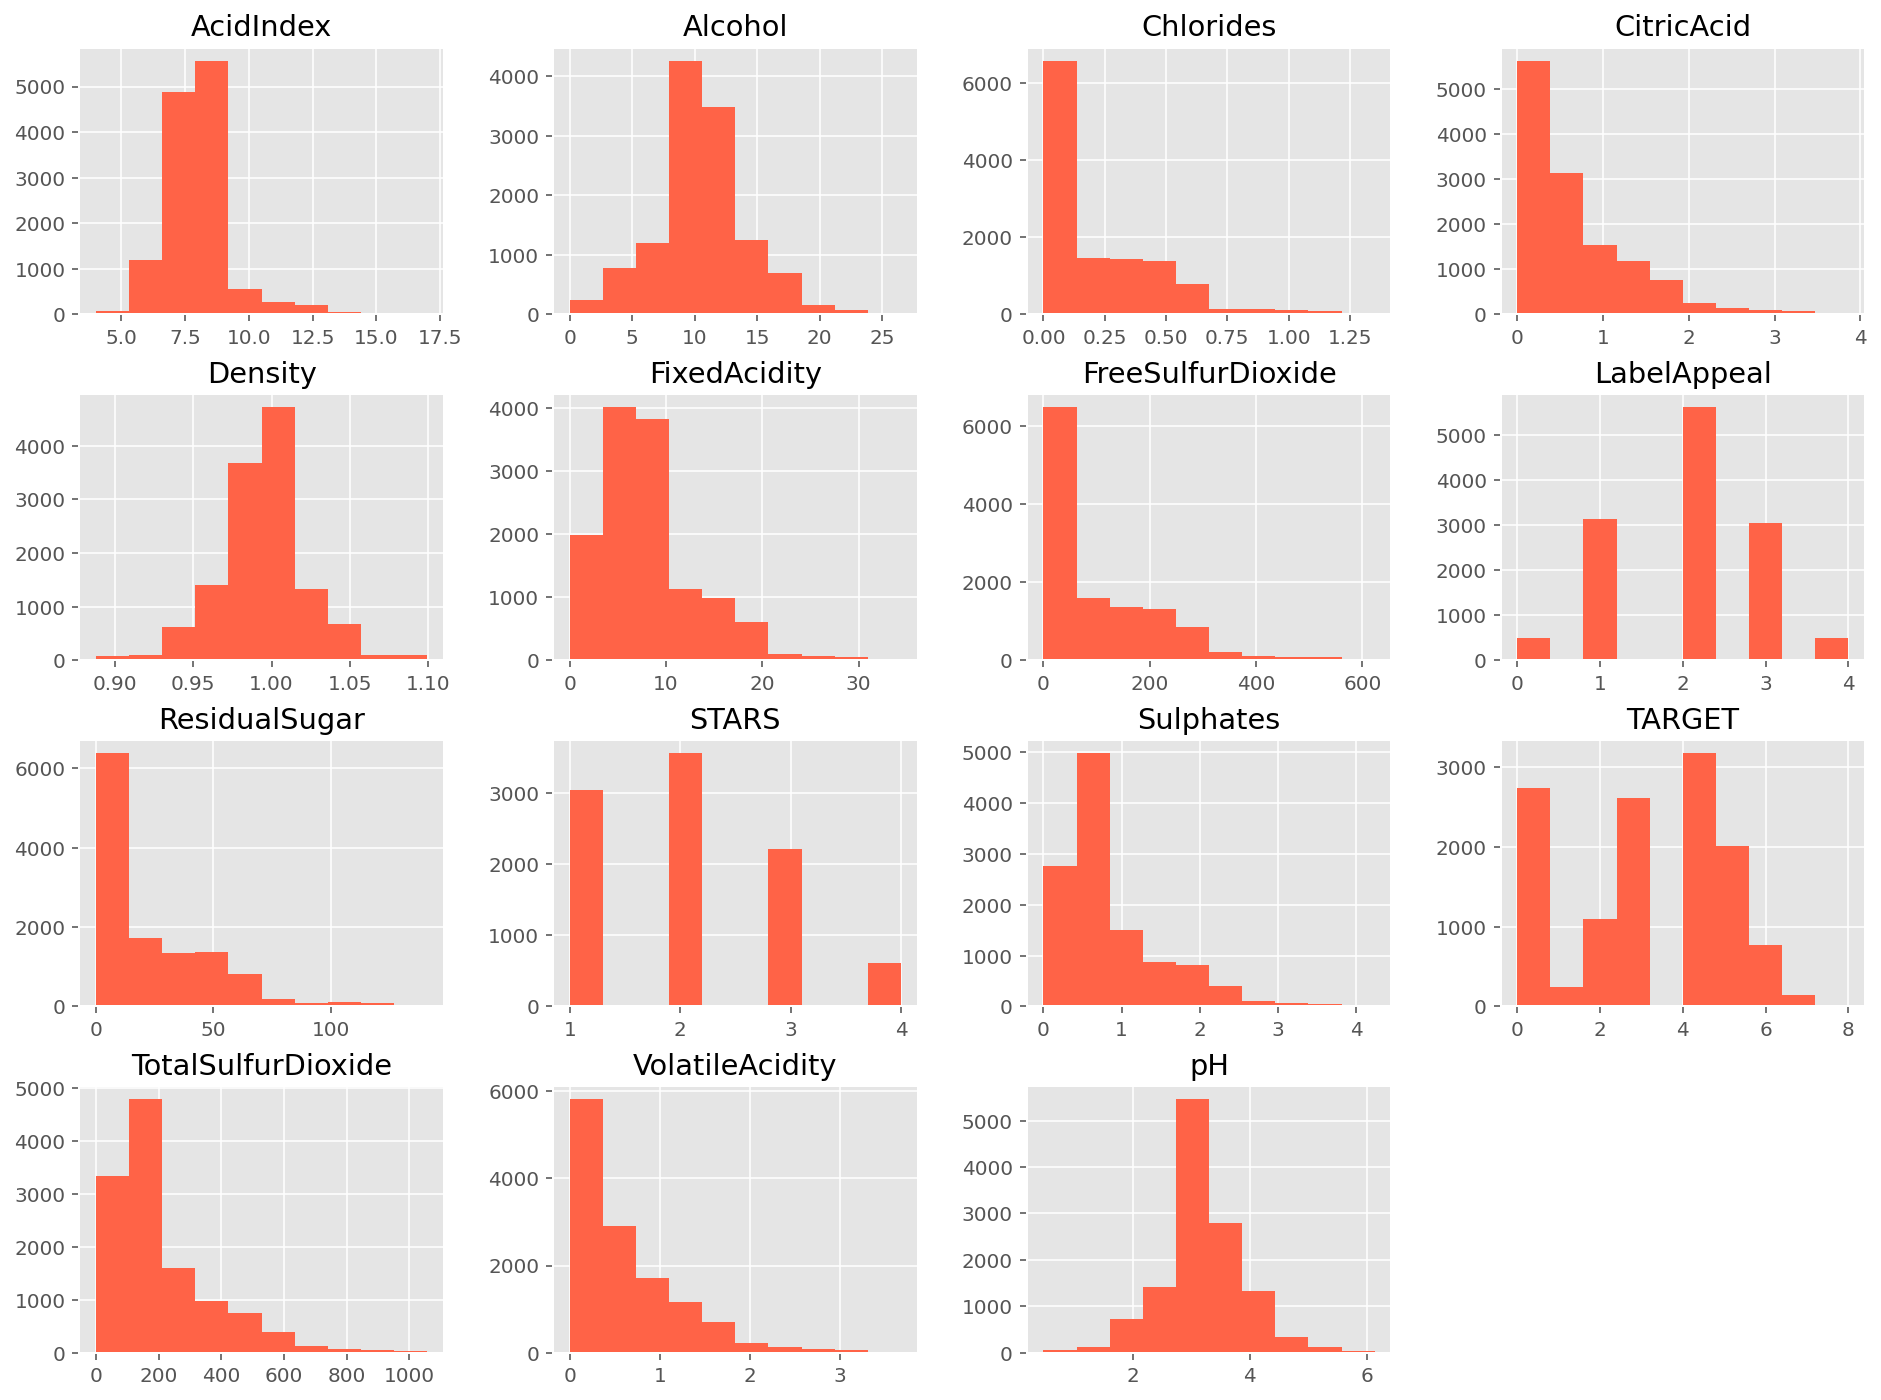

In [36]:
#After applying absolute values
printmd("***After applying the absolute value***");
df.hist(figsize=(16, 12), color='tomato');

After applying the absolute values we can see the severe right skew of the distribution for all variables except for Alcohol, and it seems to be evidence of the outlier values that we identified earlier in our exploratory data analysis (EDA) Section.

In [37]:
# the older values with negative.
df_neg.head(3)

,INDEX,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS
0,1,3,3.2,1.16,-0.98,54.2,-0.567,NaN,268.0,0.99280,3.33,-0.59,9.9,2,8,2.0
1,2,3,4.5,0.16,-0.81,26.1,-0.425,15.0,-327.0,1.02792,3.38,0.70,NaN,1,7,3.0
2,4,5,7.1,2.64,-0.88,14.8,0.037,214.0,142.0,0.99518,3.12,0.48,22.0,1,8,3.0


We can see that the following columns will be impacted with the absolute value: Alcohol, Chlorides, CitricAcid, FixedAcidity, FreeSulfurDioxide, ResidualSugar, Sulphates, TotalSulfurDioxide and VolatileAcidity. <br>
Negative values in LabelAppeal was considered to be valid in this context.

### Changes to the STAR column

In [38]:
#showing first 5 records
df.STARS.value_counts()

2.0    3570
1.0    3042
3.0    2212
4.0     612
Name: STARS, dtype: int64

In [39]:
#checking null values before transformations
df['STARS'].isnull().sum()

3359

Here we consider that records with null values mean that they did not receive a formal review.

In [40]:
#filling null values with zero
df['STARS'].fillna(0, inplace=True)

#sanity check
df['STARS'].isnull().sum()

0

### Getting the dummy values for categorical data

Once we replace the null values with zeros we will identify those records as not been reviewed, so we create a new column called 'STARS_missing'

In [41]:
#get dummy variables based on STARS
df['STARS_missing'] = [1 if i==0 else 0 for i in df['STARS']] 

#sanity check
df.head()

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS,STARS_missing
0,3.0,3.2,1.160,0.98,54.2,0.567,NaN,268.0,0.99280,3.33,0.59,9.9,2.0,8.0,2.0,0
1,3.0,4.5,0.160,0.81,26.1,0.425,15.0,327.0,1.02792,3.38,0.70,NaN,1.0,7.0,3.0,0
2,5.0,7.1,2.640,0.88,14.8,0.037,214.0,142.0,0.99518,3.12,0.48,22.0,1.0,8.0,3.0,0
3,3.0,5.7,0.385,0.04,18.8,0.425,22.0,115.0,0.99640,2.24,1.83,6.2,1.0,6.0,1.0,0
4,4.0,8.0,0.330,1.26,9.4,NaN,167.0,108.0,0.99457,3.12,1.77,13.7,2.0,9.0,2.0,0


We can see at the right of the dataframe we have new columns corresponding to the values of the rating for that particular wine.

### Changes to numeric continuous variables

<!-- As we saw in EDA section there are several attributes with negative values, and based on the research we conclude that we need to replace them. If we assume that there was an error in the data entry, we can use the absolute value to replace negative by positive. <br>
Below it is a dataframe that summaries the number of negatives as well as null values in each column. -->

In [42]:
#chckuing that there are no negative values, and there aren't
negatives_count=df.iloc[:,1:].where(df.iloc[:,1:]<0).count()
negatives_count

FixedAcidity          0
VolatileAcidity       0
CitricAcid            0
ResidualSugar         0
Chlorides             0
FreeSulfurDioxide     0
TotalSulfurDioxide    0
Density               0
pH                    0
Sulphates             0
Alcohol               0
LabelAppeal           0
AcidIndex             0
STARS                 0
STARS_missing         0
dtype: int64

#### Outliers - Alcohol

In [43]:
def remove_outliers(col_name):
    """
    Removing the outliers that are 2.5 standard deviations away from the mean.
    """
    return df[np.abs(df[col_name] - df[col_name].mean() ) > (2.5 * df[col_name].std() )]
    
    

In [44]:
# find all wine rows that have Alcohol values whose values are > 
# 2.5 standard deviations from the mean of data in that column
Alcohol_outliers = remove_outliers('Alcohol')
print(Alcohol_outliers.Alcohol.min())
print(Alcohol_outliers.Alcohol.max())
print(Alcohol_outliers.shape[0])

0.0
26.5
269


Since we already took the absolute value of this attribute we need to make sure that that all the values we have are valid values.<br/> Here we see the min, max, and statistical outliers. Since the min is 0 and the max is 26.1% we can ignore statistical outliers as all of these values are valid.<br/> However, there is a further concern that 0 may not be a valid number since a wine, by definition, needs alcohol.

In [45]:
Alcohol_outliers = df[np.abs(df['Alcohol'] == 0)]
print(Alcohol_outliers.shape[0])

2


Upon further research we discovered that there is a new kind of wine that goes through a dealcoholizing process and has 0% alcohol. <br/>In any case the impact to any study will be rather low since there are only two observations that have a 0 for Alcohol.<br/>
As such we will not be removing any of this data.

#### Outliers - Chlorides

In [46]:
Chlorides_outliers = remove_outliers('Chlorides')
print(Chlorides_outliers.Chlorides.min())
print(Chlorides_outliers.shape[0])

0.809
345


We see that, according to the research this can still be a valid value, hence we use the limit found in the research, which is 1.0.

In [47]:
#getting Chlorides > 1 as outlier
Chlorides_outliers = df[df['Chlorides'] > 1]
print(Chlorides_outliers.Chlorides.min())
print(Chlorides_outliers.shape[0])

1.001
163


We see than now there are more rows included as valid values. Delete these rows.

In [48]:
#checking previous shape
print(df.shape)

# now remove the extreme outliers from the temporary series
df.drop(Chlorides_outliers.index.values, inplace=True)

#sanity check
print(df.shape)

(12795, 16)
(12632, 16)


#### Outliers - CitricAcid

In [49]:
# find all wine rows that have CitricAcid values whose values are > 
# 2.5 standard deviations from the mean of data in that column

CitricAcid_outliers = remove_outliers('CitricAcid')
print(CitricAcid_outliers.CitricAcid.min())
print(CitricAcid_outliers.shape[0])

2.21
333


According to the research this value is greater than 1.5, will keep the one with 2.5 std and remove these records.

In [50]:
# now remove the extreme outliers from the temporary series
df.drop(CitricAcid_outliers.index.values, inplace=True)

#sanity check
df.shape

(12299, 16)

#### Outliers - FixedAcidity

In [51]:
# find all wine rows that have FixedAcidity values whose values are > 
# 2.5 standard deviations from the mean of data in that column

FixedAcidity_outliers = remove_outliers('FixedAcidity')
print(FixedAcidity_outliers.FixedAcidity.min())
print(FixedAcidity_outliers.shape[0])

20.6
233


According to the research this value is greater than 17 g/L, will keep the one with 2.5 std and remove these records.

In [52]:
# now remove the extreme outliers from the temporary series
df.drop(FixedAcidity_outliers.index.values, inplace=True)

#sanity check
df.shape

(12066, 16)

#### Outliers - FreeSulfureDioxide

In [53]:
# find all wine rows that have FreeSulfurDioxide values whose values are > 
# 2.5 standard deviations from the mean of data in that column

FreeSulfurDioxide_outliers = remove_outliers('FreeSulfurDioxide')
print(FreeSulfurDioxide_outliers.FixedAcidity.min())
print(FreeSulfurDioxide_outliers.shape[0])

0.0
299


We see that, according to the research this can still be a valid value, hence we use the limit found in the research, which is 200

#### Outliers - ResidualSugar

In [54]:
# find all wine rows that have Residual Sugar values whose values are > 
# 2.5 standard deviations from the mean of data in that column

ResidualSugar_outliers = df['ResidualSugar']
print(ResidualSugar_outliers.min())
print(ResidualSugar_outliers.max())

0.0
141.15


As we described earlier, wines range from 0–220 grams per liter sugar (g/L), depending on the style [11] so this means that values are all valid and do not need to be removed.

#### Outliers - Sulphates

In [55]:
# find all wine rows that have TotalSulfureDioxide values whose values are > 
# 2.5 standard deviations from the mean of data in that column

Sulphates_outliers = remove_outliers("Sulphates")
print(Sulphates_outliers.Sulphates.min())
print(Sulphates_outliers.shape[0])

2.48
264


Our research told us that any wine above 2.5 g/L of Sulphates was an outlier, here we find that alignes with the satatistical definitions of an outlier in this data set where the lowest outlier identified has 2.49 g/L. We will now remove the outliers.

In [56]:
# now remove the extreme outliers from the temporary series
df.drop(Sulphates_outliers.index.values, inplace=True)

#sanity check
df.shape

(11802, 16)

#### Outliers - TotalSulfurDioxide

In [57]:
# find all wine rows that have TotalSulfureDioxide values whose values are > 
# 2.5 standard deviations from the mean of data in that column

TotalSulfurDioxide_outliers = remove_outliers('TotalSulfurDioxide')
print(TotalSulfurDioxide_outliers.TotalSulfurDioxide.max())
print(TotalSulfurDioxide_outliers.shape[0])

1057.0
296


According to our research, it seems reasonable to consider values above 500 mg/l as outliers. This differs with the statistical definition and we will opt for the former rather than the latter.

In [58]:
#reassign the value of the outiler table to exclude the values > 500 
TotalSulfurDioxide_outliers = df[df['TotalSulfurDioxide'] > 500]

In [59]:
# now remove the extreme outliers from the temporary series
df.drop(TotalSulfurDioxide_outliers.index.values, inplace=True)

#sanity check
df.shape

(11039, 16)

#### Outliers - VolatileAcidity

In [60]:
# find all wine rows that have VolatileAcidity values whose values are > 
# 2.5 standard deviations from the mean of data in that column

VolatileAcidity_outliers = remove_outliers('VolatileAcidity')
print(VolatileAcidity_outliers.VolatileAcidity.min())
print(VolatileAcidity_outliers.shape[0])

2.04
298


While our research indicated that this number has a legal limit of 1.2 in the US we don't know where this data originated from. Because of this we will need to use a standard statistical definition of 2.5 standard deviations from the mean

In [61]:
# now remove the extreme outliers from the temporary series
df.drop(VolatileAcidity_outliers.index.values, inplace=True)

#sanity check
df.shape

(10741, 16)

### Filling Missing the Values 

The data set here is full of features that are missing values we will impute these values with the goal of preserving all of the metadata associated at that row and also with the goal to preserve the probability density function of a particular attribute.

In [62]:
#getting exact number of null values in each column
null_count = df.isnull().sum()
null_count

TARGET                   0
FixedAcidity             0
VolatileAcidity          0
CitricAcid               0
ResidualSugar          516
Chlorides              537
FreeSulfurDioxide      540
TotalSulfurDioxide     617
Density                  0
pH                     332
Sulphates             1050
Alcohol                542
LabelAppeal              0
AcidIndex                0
STARS                    0
STARS_missing            0
dtype: int64

There are 6 columns that need to be fixed now, most them have around 5% of the data missing and the Sulphates attribute has 10% of its data missing. Below you can see a visualization of this:

In [63]:
#creating a copy of the df for the following section
copy = df.copy()

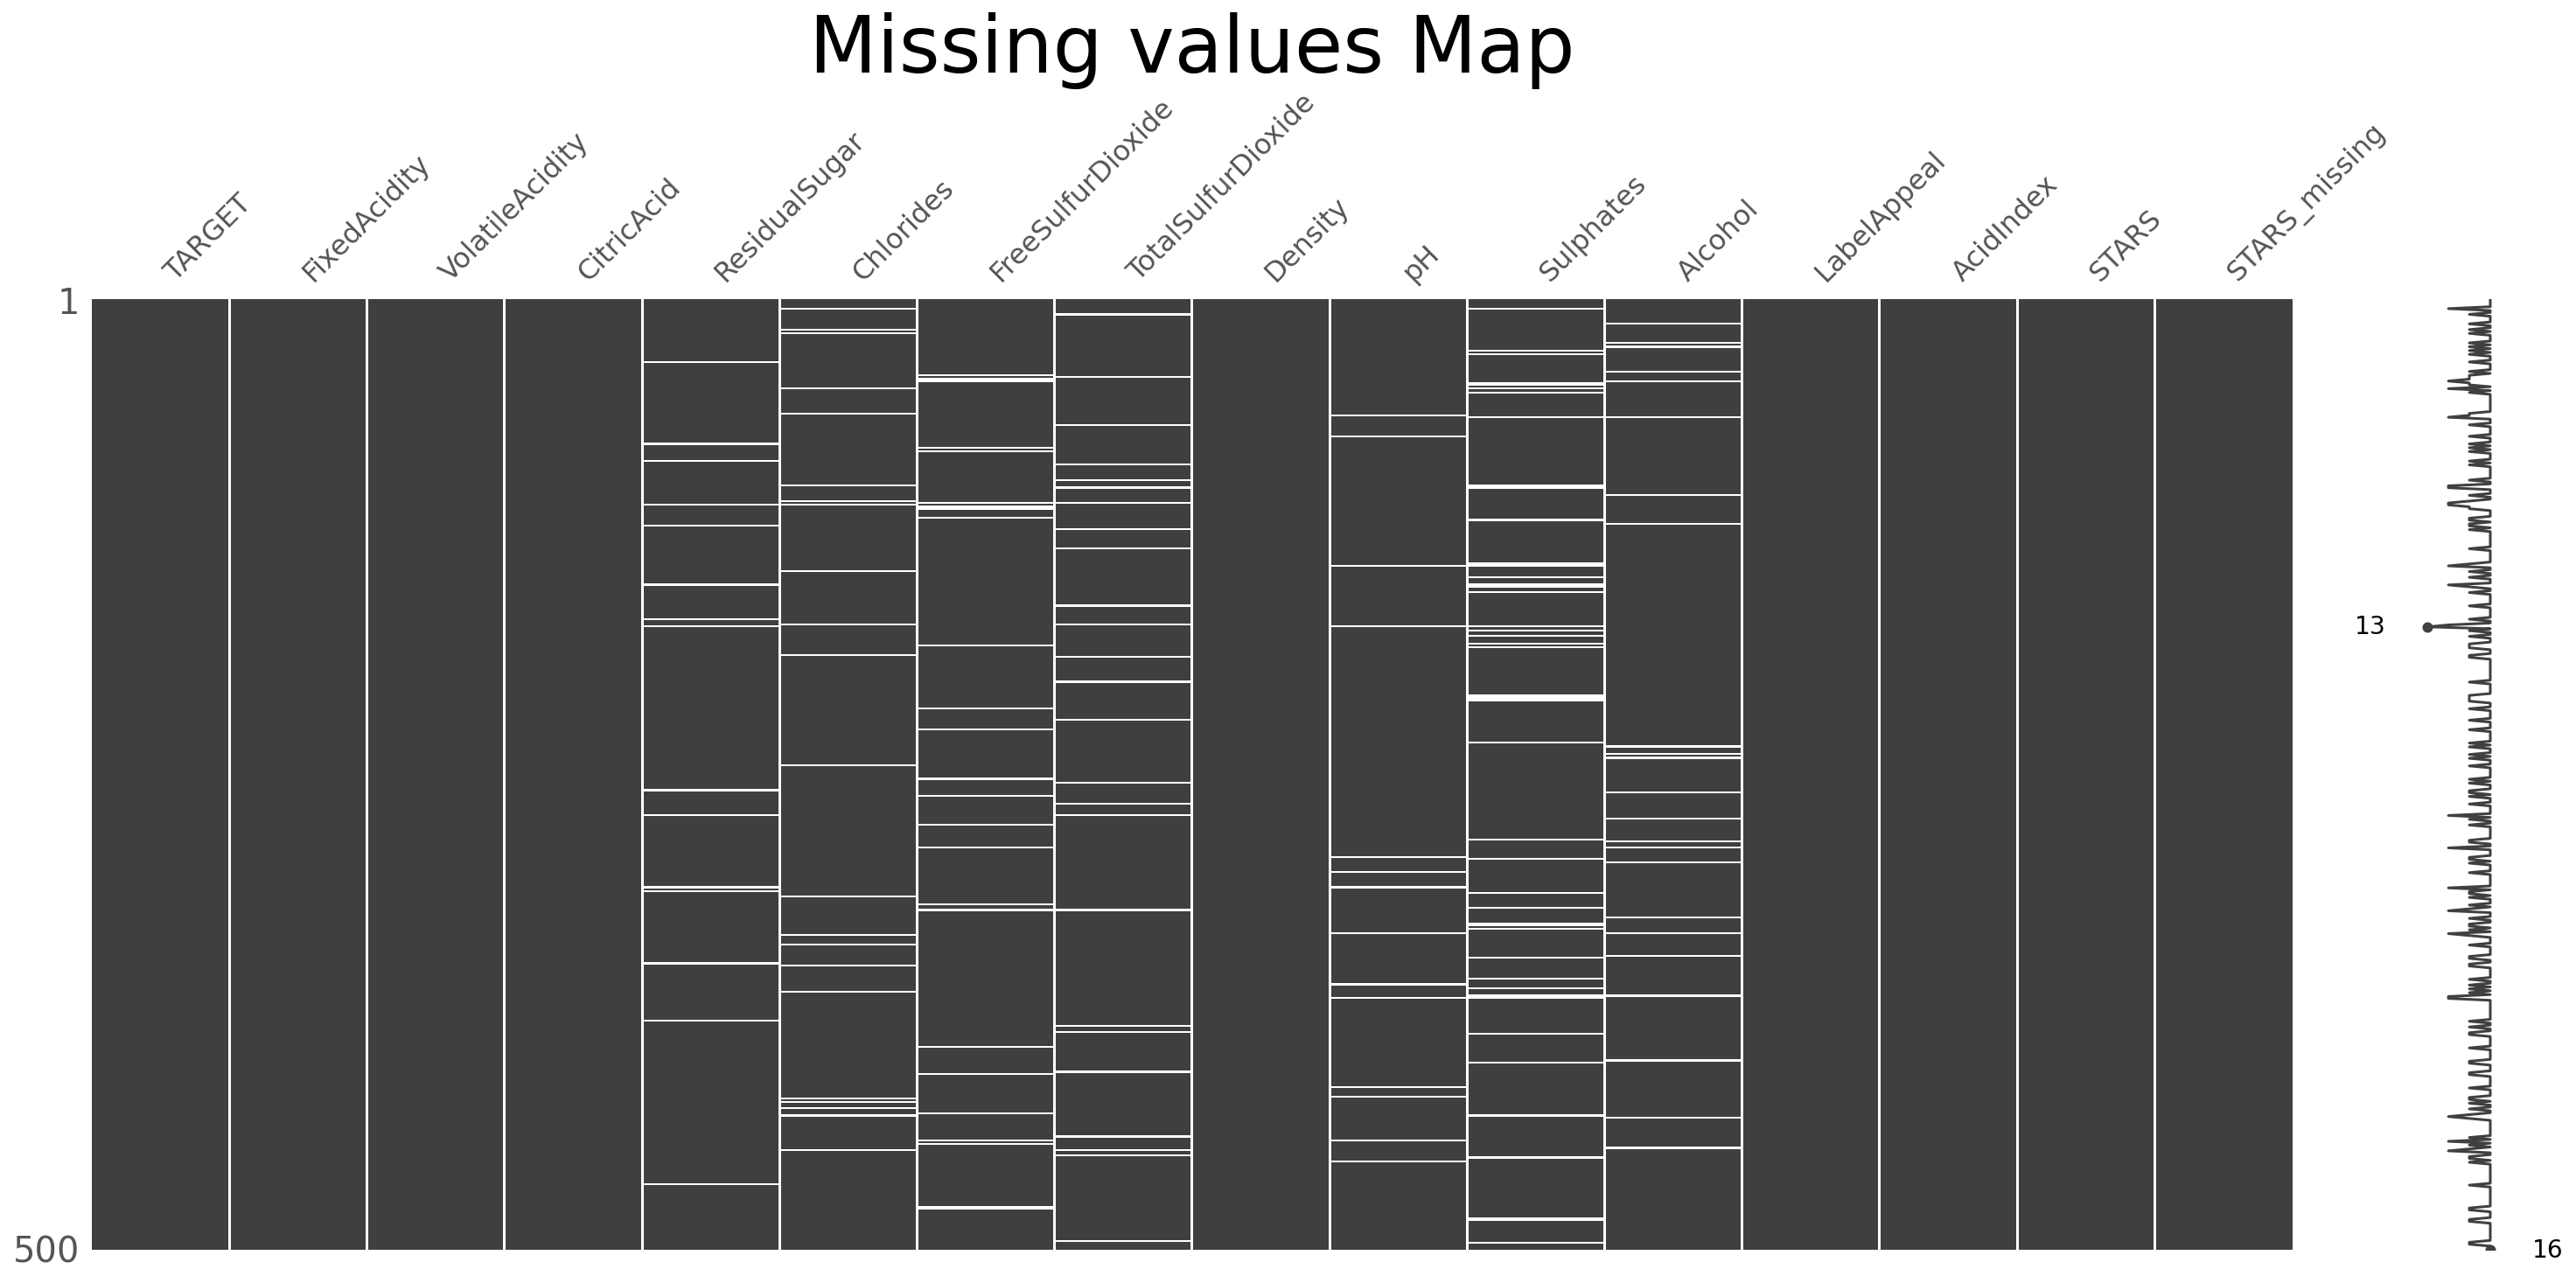

In [64]:
#visualizing patterns in the missing data 500 random records
ax = msno.matrix(df.sample(500))
plt.title("Missing values Map", fontsize=45)
plt.show();

Now that we have found the columns that need to be fixed through imputation we will begin with the Alcohol column.

#### Backwards Filling Alcohol

By observing The missing values map There seems to be a pattern in the Gaps of the missing values as the values seem to be in a missing pair-esque pattern with a high level of proximity to each other from a row perspective, furthermore every value seems to be very close to next one in terms of value and the standard deviation seems to be low relative the mean value. Data can be filled by propagating the non-NaN values backwards in a Series, be imposing the value of the cell ahead onto the value of the previous cell.  

Below are the are the columns that exhibit this such phenomena

- Alcohol
- FreeSulfurDioxide
- ResidualSugar

After attempting this method, it proved fruitful as it preserved the probability density function.


In [65]:
#filling missing values for Alcohol, strategy backwardsfill
df.Alcohol.bfill(inplace = True)

#filling missing values for Alcohol, strategy backwardsfill
df.FreeSulfurDioxide.bfill(inplace =True)

#filling missing values for Alcohol, strategy backwardsfill
df.ResidualSugar.bfill(inplace =True)

**Before & After filling missing values with backwards fill**

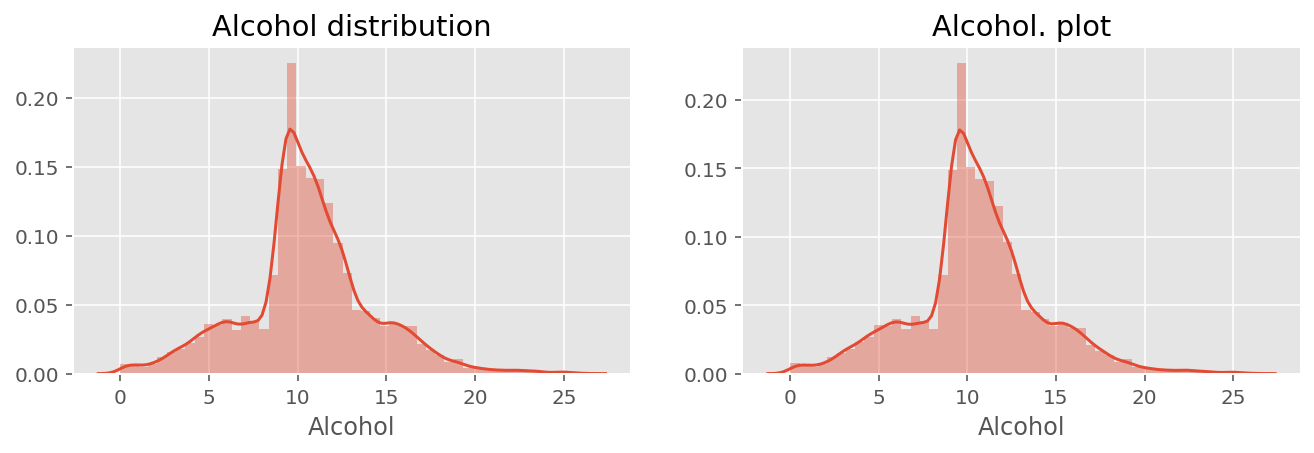

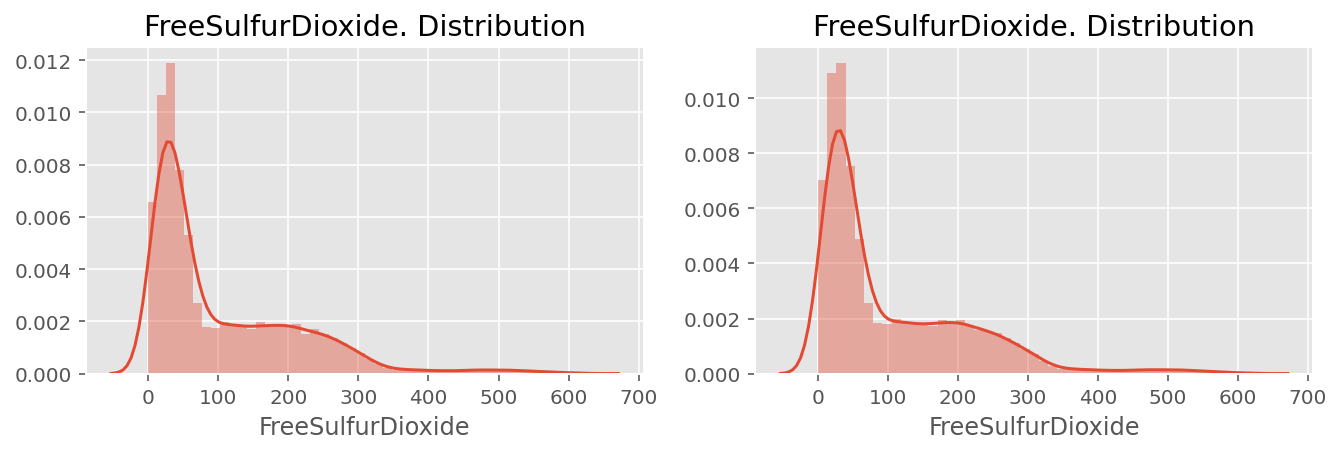

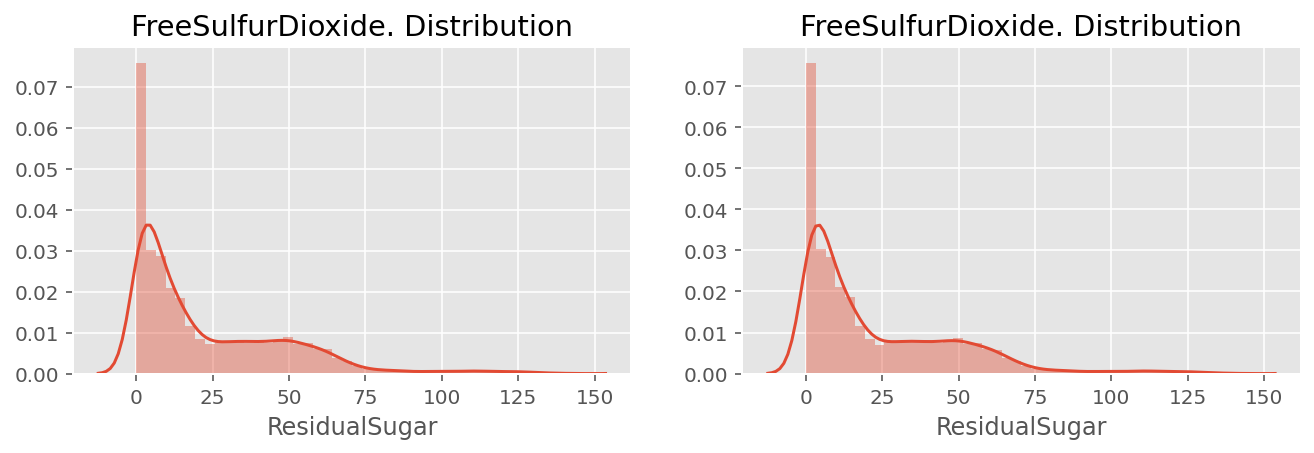

In [66]:
printmd('**Before & After filling missing values with backwards fill**')

#"Alcohol"
#checking distribution before and after
fig = plt.figure(figsize=(11,3))
plt.subplot(1, 2, 1)
sns.distplot(df["Alcohol"]);
plt.title("Alcohol distribution");

plt.subplot(1, 2, 2)
sns.distplot(copy[copy["Alcohol"].notnull()]["Alcohol"]);
plt.title("Alcohol. plot");
plt.show();

# "FreeSulfurDioxide"
#checking distribution before and after
fig = plt.figure(figsize=(11,3))

plt.subplot(1, 2, 1)
plt.title("FreeSulfurDioxide. Distribution");
sns.distplot(df["FreeSulfurDioxide"]);

plt.subplot(1, 2, 2)
sns.distplot(copy[copy["FreeSulfurDioxide"].notnull()]["FreeSulfurDioxide"]);
plt.title("FreeSulfurDioxide. Distribution");
plt.show();


##"ResidualSugar"

#checking distribution before and after
fig = plt.figure(figsize=(11,3))

plt.subplot(1, 2, 1)
sns.distplot(df["ResidualSugar"]);
plt.title("FreeSulfurDioxide. Distribution");

plt.subplot(1, 2, 2)
sns.distplot(copy[copy["ResidualSugar"].notnull()]["ResidualSugar"]);
plt.title("FreeSulfurDioxide. Distribution");
plt.show();

In [67]:
print("\t\t\t***Missing values count***")
print()
print("The total number of missing values for Alcohol is:", df.Alcohol.isnull().sum())
print("The total number of missing values for FreeSulpurDioxide is:", df.FreeSulfurDioxide.isnull().sum())
print("The total number of missing values for residual sugar is:", df.ResidualSugar.isnull().sum())

			***Missing values count***

The total number of missing values for Alcohol is: 0
The total number of missing values for FreeSulpurDioxide is: 0
The total number of missing values for residual sugar is: 0


#### Forward fill

By observing The missing values map There seems to be a pattern in the Gaps of the missing values as the values seem to be in a missing pair-esque pattern with a high level of proximity to each other from a row prespective, furthermore every value seems to be very close to next one in terms of value and the standard deviation seems to be low relative the mean value.data can be filled by propagating the non-NaN values forward in a Series, be imposing the value of the previous cell onto the value of the upcoming cell. 

Below are the are the columns that exhibt this such phenomena.
- Chlorides
- Sulphates
- Total Sulfur Dioxide
- pH

After attempting this method, it proved fruitful as it preserved the probability density function.

In [68]:
#filling missing values for Alcohol, strategy ffill
df.Chlorides.ffill(inplace =True)

#filling missing values for Alcohol, strategy ffill
df.Sulphates.ffill(inplace =True)

#filling missing values for Alcohol, strategy ffill
df.TotalSulfurDioxide.ffill(inplace =True)

#filling missing values for pH, strategy ffill
df.pH.ffill(inplace =True)

**Before & After filling missing values with forwards fill**

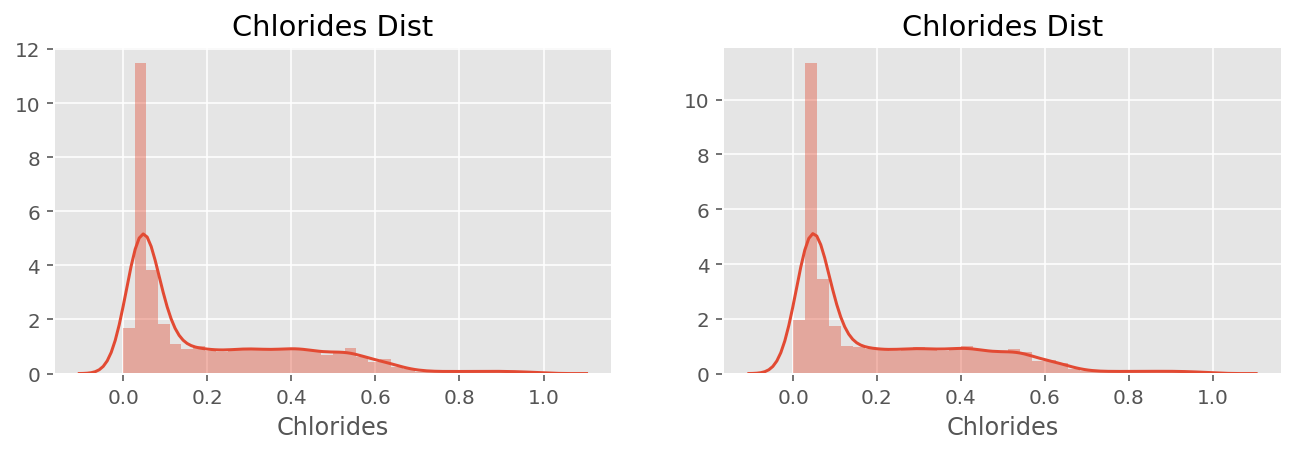

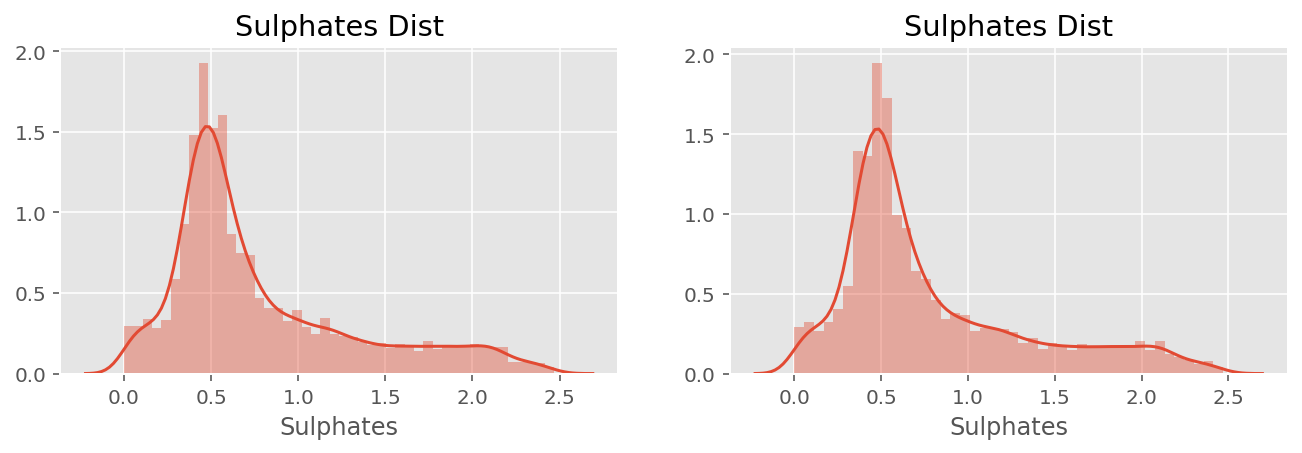

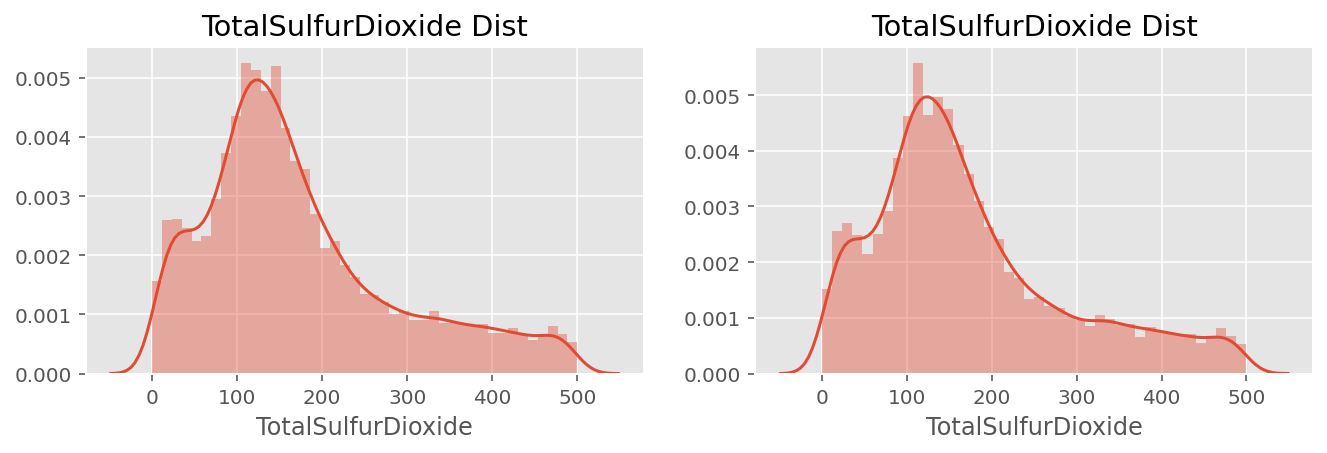

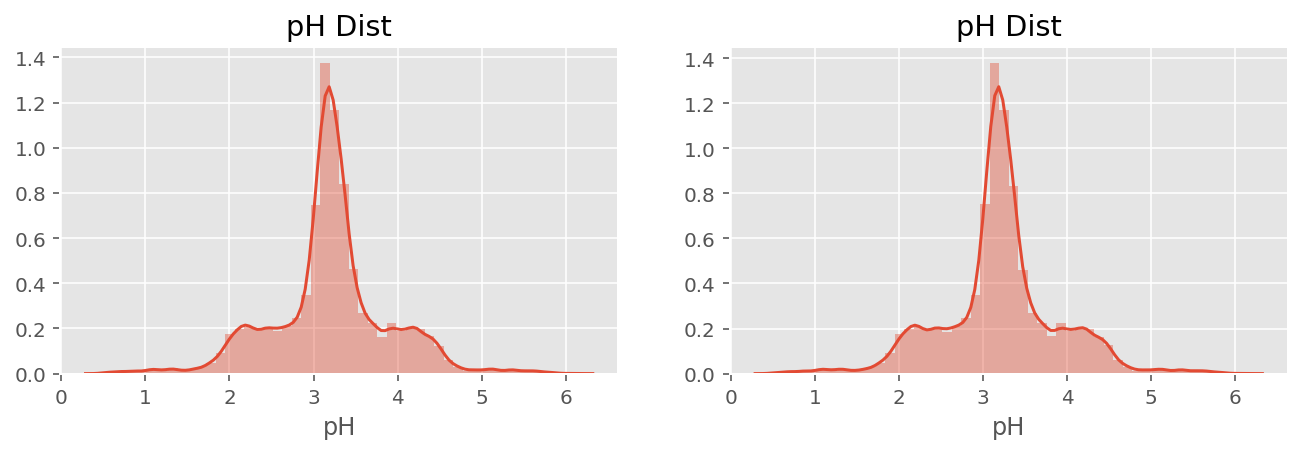

In [69]:
printmd('**Before & After filling missing values with forwards fill**')

#1
#checking Chlorides distribution before and after
fig = plt.figure(figsize=(11,3))

plt.subplot(1, 2, 1)
plt.title('Chlorides Dist')
sns.distplot(df["Chlorides"]);

plt.subplot(1, 2, 2)
sns.distplot(copy[copy["Chlorides"].notnull()]["Chlorides"]);
plt.title('Chlorides Dist')
plt.show();

#2
#checking Sulphates distribution before and after
fig = plt.figure(figsize=(11,3))

plt.subplot(1, 2, 1)
sns.distplot(df["Sulphates"]);
plt.title('Sulphates Dist')

plt.subplot(1, 2, 2)
sns.distplot(copy[copy["Sulphates"].notnull()]["Sulphates"]);
plt.title('Sulphates Dist')
plt.show();

#3
#checking TotalSulfurDioxide distribution before and after
fig = plt.figure(figsize=(11,3))

plt.subplot(1, 2, 1)
sns.distplot(df["TotalSulfurDioxide"]);
plt.title('TotalSulfurDioxide Dist')

plt.subplot(1, 2, 2)
sns.distplot(copy[copy["TotalSulfurDioxide"].notnull()]["TotalSulfurDioxide"]);
plt.title('TotalSulfurDioxide Dist')
plt.show();

#4
#checking distribution before and after
fig = plt.figure(figsize=(11,3))

plt.subplot(1, 2, 1)
sns.distplot(df["pH"]);
plt.title('pH Dist')

plt.subplot(1, 2, 2)
sns.distplot(copy[copy["pH"].notnull()]["pH"]);
plt.title('pH Dist')
plt.show();

In [70]:
print("\t\t\t***Missing values count***")
print()
print("The total number of missing values for chlorides is:",df.Chlorides.isnull().sum())
print("The total number of missing values for Sulphates is:",df.Sulphates.isnull().sum())
print("The total number of missing values for total sulfur dioxide is:",df.TotalSulfurDioxide.isnull().sum())
print("The total number of missing values: for pH is:",df.pH.isnull().sum())

			***Missing values count***

The total number of missing values for chlorides is: 0
The total number of missing values for Sulphates is: 0
The total number of missing values for total sulfur dioxide is: 0
The total number of missing values: for pH is: 0


### Normalization

One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. [12]. <br>
With min-max scaling values are shifted and rescaled so that they end up ranging from 0 to 1. <br>

We will apply this technique to the numerical features only.

In [71]:
columns=['Density', 'AcidIndex', 'Alcohol', 'Chlorides', 
         'CitricAcid','FixedAcidity',
         'FreeSulfurDioxide', 'ResidualSugar', 
         'Sulphates','TotalSulfurDioxide',
         'VolatileAcidity', 'pH']

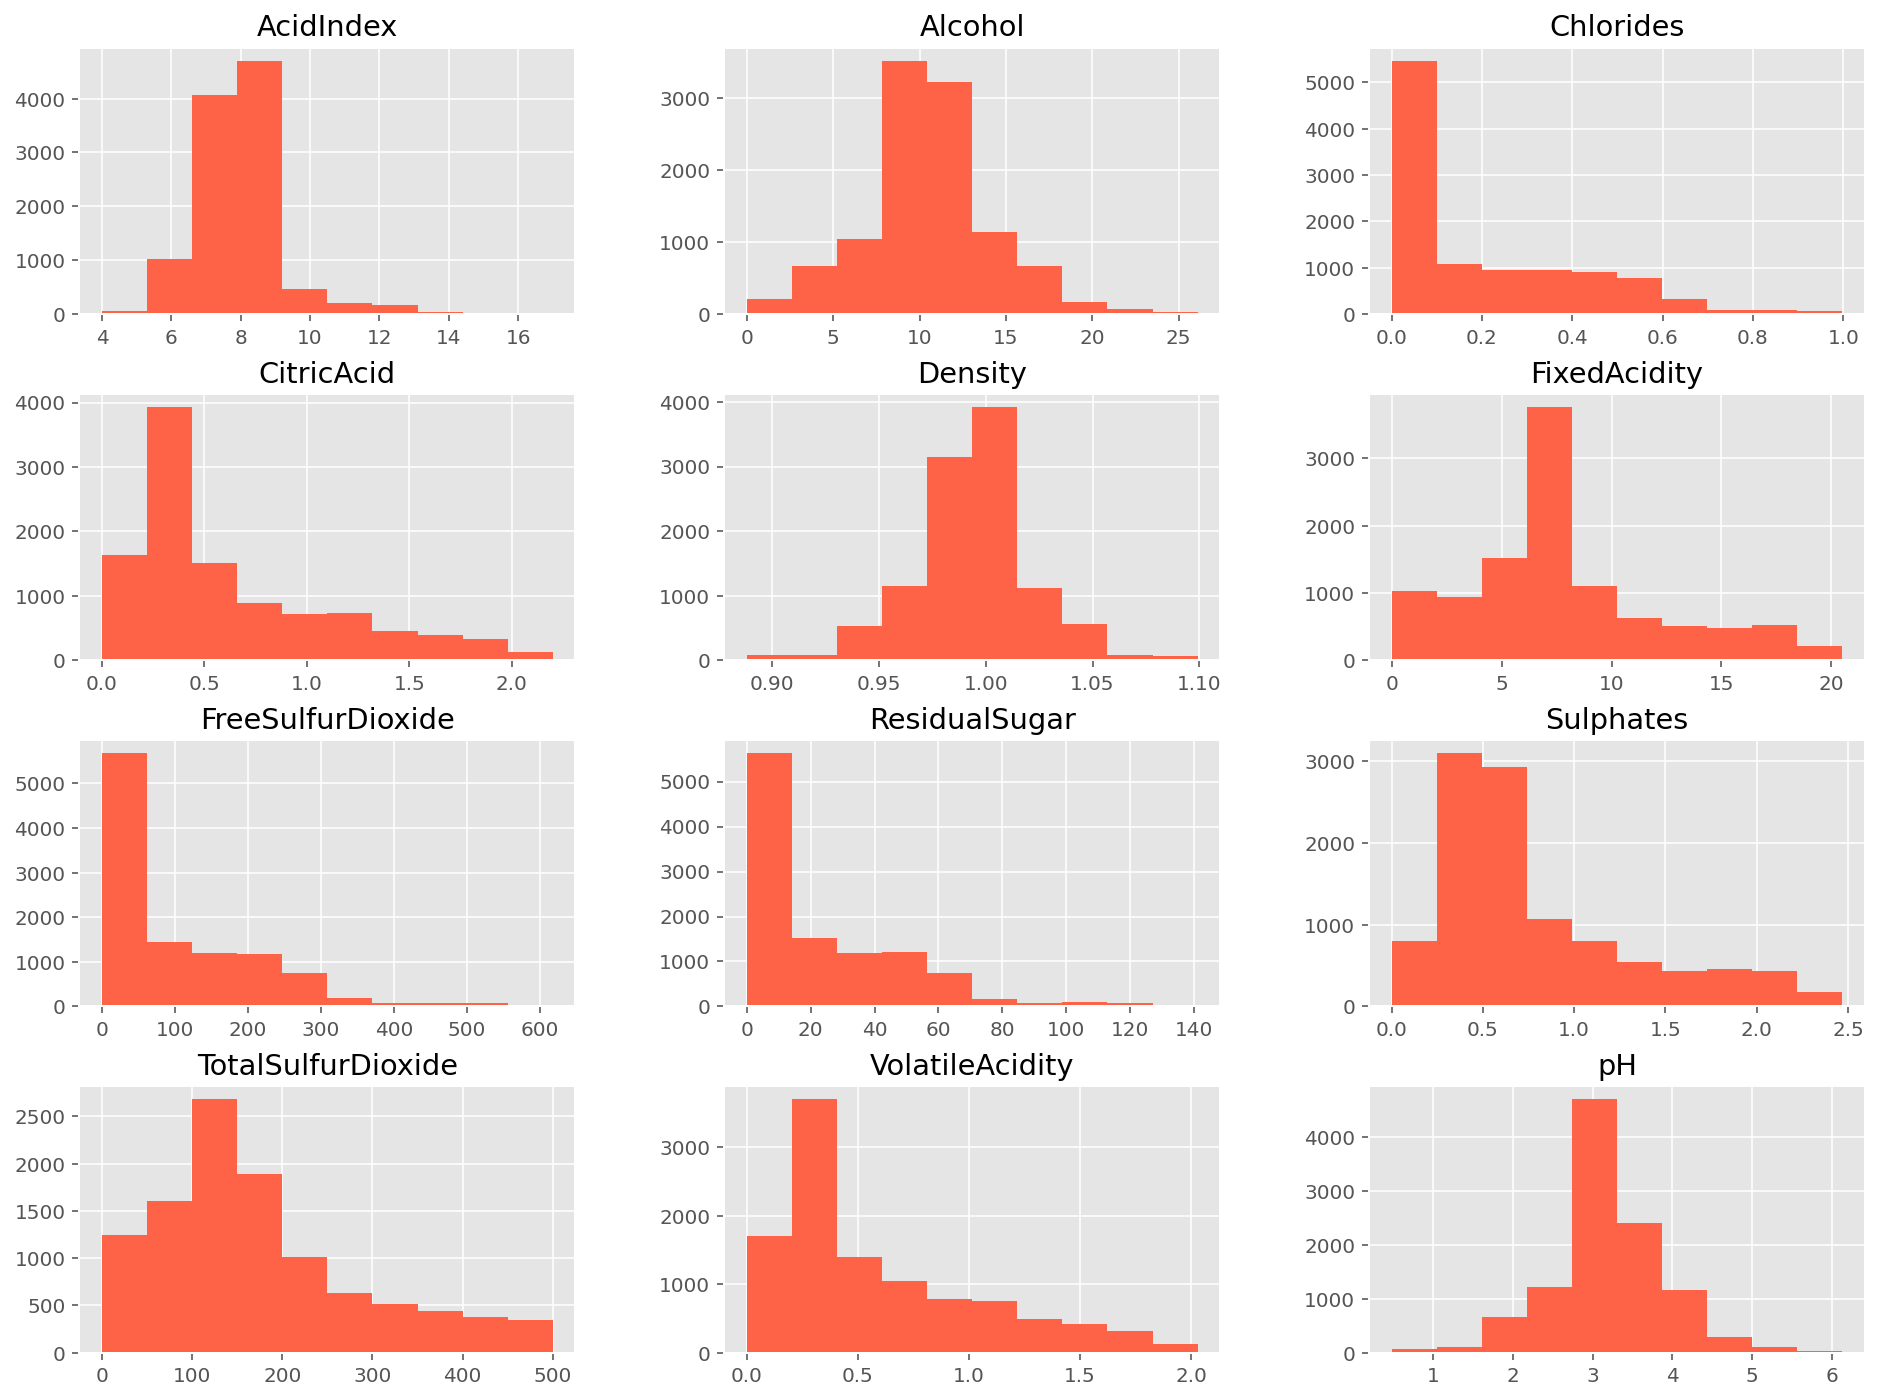

In [72]:
df[columns].hist(figsize=(16, 12), color='tomato');

Above you can see the distributions of the numeric features before they are transformed

In [73]:
X = df[columns] # exp
y = df['TARGET'] # response 1

In [74]:
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()
X = mm.fit_transform(df[columns].values)

In [75]:
#normalized = pd.DataFrame(X, columns = columns)
normalized = pd.DataFrame(X, index=df.index, columns=columns)

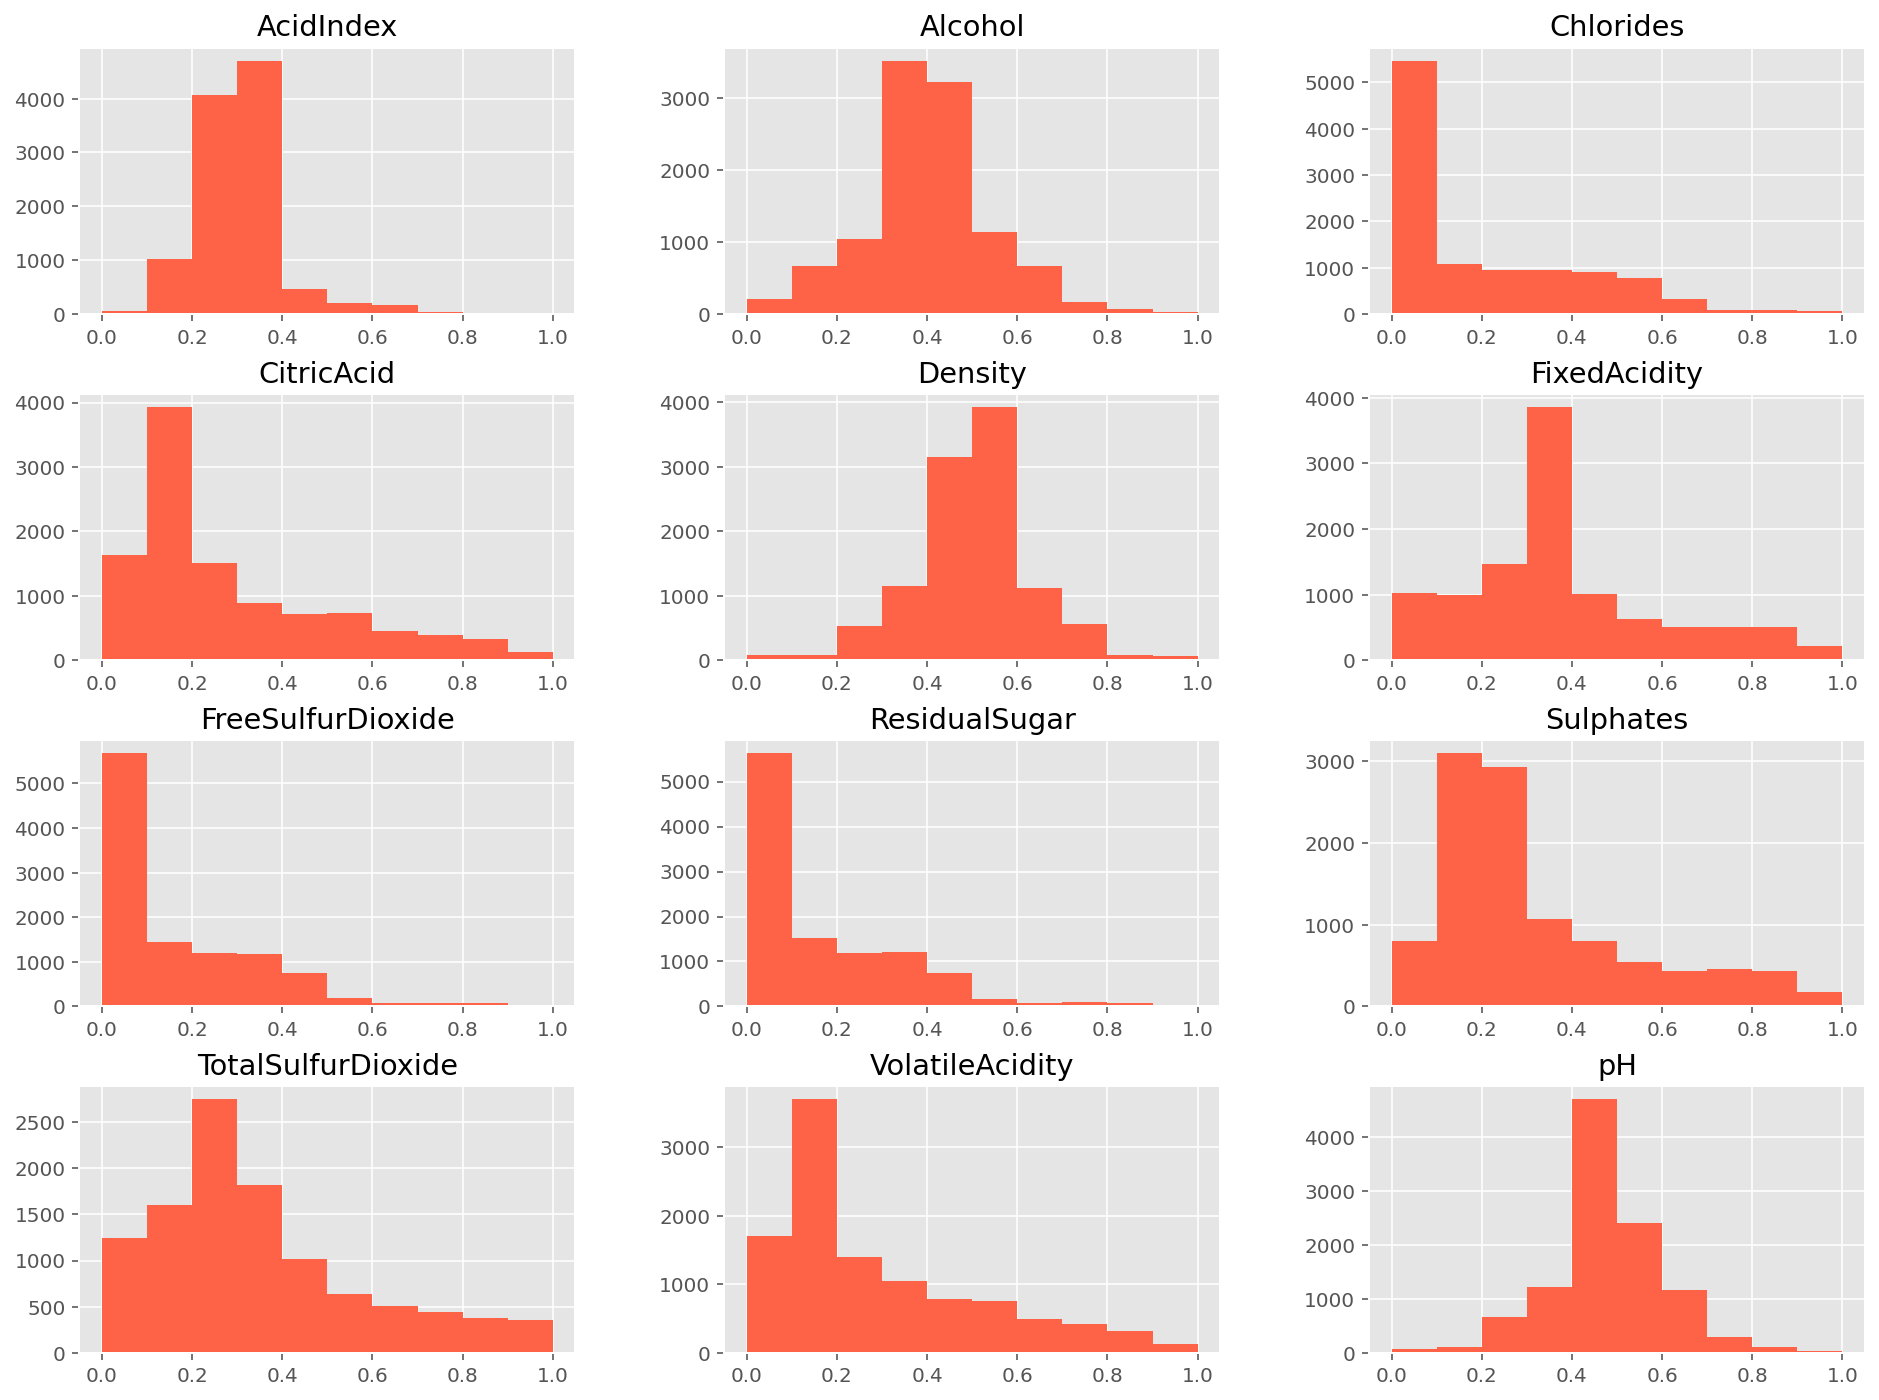

In [76]:
normalized.hist(figsize=(16, 12), color='tomato');

Above we see the transformed numeric data ready to be used in a model

Now we will add our normalized columns back to the original dataframe

In [77]:
df = df.drop(columns, axis=1)

In [78]:
df.shape

(10741, 4)

In [79]:
result = pd.concat([df, normalized], axis=1).reindex(df.index)

In [80]:
df = result

In [81]:
df.describe()

,TARGET,LabelAppeal,STARS,STARS_missing,Density,AcidIndex,Alcohol,Chlorides,CitricAcid,FixedAcidity,FreeSulfurDioxide,ResidualSugar,Sulphates,TotalSulfurDioxide,VolatileAcidity,pH
count,10741.000000,10741.000000,10741.000000,10741.000000,10741.000000,10741.000000,10741.000000,10741.000000,10741.000000,10741.000000,10741.000000,10741.000000,10741.000000,10741.000000,10741.000000,10741.000000
mean,3.033516,1.994228,1.511219,0.259380,0.501527,0.289989,0.404315,0.210242,0.285585,0.377504,0.171734,0.165159,0.319394,0.348126,0.291483,0.482023
std,1.927550,0.888979,1.185335,0.438315,0.124491,0.100731,0.139656,0.210151,0.227706,0.216546,0.173798,0.176870,0.220680,0.230728,0.225725,0.121174
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,0.000000,0.000000,0.473265,0.230769,0.344828,0.045090,0.127273,0.268293,0.045307,0.024088,0.174089,0.192000,0.123153,0.437168
50%,3.000000,2.000000,2.000000,0.000000,0.503481,0.307692,0.398467,0.094188,0.190909,0.341463,0.090615,0.091392,0.234818,0.294000,0.197044,0.481416
75%,4.000000,3.000000,2.000000,1.000000,0.530950,0.307692,0.475096,0.357715,0.413636,0.458537,0.276699,0.274885,0.417004,0.454000,0.423645,0.529204
max,8.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Summary for data prep

- Cleaning involved imputation and the removal of several columns which allowed to have a better understanding of the nature of the dataset. </br>
- These modifications allowed us to replace missing null values to avoid deleting columns that had a power predictive value.
- Had we removed every observation that had missing (or negative) values we would have been left with just a few hundred rows of data.
- backfill and fpwardfill are the best for filling missing values in our case.
- Applied feature scaling using MinMaxScalar to get the numerical explanatory variables normalized to a range between 0 and 1.

# Feature Selection

We begin the process of choosing our features after our EDA and data cleaning with a correlation check to see if there are any obvious featuers we should be including in our models.

In [82]:
#appending target
columns.append('TARGET')

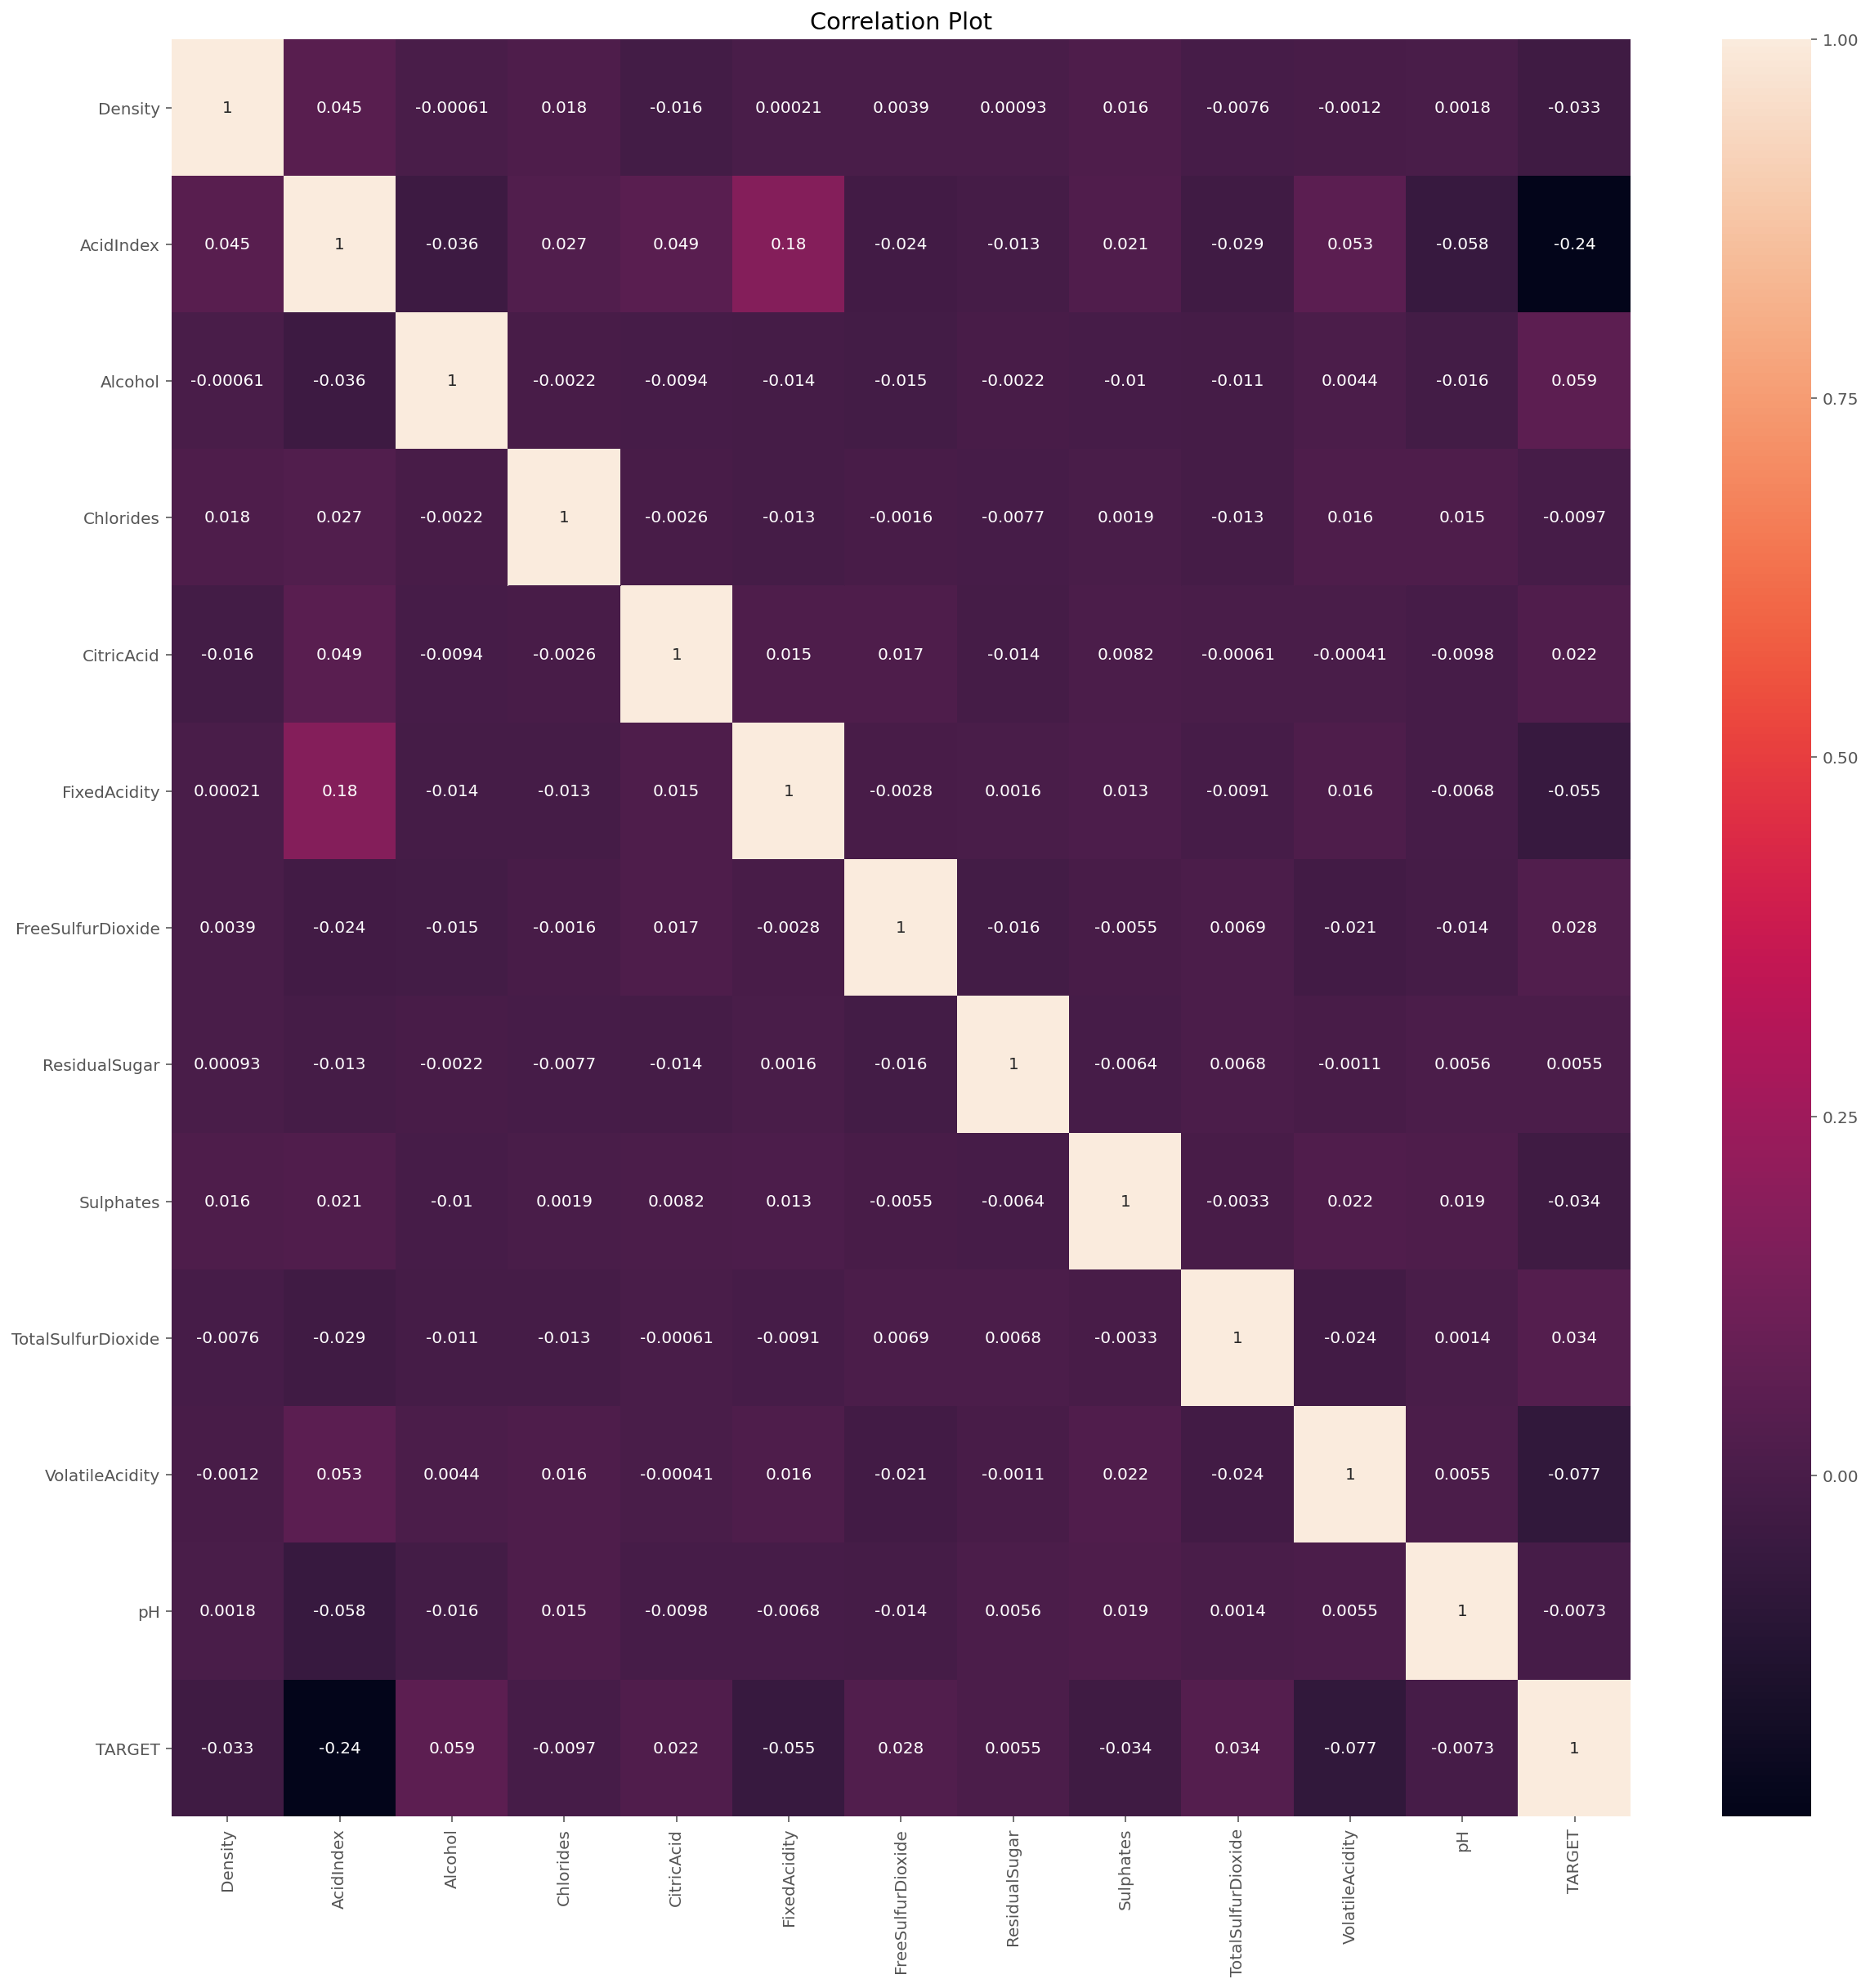

In [83]:
#checking correlations after all our data prep
cor = df[columns].corr()
plt.figure(figsize=(20,20))
plt.title("Correlation Plot")
sns.heatmap(cor,annot=True)
plt.show()

We don't see high correlations between numeric columns and the TARGET, suggesting we can avoid including most of them in our predictive model.

In [84]:
df.columns

Index(['TARGET', 'LabelAppeal', 'STARS', 'STARS_missing', 'Density',
       'AcidIndex', 'Alcohol', 'Chlorides', 'CitricAcid', 'FixedAcidity',
       'FreeSulfurDioxide', 'ResidualSugar', 'Sulphates', 'TotalSulfurDioxide',
       'VolatileAcidity', 'pH'],
      dtype='object')

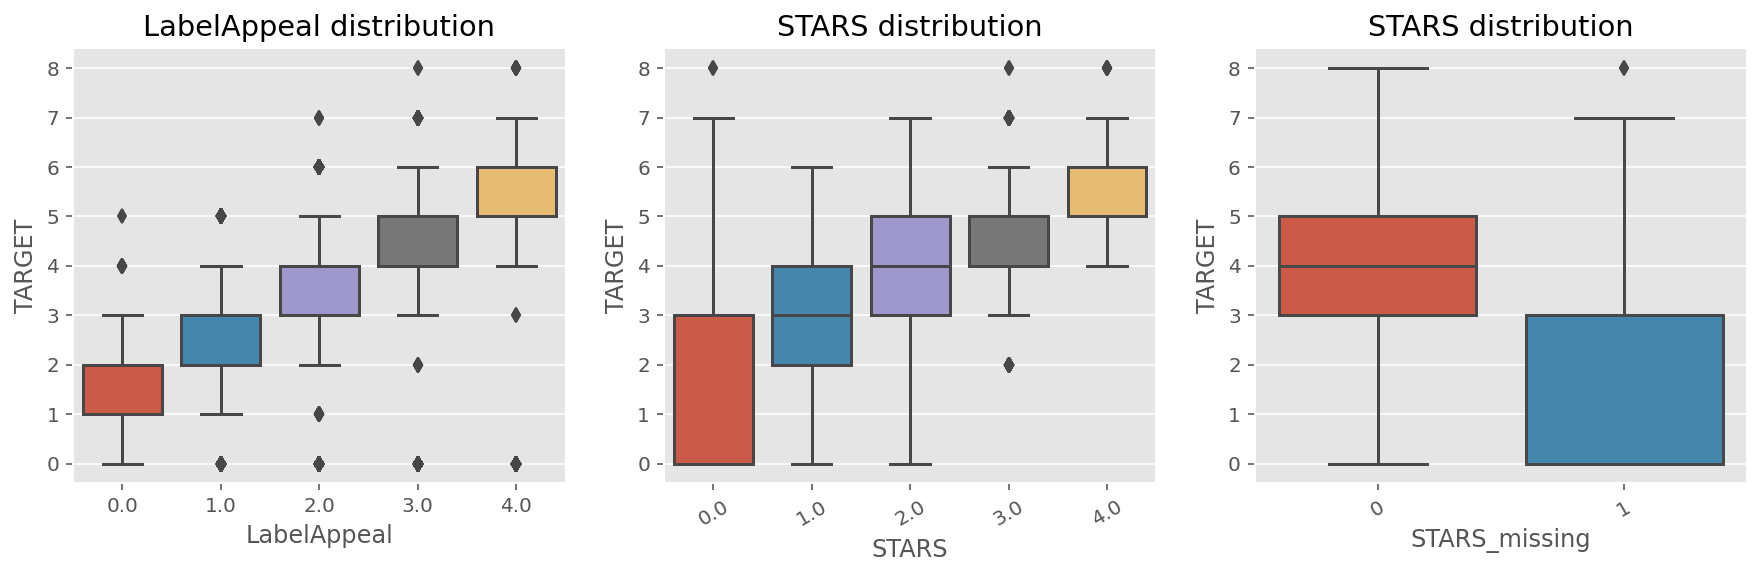

In [85]:
#showing boxplots
fig = plt.figure(figsize=(15,4))
plt.subplot(1, 3, 1)
sns.boxplot(x="LabelAppeal", y="TARGET", data=df)
plt.title("LabelAppeal distribution");

plt.subplot(1, 3, 2)
ax=sns.boxplot(x="STARS", y="TARGET", data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.title("STARS distribution");

plt.subplot(1, 3, 3)
ax=sns.boxplot(x="STARS_missing", y="TARGET", data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.title("STARS distribution");

In [86]:
df[df['STARS'] == 0]['TARGET'].value_counts()

0.0    1719
3.0     370
2.0     262
4.0     217
1.0      95
5.0      86
6.0      28
7.0       7
8.0       2
Name: TARGET, dtype: int64

## Choosing features for the models

Based on our domain knowledge and EDA we conclude that 'AcidIndex', 'LabelAppeal' and 'STARS' are promising predictors for the response variable, so we will include them in our models. For the rest of the features we saw that, individually they don't seem to have a high correlation with TARGET, so we will test their p-values and their coefficients to see if we can improve our model with a selection of the numeric attributes.

In [87]:
m_full = sm.formula.ols(formula = 'TARGET ~ Density + Alcohol + CitricAcid + FixedAcidity + FreeSulfurDioxide + Sulphates + TotalSulfurDioxide + VolatileAcidity', data = df)
multi_reg = m_full.fit()
print(multi_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 TARGET   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     22.72
Date:                Sun, 28 Jun 2020   Prob (F-statistic):           8.97e-35
Time:                        22:56:09   Log-Likelihood:                -22199.
No. Observations:               10741   AIC:                         4.442e+04
Df Residuals:                   10732   BIC:                         4.448e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.2021      0

We see that the numeric features don't provide much explaination in terms of the R2. However, if we select a few of the most important features here we might be able to imporve our base model.

To create a second set of features we will use the ones from our EDA plus we will pick the features with the highest coeficients, which would be Alcohol, Density and VolatileAcidity.

In [88]:
# Our first set of selected features.
features_set1 = ['AcidIndex','LabelAppeal','STARS']
features_set1_and_target = ['AcidIndex','LabelAppeal','STARS', 'TARGET']

# Our second set of selected features.
features_set2 = ['AcidIndex','LabelAppeal','STARS', 'Alcohol', 'Density', 'VolatileAcidity']
features_set2_and_target = ['AcidIndex','LabelAppeal','STARS', 'Alcohol', 'Density', 'VolatileAcidity', 'TARGET']

# Regression Models

### Model 1: Multiple Linear Regression with set of features 1
The first linear regression model we will be using the features obtained based off both our domain knowledge and our EDA. After the model is trained we display the coefficients for each feature.

In [89]:
# Response.
y = df['TARGET']

# Explanatory
X = df[features_set1]

# load the train_test_split function from the sklearn.model_selection module.
from sklearn.model_selection import train_test_split

# Now split the data into training and testing subsets,We'll set aside 20% of the data for testing purposes.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Fitting Multiple Linear Regression to the Training set
# ------------------------------------------------------
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [90]:
#looking at the model coefficients
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
AcidIndex,-2.681003
LabelAppeal,0.445167
STARS,0.993039


This means that, on average, for a unit increase in "AcidIndex", there is a decrease of 2.681 units in wine sales. A unit increase in "LabelAppeal" results in an increase of 0.445 in wine sales. Similarly, on average, unit increase in "STARS" results in an increase of 0.993 units in wine sales.

For cross-validation, the procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.

Considering the number the most widely use number of folds that has been proven to be effective is 10 folds. The value for k is fixed to 10, a value that has been found through experimentation [15]. Also with this value each train/test sample size is large enough to be statistically representative of the broader dataset.

In [91]:
# Cross-validation
# -------------------------------------
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regressor, X_train, y_train, scoring="neg_mean_squared_error", cv = 10)
lin_reg_scores = np.sqrt(-scores)

# Displaying all the socres for the cross validation.
display_scores(lin_reg_scores)

Scores:

1.2885379539033133
1.3533536388049177
1.3595917501225199
1.3294309204301176
1.344032469399841
1.3816410090133766
1.348095194085171
1.2765329614332432
1.3201133765852868
1.3114695138380192
---------------------------------------------------------
The Mean RMSE score : 1.3312798787615807 

---------------------------------------------------------
The Standard Deviation: 0.031008219642187276 



In [92]:
# testing set
# -------------------------------------
from sklearn import metrics
y_test_pred = regressor.predict(X_test)
lin_mse = metrics.mean_squared_error(y_test, y_test_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1.3460212391393434

In [93]:
print("The Root Mean Squared Error for the testing set is: ", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print("The variance explained by this model is:", metrics.explained_variance_score(y_test, y_test_pred))

The Root Mean Squared Error for the testing set is:  1.3460212391393434
The variance explained by this model is: 0.5120640132712749


__________________________________________________________

### Model 2: Multiple Linear Regression with EDA plus Backwards Elimination.

In this second model we will use our features from EDA plus, from the rest of the variables, the features with the highest coeficients, which would be Alcohol, Density and VolatileAcidity resulting from backwards elimination.

In [94]:
# Response.
y = df['TARGET']

# Explanatory
X = df[features_set2]

# load the train_test_split function from the sklearn.model_selection module.
from sklearn.model_selection import train_test_split

# Now split the data into training and testing subsets,We'll set aside 20% of the data for testing purposes.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Fitting Multiple Linear Regression to the Training set
# ------------------------------------------------------
from sklearn.linear_model import LinearRegression
regressor2 = LinearRegression()
regressor2.fit(X_train, y_train)

LinearRegression()

In [95]:
#looking at the model coefficients
coeff_df = pd.DataFrame(regressor2.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
AcidIndex,-2.632465
LabelAppeal,0.445286
STARS,0.988603
Alcohol,0.265913
Density,-0.131263
VolatileAcidity,-0.310706


The coefficients show that, on average, for each: <br>
- unit increase in AcidIndex, there is a decrease of 2.63 units in wine sales. 
- unit increase in LabelAppeal there is an increase of 0.445 in wine sales. 
- unit increase in STARS there is an increase of 0.98 units in wine sales.
- unit increase in Alcohol there is an increase of 0.26 units in wine sales.
- unit increase in Density, there is a decrease of 0.13 units in wine sales. 
- unit increase in VolatileAcidity, there is a decrease of 0.31 units in wine sales. 

For cross-validation we will use the same logic as the previous model.

In [96]:
# Cross-validation
# ---------------------------------------------------
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regressor2, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
lin_reg_scores = np.sqrt(-scores)
lin_reg_scores

array([1.28893328, 1.35070345, 1.35816621, 1.325379  , 1.33591258,
       1.37784923, 1.34693501, 1.28228692, 1.32241337, 1.30734082])

In [97]:
# Displaying all the socres for the cross validation.
display_scores(lin_reg_scores)

Scores:

1.288933282807638
1.3507034457287765
1.358166214634834
1.3253790002117254
1.3359125839732535
1.3778492287493236
1.3469350105534765
1.28228692254815
1.3224133722508906
1.3073408245417104
---------------------------------------------------------
The Mean RMSE score : 1.3295919885999776 

---------------------------------------------------------
The Standard Deviation: 0.02896026124786636 



In [98]:
# testing set
# ---------------------------------------------
y_test_pred = regressor2.predict(X_test)
lin_mse = metrics.mean_squared_error(y_test, y_test_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1.3430013577309075

In [99]:
print("The Root Mean Squared Error for the testing set is: ", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print("The variance explained by this model is:", metrics.explained_variance_score(y_test, y_test_pred))

The Root Mean Squared Error for the testing set is:  1.3430013577309075
The variance explained by this model is: 0.5142573810426745


We can see that the RMSE is the same as in the previous linear model, suggesting that even without using the addition of Alcohol, Density and VolatileAcidity the model performs similarly and is easier to interpret.

#### Model 1 & Model 2 comparisons

Cross - Validation
- The RMSE results of the cross validation for both models are extremely similar however it noteworthy that Model 2 is slightly better than model 1.

Testing
- The RMSE scores for model 2 is very slightly better than that of Model 1. 

conclusion 
- Despite model 1 having slightly wore scores than model 2, but due to the fact that the results are extremely similar and in addition to the fact that it would be easier to interpret model 1 and provide actionable decision based on those features then we will choose to Model 1 as opposed to model 2 because it fits our purposes. 

---

### Model 3: Poisson Regression with EDA

Let us first assess how helpful possion would be, understand it's effect on a subset of the data. 
One of the main assumptions for Poisson regression is that the mean and the variance are the same. We will check now if that condition is met:

In [100]:
#get variance and mean
print("Variance: ", np.var(df['TARGET'])," > ", "Mean: ", np.mean(df['TARGET']))

Variance:  3.7151041880969107  >  Mean:  3.0335164323619774


We can see that the variance is greater than the mean, suggesting that the response does not look to follow a poisson distribution. We will take 80% for training and 20% of testing on our data, as this can be considered a relatively high number of observations for the testing set.  [14]

For this first poisson, similarly to the first linear model, we will use STARS, LabelAppeal and AcidIndex as predictors.

In [101]:
from patsy import dmatrices
import statsmodels.api as sm
import matplotlib.pyplot as plt

# the mask
mask = np.random.rand(len(df)) < 0.8

# Splitting
df_train = df[features_set1_and_target][mask]
df_test = df[features_set1_and_target][~mask]

# Printing the results.
print('Training data set length = '+str(len(df_train)))
print('Testing data set length = '+str(len(df_test)))

Training data set length = 8608
Testing data set length = 2133


Setup the regression expression in patsy notation. We are telling patsy that TARGET is our dependent variable and it depends on the regression variables: AcidIndex, LabelAppeal and STARS.

In [102]:
expr = """TARGET ~ AcidIndex + LabelAppeal + STARS"""

Set up the X and y matrices for the training and testing data sets.

In [103]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

Using the statsmodels GLM class we train the Poisson regression model on the training data set. Then print the summary.

In [104]:
poisson_results_model1 = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

print(poisson_results_model1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 TARGET   No. Observations:                 8608
Model:                            GLM   Df Residuals:                     8604
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15751.
Date:                Sun, 28 Jun 2020   Deviance:                       9985.0
Time:                        22:56:10   Pearson chi2:                 7.36e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6004      0.027     22.461      0.000       0.548       0.653
AcidIndex      -1.1559      0.070    -16.414     

To test how well the model performs let's make some predictions on the test data set.

In [105]:
poisson_predictions = poisson_results_model1.get_prediction(X_test)

# predictions_summary_frame
predictions_summary_frame = poisson_predictions.summary_frame()
print(" \t\t predictions_summary_frame \n")
print(predictions_summary_frame)

 		 predictions_summary_frame 

           mean   mean_se  mean_ci_lower  mean_ci_upper
10     3.425510  0.064191       3.301981       3.553660
11     2.622620  0.038303       2.548612       2.698777
16     1.755105  0.028683       1.699778       1.812234
41     3.921572  0.036324       3.851021       3.993416
45     3.742772  0.039731       3.665705       3.821459
...         ...       ...            ...            ...
12772  1.229830  0.038691       1.156287       1.308051
12775  2.001084  0.031714       1.939882       2.064217
12784  6.141940  0.088748       5.970437       6.318369
12792  3.742772  0.039731       3.665705       3.821459
12793  3.268225  0.043979       3.183154       3.355570

[2133 rows x 4 columns]


Let’s plot the predicted counts versus the actual counts for the test data. We will only take the first 100 predictions to make the graph look clean.

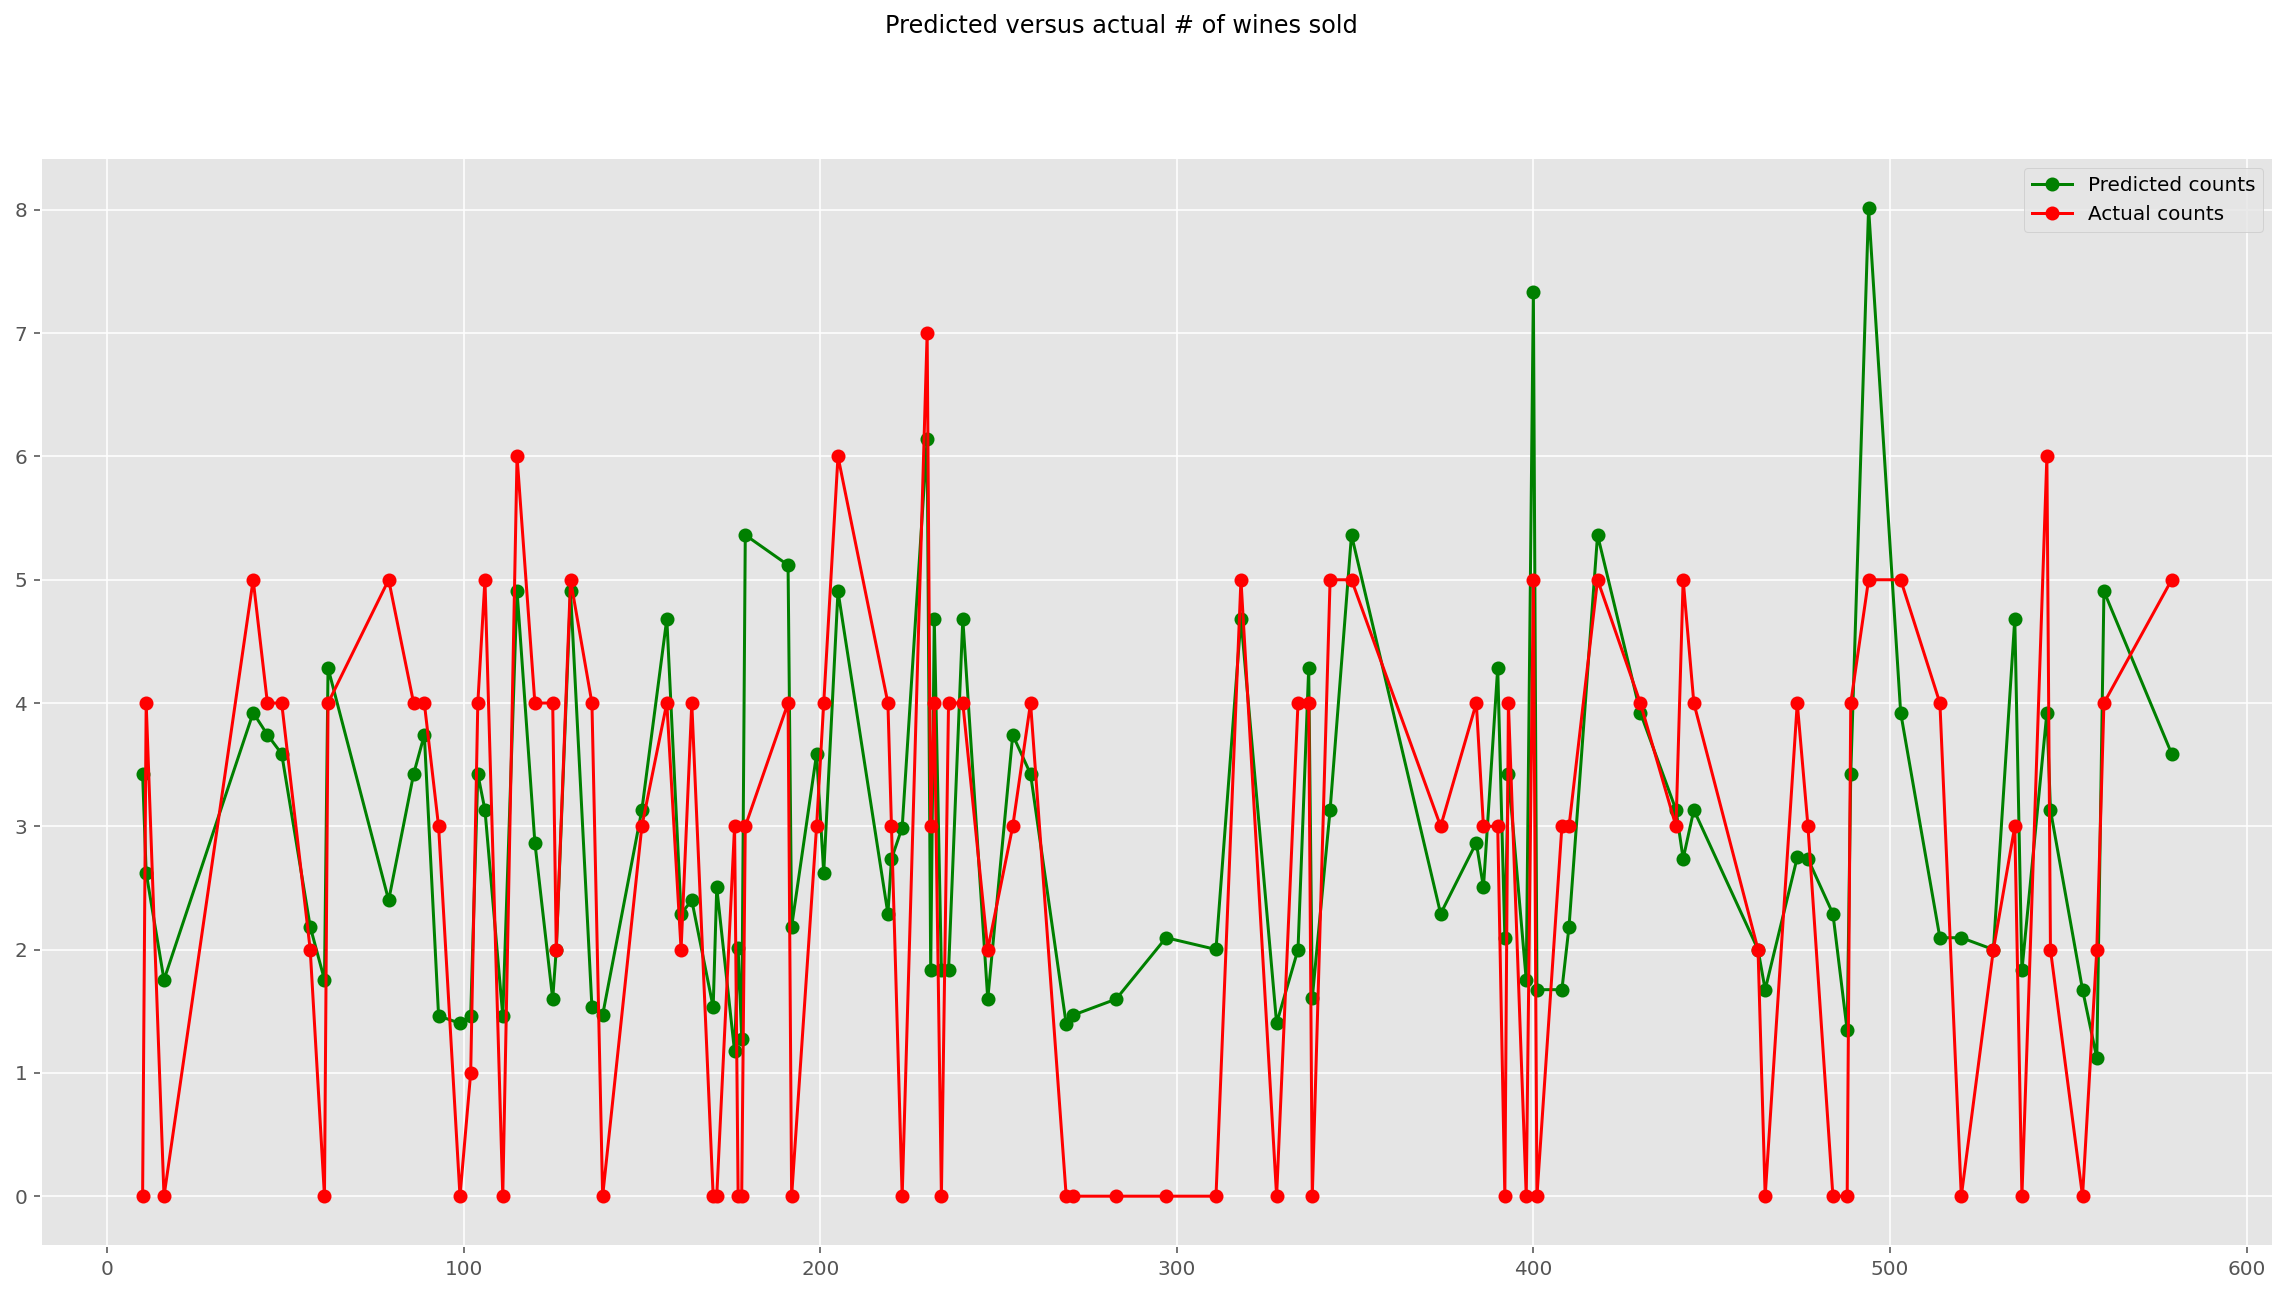

In [106]:
predicted_counts=predictions_summary_frame['mean'][:100]
actual_counts = y_test['TARGET'][:100]
fig = plt.figure(figsize=(20,10))
fig.suptitle('Predicted versus actual # of wines sold')
predicted, = plt.plot(X_test[:100].index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test[:100].index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show();

The model seems to be more or less tracking the trend in the actual counts although in many cases its predictions are way off the actual value.

#### Goodness-of-fit of the Poisson regression model

GLMResults from statsmodel show a couple of useful goodness-of-fit statistics that help us evaluate whether our Poisson regression model was able to successfully fit the training data. Let’s look at their values:

In [107]:
#getting # of residuals, deviance and pearson_chi2
df_residuals = 8547
deviance = poisson_results_model1.deviance
pearson_chi2 = poisson_results_model1.pearson_chi2

print('Residuals:',df_residuals, ' deviance:', deviance, ' pearson_chi2:', pearson_chi2)

Residuals: 8547  deviance: 9984.997311965095  pearson_chi2: 7361.532027655561


To make a quantitative determination of the goodness-of-fit at some confidence level, say 95% (p=0.05), we look up the value in the χ2 table for p=0.05 and Degrees of freedom of residuals=8547.  

In [108]:
from scipy.stats.distributions import chi2
chi2.ppf(0.05, df_residuals)

8333.088234258707

We compare this Chi-Squared value with the observed statistic, in this case, the Deviance or the Pearson’s chi-squared value reported in GLMResults are 7340 and 9964.

We find that at p=0.05 and DF Residuals = 8547, the chi-squared value from a standard Chi-Squared table is 8333, which despite is smaller than the Deviance is not smaller than the pearson_chi2, hence as per this test, the Poisson regression is a viable option to fit the training data but it not necassarily the best option, until presented with a better one.

We can calculate the RMSE of the Poisson with the code below:

In [109]:
predictions = poisson_results_model1.predict(X_test)
predicted_counts=np.round(predictions)
actual_counts = y_test['TARGET']
print('RMSE='+str(np.sqrt(np.sum(np.power(np.subtract(predicted_counts,actual_counts),2))/len(y_test['TARGET']))))

RMSE=1.4396762150960103


The Pearson statistic provides an estimate of the data’s dispersion. When the data is drawn from a Poisson distribution with sufficient samples the ratio Pearson chi2 / Df Residuals is approximately 1; for observed data a ratio less than 1 implies underdispersion and more than 1 implies overdispersion. Data that is underdispersed requires a zero-inflated model.

In [110]:
#getting the ratio Pearson chi2 / Df Residuals
pearson_chi2/df_residuals

0.8613001085358092

This suggests that a zero-inflated model will be required.

### Recreate Model 3 using Sklearn PoissonRegressor

We will now check if we can use sklearn to recreate the same model, and also to run a cross-validation (where we use the same logic for k=10 as the linear models) and get the RMSE.

In [111]:
#Explanatory with EDA
X = df[features_set1]

# Response
y = df['TARGET']

# Splitting the data into training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.linear_model import PoissonRegressor

#assign the poisson regression model to a variable
Poisson1 = PoissonRegressor()
Poisson1.fit(X_train, y_train)

#use k-fold cross validation with 10 folds
scores = cross_val_score(Poisson1, X_train, y_train, scoring = "neg_mean_squared_error" ,cv = 10)

# Printing out the RMSE Scores
poisson1_reg_scores = np.sqrt(-scores)
display_scores(poisson1_reg_scores)

Scores:

1.4148176581055905
1.4175671171144106
1.4395953551135805
1.4002132969446277
1.4223182947439565
1.440957836518195
1.394781834497379
1.3813327753658637
1.4134439786876194
1.391478149803974
---------------------------------------------------------
The Mean RMSE score : 1.4116506296895197 

---------------------------------------------------------
The Standard Deviation: 0.018823762081421357 



In [112]:
# testing set
# ---------------------------------------------
from sklearn.metrics import mean_squared_error
y_pred = Poisson1.predict(X_test)
Poisson1_mse = mean_squared_error(y_test, y_test_pred)
np.sqrt(Poisson1_mse)
#Poisson1_rmse

1.3430013577309075

In [113]:
print("The Root Mean Squared Error for the testing set is: ", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print("The variance explained by this model is:", metrics.explained_variance_score(y_test, y_test_pred))

The Root Mean Squared Error for the testing set is:  1.3430013577309075
The variance explained by this model is: 0.5142573810426745


### Model 4  Zero-inflated Poisson Regression.

In this model we will modify the standard count Poisson model to account for the presence of the extra zeroes, considering the response variable has a high number of zeros. We will implement a Zero Inflated Poisson regression model, often referred to as the ZIP model using the set of features 2.

We will follow the same reasoning as previously for data split and code structure.

In [114]:
## Splitting
df_train = df[features_set2_and_target][mask]
df_test = df[features_set2_and_target][~mask]

expr = """TARGET ~ AcidIndex + Density + VolatileAcidity + STARS + LabelAppeal"""

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

zip_training_results = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train, exog_infl=X_train, inflation='logit').fit()

print(zip_training_results.summary())

C:\Users\julir\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 1.602418
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


C:\Users\julir\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                  TARGET   No. Observations:                 8608
Model:             ZeroInflatedPoisson   Df Residuals:                     8602
Method:                            MLE   Df Model:                            5
Date:                 Sun, 28 Jun 2020   Pseudo R-squ.:                  0.1624
Time:                         22:56:12   Log-Likelihood:                -13794.
converged:                       False   LL-Null:                       -16468.
                                         LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
inflate_Intercept          -2.0152      0.228     -8.822      0.000      -2.463      -1.568
inflate_AcidIndex           3.4184      0.370      9.231      0.000       2.693     

The results show that all variables look to be statistical signifficantly and we can see their coefficients. Similar to the first poisson model, we can make predictions on the test data set and calculate the RMSE.

In [115]:
zip_predictions = zip_training_results.predict(X_test,exog_infl=X_test)
predicted_counts=np.round(zip_predictions)
actual_counts = y_test['TARGET']

print('ZIP RMSE='+str(np.sqrt(np.sum(np.power(np.subtract(predicted_counts,actual_counts),2))/len(y_test['TARGET']))))

ZIP RMSE=1.3294599152279256


We can see that the zero-inflated model shows an RMSE that is lower than the previous poisson model.

We would also like to see if the RMSE is still low using only the 3 main features

In [116]:
expr = """TARGET ~ AcidIndex + STARS + LabelAppeal"""

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

zip_training_results = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train, exog_infl=X_train, inflation='logit').fit()

print(zip_training_results.summary())

C:\Users\julir\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 1.603077
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


C:\Users\julir\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                  TARGET   No. Observations:                 8608
Model:             ZeroInflatedPoisson   Df Residuals:                     8604
Method:                            MLE   Df Model:                            3
Date:                 Sun, 28 Jun 2020   Pseudo R-squ.:                  0.1621
Time:                         22:56:13   Log-Likelihood:                -13799.
converged:                       False   LL-Null:                       -16468.
                                         LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
inflate_Intercept      -2.4294      0.164    -14.827      0.000      -2.751      -2.108
inflate_AcidIndex       3.7158      0.381      9.754      0.000       2.969       4.463
inflate_

In [117]:
zip_predictions = zip_training_results.predict(X_test,exog_infl=X_test)
predicted_counts=np.round(zip_predictions)
actual_counts = y_test['TARGET']

print('ZIP RMSE='+str(np.sqrt(np.sum(np.power(np.subtract(predicted_counts,actual_counts),2))/len(y_test['TARGET']))))

ZIP RMSE=1.340172333944213


#### Model 3 & Model 4 comparisons

RMSE scores

- The poisson 1 model seems to generalize well, but when we compare its performance on unseen data to that of the zero-inflated poisson it falls short as zero-inflated poisson seems to have the lowest RMSE score.

Features:
When using the zero-inflated poisson model in this specific case less is more as when we only use the main features that were selected on the basis of our domain knowledge/ EDA we get the lowest results of all the models in regards to the RMSE which is (1.289).



_________________________________________________________________________________________________

### Model 5  Negative Binomial Regression with EDA features.
Here we will use the 3 features (STARS, LabelAppeal and AcidIndex) to predict number of wines sold. We will take the input of the poisson regression to get the appropiate set of values to calculate this regression.

Using the poisson_training_results.mu from the poisson results we get the λ vector as a new column called ‘TARGET_LAMBDA’ to the Data Frame of the training data set. Rcollect that λ’s dimensions are (n x 1).

In [118]:
## Splitting
df_train = df[features_set1_and_target][mask]
df_test = df[features_set1_and_target][~mask]

In [119]:
df_train['TARGET_LAMBDA'] = poisson_results_model1.mu

Next, let’s add a derived column called ‘AUX_OLS_DEP’ to the pandas Data Frame. This new column will store the values of the dependent variable of the OLS regression. It is the left hand side of the OLS regression equation below:

In [120]:
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['TARGET'] - x['TARGET_LAMBDA'])**2 - x['TARGET']) / x['TARGET_LAMBDA'], axis=1)

In [121]:
df_train.head()
#check

,AcidIndex,LabelAppeal,STARS,TARGET,TARGET_LAMBDA,AUX_OLS_DEP
0,0.307692,2.0,2.0,3.0,3.133028,-0.951892
1,0.230769,1.0,3.0,3.0,4.089418,-0.443381
3,0.153846,1.0,1.0,3.0,2.389725,-1.099526
4,0.384615,2.0,2.0,4.0,2.866486,-0.947204
5,0.538462,2.0,0.0,0.0,1.282900,1.282900


Let’s use patsy to form the model specification for the OLSR. We want to tell patsy that AUX_OLS_DEP is the dependent variable and it is explained by TARGET_LAMBDA (which is the rate vector λ). The ‘-1’ at the end of the expression is patsy syntax for saying: do not to use an intercept of regression; i.e. just fit a straight line passing through the origin

In [122]:
ols_expr = """AUX_OLS_DEP ~ TARGET_LAMBDA - 1"""

Configure and fit the OLSR model:

In [123]:
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

Print the regression params, where the single coefficient being printed out corresponds to the single regression variable TARGET_LAMBDA. This coefficient is the __α__ that we were seeking:

In [124]:
print(aux_olsr_results.params)

TARGET_LAMBDA   -0.092492
dtype: float64


__Is α statistically significant?__

We now need to answer a very important question. Is this value of α (-0.092) statistically significant? Or can it be considered to be zero for all practical purposes?

Why is it so important to find this out? Recollect that if α is zero, then the following equation: reduces to Variance = mean. This is the variance function of the Poisson regression model.

If the value of α is statistically not significant, then the Negative Binomial regression model cannot do a better job of fitting the training data set than a Poisson regression model.

The OLSResults object contains the __t-score of the regression coefficient α.__ Let’s print it out:

In [125]:
aux_olsr_results.tvalues

TARGET_LAMBDA   -23.686538
dtype: float64

We need to determin if alpha is significant

In [126]:
nb1_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [127]:
print(nb1_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 TARGET   No. Observations:                 8608
Model:                            GLM   Df Residuals:                     8604
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 28 Jun 2020   Deviance:                       12180.
Time:                        22:56:14   Pearson chi2:                 9.31e+03
No. Iterations:                     9   Covariance Type:             nonrobust
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.5980      0.022     27.167      0.000       0.555       0.641
AcidIndex      -0.9777      0.058    -16.964     

C:\Users\julir\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1265: RuntimeWarning: invalid value encountered in log
  ll_obs = endog * np.log(self.alpha * mu)


From a t-value calculator, we can see that the critical t-value at a 99% confidence level (right-tailed), and degrees of freedom=8545 is 2.32. This value is greater than that t-statistic of alpha which was -23.6. We conclude that alpha is not statistically significantly.

Negative binomial can't explain more than the poisson model. We take a look at the RMSE.

In [128]:
predictions = nb1_training_results.predict(X_test)
predicted_counts=np.round(predictions)
actual_counts = y_test['TARGET']
print('RMSE='+str(np.sqrt(np.sum(np.power(np.subtract(predicted_counts,actual_counts),2))/len(y_test['TARGET']))))

RMSE=1.429873494087911


### Model 6  Negative Binomial Regression with EDA features plus backwards elimination
Here we will use the 6 features (STARS, LabelAppeal, AcidIndex, Alcohol, Density and VolatileAcidity) to predict number of wines sold. We will take the input of the poisson regression to get the appropiate set of values to calculate this regression.

In [129]:
## Splitting
df_train = df[features_set2_and_target][mask]
df_test = df[features_set2_and_target][~mask]

In [130]:
df_train['TARGET_LAMBDA'] = poisson_results_model1.mu

Next, let’s add a derived column called ‘AUX_OLS_DEP’ to the pandas Data Frame. This new column will store the values of the dependent variable of the OLS regression. It is the left hand side of the OLS regression equation below:

In [131]:
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['TARGET'] - x['TARGET_LAMBDA'])**2 - x['TARGET']) / x['TARGET_LAMBDA'], axis=1)

In [132]:
df_train.head()
#check

,AcidIndex,LabelAppeal,STARS,Alcohol,Density,VolatileAcidity,TARGET,TARGET_LAMBDA,AUX_OLS_DEP
0,0.307692,2.0,2.0,0.379310,0.495903,0.571429,3.0,3.133028,-0.951892
1,0.230769,1.0,3.0,0.237548,0.662231,0.078818,3.0,4.089418,-0.443381
3,0.153846,1.0,1.0,0.237548,0.512953,0.189655,3.0,2.389725,-1.099526
4,0.384615,2.0,2.0,0.524904,0.504286,0.162562,4.0,2.866486,-0.947204
5,0.538462,2.0,0.0,0.590038,0.527161,0.157635,0.0,1.282900,1.282900


Let’s use patsy to form the model specification for the OLSR. We want to tell patsy that AUX_OLS_DEP is the dependent variable and it is explained by TARGET_LAMBDA (which is the rate vector λ). The ‘-1’ at the end of the expression is patsy syntax for saying: do not to use an intercept of regression; i.e. just fit a straight line passing through the origin

In [133]:
ols_expr = """AUX_OLS_DEP ~ TARGET_LAMBDA - 1"""

Configure and fit the OLSR model:

In [134]:
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

Print the regression params, where the single coefficient being printed out corresponds to the single regression variable TARGET_LAMBDA. This coefficient is the __α__ that we were seeking:

In [135]:
print(aux_olsr_results.params)

TARGET_LAMBDA   -0.092492
dtype: float64


Here we got the same alpha value as the previous model, meaning that this negative binomial can't explain more than the poisson model. We take a look at the RMSE.

In [136]:
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [137]:
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 TARGET   No. Observations:                 8608
Model:                            GLM   Df Residuals:                     8604
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 28 Jun 2020   Deviance:                       12180.
Time:                        22:56:15   Pearson chi2:                 9.31e+03
No. Iterations:                     9   Covariance Type:             nonrobust
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.5980      0.022     27.167      0.000       0.555       0.641
AcidIndex      -0.9777      0.058    -16.964     

C:\Users\julir\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1265: RuntimeWarning: invalid value encountered in log
  ll_obs = endog * np.log(self.alpha * mu)


From a t-value calculator, we can see that the critical t-value at a 99% confidence level (right-tailed), and degrees of freedom=8545 is 2.32. This value is greater than that t-statistic of alpha which was -23.6. We conclude that alpha is not statistically significantly.

Negative binomial can't explain more than the poisson model. We take a look at the RMSE.

In [138]:
predictions = nb2_training_results.predict(X_test)
predicted_counts=np.round(predictions)
actual_counts = y_test['TARGET']
print('RMSE='+str(np.sqrt(np.sum(np.power(np.subtract(predicted_counts,actual_counts),2))/len(y_test['TARGET']))))

RMSE=1.429873494087911


The RMSE is the same in both negative binomial models.

# Model Selection

After trying out a combination of 6 statistical machine learning models along with 2 sets of features, we uncovered through an empirical process that the best set of features to use were that chosen through EDA and Domain knowledge: STARS, LabelAppeal and AcidIndex and feed them two a zero-inflated poisson. 

The reason for choosing a zero inflated model with this specific set of features is because, when we tried the regular poisson we got the ratio Pearson chi2 / Df Residuals less than 1 which implies underdispersion and data that is underdispersed requires a zero-inflated model. In addition, it provides a lower RMSE.

## Loading test data

Considering the test data is provided in a separate file, we will load it to see how it looks like before creating any of our models. We do this to make sure we don't have any problems in this new data. 

In [139]:
#loading test data
test = pd.read_csv('https://raw.githubusercontent.com/gitjuli/DAV-6150-Data-Science/master/Data/Project1_Eval.csv')
test.head()

,IN,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS
0,3,NaN,5.4,-0.860,0.27,-10.7,0.092,23.0,398.0,0.98527,5.02,0.64,12.30,-1,6,NaN
1,9,NaN,12.4,0.385,-0.76,-19.7,1.169,-37.0,68.0,0.99048,3.37,1.09,16.00,0,6,2.0
2,10,NaN,7.2,1.750,0.17,-33.0,0.065,9.0,76.0,1.04641,4.61,0.68,8.55,0,8,1.0
3,18,NaN,6.2,0.100,1.80,1.0,-0.179,104.0,89.0,0.98877,3.20,2.11,12.30,-1,8,1.0
4,21,NaN,11.4,0.210,0.28,1.2,0.038,70.0,53.0,1.02899,2.54,-0.07,4.80,0,10,NaN


In [140]:
#chequing null values
test.STARS.isnull().sum()

841

We apply the same strategy with the null values in the STARS column as before.

In [141]:
import warnings

In [142]:
#filling null values with zero
test['STARS'].fillna(0, inplace=True) # <------ do we keep this
test['TARGET'].fillna(0, inplace=True)

#sanity check
test['STARS'].isnull().sum()

0

Now lets look at the LabelAppeal to apply the same strategy as in the training set.

In [143]:
# Adding 2 to the entire column set
test["LabelAppeal"] = test["LabelAppeal"] + 2

test.LabelAppeal.value_counts()

2    1470
1     810
3     799
4     142
0     114
Name: LabelAppeal, dtype: int64

We need to normalize the AcidIndex to match the normalization perform on the training data, so we will apply the same logic of MinMaxScaler.

In [144]:
mm = MinMaxScaler()
X = mm.fit_transform(test['AcidIndex'].values.reshape(-1, 1))

In [145]:
#normalized = pd.DataFrame(X, columns = columns)
normalized = pd.DataFrame(X, index=test.index, columns = ["AcidIndex"])

In [146]:
test = test.drop('AcidIndex', axis=1)
result = pd.concat([test, normalized], axis=1).reindex(test.index)

In [147]:
result.columns = [ 'IN','TARGET','FixedAcidity','VolatileAcidity','CitricAcid','ResidualSugar',
                'Chlorides',  'FreeSulfurDioxide', 'TotalSulfurDioxide',
                 'Density','pH','Sulphates','Alcohol','LabelAppeal','STARS',
                 'AcidIndex']

In [148]:
result.columns

Index(['IN', 'TARGET', 'FixedAcidity', 'VolatileAcidity', 'CitricAcid',
       'ResidualSugar', 'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide',
       'Density', 'pH', 'Sulphates', 'Alcohol', 'LabelAppeal', 'STARS',
       'AcidIndex'],
      dtype='object')

In [149]:
test = result

Now we apply the selected model to the testing set.

In [150]:
## Splitting
df_train = df[features_set1_and_target]
df_test = test[features_set1_and_target]

expr = """TARGET ~ AcidIndex + STARS + LabelAppeal"""

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

zip_training_results = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train, exog_infl=X_train, inflation='logit').fit()

print(zip_training_results.summary())

C:\Users\julir\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 1.604539
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


C:\Users\julir\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                  TARGET   No. Observations:                10741
Model:             ZeroInflatedPoisson   Df Residuals:                    10737
Method:                            MLE   Df Model:                            3
Date:                 Sun, 28 Jun 2020   Pseudo R-squ.:                  0.1611
Time:                         22:56:17   Log-Likelihood:                -17234.
converged:                       False   LL-Null:                       -20544.
                                         LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
inflate_Intercept      -2.2600      0.144    -15.702      0.000      -2.542      -1.978
inflate_AcidIndex       3.2412      0.341      9.516      0.000       2.574       3.909
inflate_

In [151]:
# making predictions.
zip_predictions = zip_training_results.predict(X_test,exog_infl = X_test)
predicted_counts = np.round(zip_predictions)
predicted_df = pd.DataFrame(predicted_counts, columns = ['TARGET'])
predicted_df

,TARGET
0,2.0
1,4.0
2,3.0
3,3.0
4,1.0
...,...
3330,4.0
3331,6.0
3332,4.0
3333,3.0


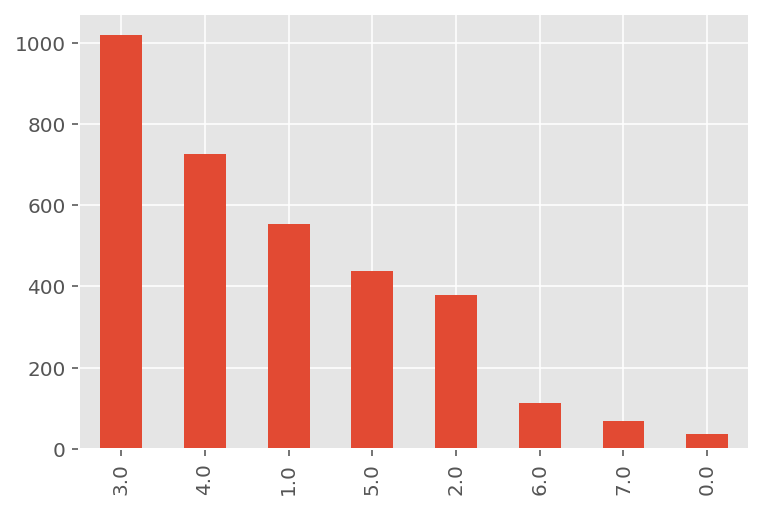

In [152]:
# chequing the final prediction counts for each value 
predicted_df = predicted_df.sort_values('TARGET')
predicted_df.TARGET.value_counts().plot(kind='bar');

In [153]:
predicted_df.TARGET.value_counts()

3.0    1020
4.0     727
1.0     554
5.0     437
2.0     379
6.0     112
7.0      69
0.0      37
Name: TARGET, dtype: int64

# Conclusion

In this study we went through a series of steps to develop statistical methods to find attributes of wine that are predictive of the amount of sales (in cases) that wine will have.

- We preformed EDA and developed domain knowledge to be able to have an understanding of the data. We then fied issues related to negative (invalid) numbers and null values. We empolyed the use of backwards and forward fill techniques because these methods preserved the probability density functions. 

- After our EDA we were able to select three main features (STARS, AcidIndex and LabelAppeal) which became our first set of features we fed to our models. We augmented this model by adding a few other features (Alcohol, Density, VolatileAcidity) to create a second set of explanatory variables to feed the models. We discovered that the first set of features provided better results despite having fewer amount of features than that of set 2.

- we created three different types of models: Linear regression, poisson regression and negative binomial regression. The regression model that performed best was the poisson model specifically the zero-inflated poisson model having the lowest RMSE values and providing the best predictions.

- The reason for choosing a zero inflated model with this specific set of features is because, when we tried the regular poisson we got the ratio Pearson chi2 / Df Residuals less than 1 which implies underdispersion and data that is underdispersed requires a zero-inflated model.

- We trained the selected zero-inflated poisson model with the entire training set to preform predictions on the unseen testing set.

### Refrences
[1] https://waterhouse.ucdavis.edu/whats-in-wine/fixed-acidity#:~:text=The%20predominant%20fixed%20acids%20found,2%2C000%20mg%2FL%20succinic%20acid.

[2] https://waterhouse.ucdavis.edu/whats-in-wine/volatile-acidity#:~:text=The%20average%20level%20of%20acetic,undetectable%20up%20to%203g%2FL.&text=The%20aroma%20threshold%20for%20acetic,on%20the%20variety%20and%20style.

[3] http://www.oiv.int/public/medias/3741/e-code-annex-maximum-acceptable-limits.pdf

[4] https://winefolly.com/deep-dive/what-is-residual-sugar-in-wine/#:~:text=Residual%20Sugar%20(or%20RS)%20is,5%20ounces%20%2F%20150%20ml)

[5] https://winefolly.com/deep-dive/sugar-in-wine-chart/

[6] http://www.oiv.int/public/medias/3741/e-code-annex-maximum-acceptable-limits.pdf

[7] https://www.campdenbri.co.uk/services/free-sulphur-dioxide.php#:~:text=Total%20and%20free%20sulphur%20dioxide,-Sulphur%20dioxide%20

[8] https://www.wineselectors.com.au/selector-magazine/wine/preserving-the-truth-on-sulphates-in-wine#:~:text=The%20main%20preservative%20used%20in,from%20oxidation%20and%20bacterial%20spoilage

[9] http://www.oiv.int/public/medias/3741/e-code-annex-maximum-acceptable-limits.pdf

[10] https://winefolly.com/deep-dive/understanding-acidity-in-wine/

[11] https://winefolly.com/deep-dive/sugar-in-wine-chart/

[12] Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow-O’reilly (2019). Chapter 2, page 66-67.

[13] https://dius.com.au/2017/08/03/using-statsmodels-glms-to-model-beverage-consumption/#cameron

[14] https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958

[15] https://machinelearningmastery.com/k-fold-cross-validation/

[16] https://dius.com.au/2017/08/03/using-statsmodels-glms-to-model-beverage-consumption/#cameron

[17] https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4